# Predictive Maintenance Use Case

To build the following model for predictive maintenance, we follow the structure of the CRISP-DM process.

# Overview

- [Business Understanding](#Business-Understanding)
<p>
- [Data Understanding](#Data-Understanding)
    - [Telemetry](#Telemetry)
    - [Errors](#Errors)
    - [Maintenance](#Maintenance)
    - [Machines](#Machines)
    - [Failures](#Failures)
<p>
- [Data Preparation](#Data-Preparation)
    - [Feature Engineering](#Feature-Engineering)
        - [Creation of telemtry-based lag features](#Creation-of-telemtry-based-lag-features)
        - [Creation of error-based lag features](#Creation-of-error-based-lag-features)
        - [Maintenance-based component replacement features](#Maintenance-based-component-replacement-features)
        - [Adding machine-based features](#Adding-machine-based-features)
    - [Labeled Dataframe](#Labeled-Dataframe)
        - [Labeled Dataframe for ANN](#Labeled-Dataframe-for-ANN)
<p>
    - [Training and Test Sets](#Training-and-Test-Sets)
        - [Non-Normalized](#Non-Normalized)
        - [Normalized with FE](#Normalized-with-FE)
        - [Normalized without FE](#Normalized-without-FE)
            - [Sequence Generation for LSTM](#Sequence-Generation-for-LSTM)
<p>
- [Modeling](#Modeling)
    - [Decision Tree](#M:-Decision-Tree)
    - [Random Forest](#M:-Random-Forest)
    - [Gradient Boosted Trees](#M:-Gradient-Boosted-Trees)
    - [Support Vector Machine](#M:-Support-Vector-Machine)
    - [Gaussian Naive Bayes](#M:-Gaussian-Naive-Bayes)
    - [K-Nearest Neighbors](#M:-K-Nearest-Neighbors)
    - [Logistic Regression](#M:-Logistic-Regression)
    - [Multilayer Perceptron with FE](#M:-Multilayer-Perceptron-with-FE)
    - [Multilayer Perceptron with FE not normalized](#M:-Multilayer-Perceptron-with-FE-not-normalized)
    - [Multilayer Perceptron without FE](#M:-Multilayer-Perceptron-without-FE)
    - [Outlook: Long-Short-Term-Memory-Network](#M:-Outlook:-Long-Short-Term-Memory-Network)         
<p>
- [Evaluation and Explanation](#Evaluation-and-Explanation)
    - [Decision Tree](#E:-Decision-Tree)
    - [Random Forest](#E:-Random-Forest)
    - [Gradient Boosted Trees](#E:-Gradient-Boosted-Trees)
        - [XGB: LIME](#XGB:-LIME)
        - [XGB: SHAP](#XGB:-SHAP)<p>
    - [Support Vector Machine](#E:-Support-Vector-Machine)
    - [Gaussian Naive Bayes](#E:-Gaussian-Naive-Bayes)
    - [K-Nearest Neighbors](#E:-K-Nearest-Neighbors)
    - [Logistic Regression](#E:-Logistic-Regression)
    - [Multilayer Perceptron with FE](#E:-Multilayer-Perceptron-with-FE)
    - [Multilayer Perceptron with FE not normalized](#E:-Multilayer-Perceptron-with-FE-not-normalized)
        - [MLP FE NN: LIME](#MLP-FE-NN:-LIME)
        - [MLP FE NN: SHAP](#MLP-FE-NN:-SHAP)<p>
    - [Multilayer Perceptron without FE](#E:-Multilayer-Perceptron-without-FE)
    - [Outlook: Long-Short-Term-Memory-Network](#E:-Outlook:-Long-Short-Term-Memory-Network)
        - [LSTM: LIME](#LSTM:-LIME)
        - [LSTM: SHAP](#LSTM:-SHAP)<p>
<p>
- [Deployment](#Deployment)
<p>
- [Data Export](#Data-Export)

## Business Understanding
[[Back to the top]](#Overview)

<i><b>CRISP-DM:</b> "This initial phase focuses on understanding the project objectives and requirements from a business perspective, and then converting this knowledge into a data mining problem definition, and a preliminary plan designed to achieve the objectives. A decision model, especially one built using the Decision Model and Notation standard can be used." [Source: Wiki]</i>

A major problem faced by businesses in asset-heavy industries such as manufacturing is the significant cost that is associated with delays in the production process due to mechanical problems (e.g. machine failures). Most of these businesses are interested in predicting these problems in advance so that they can proactively prevent the problems before they occur which reduces the costly impact caused by downtime.

The business problem for this specific case, is about predicting problems caused by component failures. With this, we hope to be able to answer the "What is the probability that a machine will fail in the near future due to a failure of a certain component" question. The problem is formatted as a multi-class classification problem and various machine learning algorithms are used to create different predictive models that learn from historical data collected from the sensors on the machines. Lastly, we will apply different result interpretation techniques, to understand and explain how and why more opaque models reached the conclusions that they did.

In the following sections, we go through the steps of implementing such a model which are data understanding and preparation (including feature engineering and label construction), Modeling and Evaluation. First, we start by explaining the data sources in the next section.

<b>Note:</b>  The data itself was created by data simulation methods by Microsoft.
<br><b>Source:</b> https://www.kaggle.com/yuansaijie0604/xinjiang-pm

## Data Understanding
[[Back to the top]](#Overview)

<i><b>CRISP-DM:</b> "The data understanding phase starts with an initial data collection and proceeds with activities in order to get familiar with the data, to identify data quality problems, to discover first insights into the data, or to detect interesting subsets to form hypotheses for hidden information." [Source: Wiki]</i>

The data for this model comes from 5 different sources which are real-time telemetry data collected from machines (telemetry), error messages, historical maintenance records, machine data (such as age and model) and failures.

### Telemetry
[[Back to the top]](#Overview)

In [1]:
#Import packages & Setup
import numpy as np #Linear Algebra
import pandas as pd #Data Frames / Analysis / Structuring / Import
import seaborn as sns #Plotting
import matplotlib.pyplot as plt #Plotting and using inline to not always repeat plt.show() statement
%matplotlib inline

In [2]:
#Importing Data
file = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\PdM_telemetry.csv' #Path
telemetry_df = pd.read_csv(file,
                           delimiter = ',',
                           parse_dates = ['datetime'],
                           error_bad_lines = False,#Skip Rows with errors
                           nrows = 1000000 #nrows = number of rows to import (to limit import size
                          )

b'Skipping line 92490: expected 6 fields, saw 9\n'


There is one irregularity in the dataset as seen in the error message above. While looking into the csv file, we notice that row 92490 is erroneous and will therefore be excluded for the remainder of this analysis.

In [3]:
telemetry_df.head()

datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2 2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3 2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4 2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511

In [4]:
telemetry_df.tail()

datetime  machineID        volt      rotate    pressure  \
968583 2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
968584 2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
968585 2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
968586 2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
968587 2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

        vibration  
968583  50.771941  
968584  35.123072  
968585  48.314561  
968586  44.835259  
968587  37.845245

In the following, a quick <b>check for duplicate values</b> in the telemetry dataframe:

In [5]:
telemetry_df.duplicated().value_counts()

False    876100
True      92488
dtype: int64

As we can see above, there are 92,488 rows, which represent duplicate values. We can be certain that this is correct for two reasons. First, we know that we have 100 machines with hourly measurements over the course of 1 year plus one additional measurement for each machine (as the data starts at 6am and ends at 6am and not at 5am), so there are 24*365+1=8,761 measurements per machine... times 100 machines = 876,100 measurements, which is the expected total (and corresponds to the "False" values in the check above). Second, the .duplicated() method as a default considers ALL columns in the dataframe... So if only one tiny digit would change, it would already not count as a duplicate anymore. Therefore, we conclude that there are 92,488 rows, which represent duplicates and must be removed before continuing.

In [6]:
#Removing duplicates
telemetry_df = telemetry_df.drop_duplicates()

#Resetting the index
telemetry_df = telemetry_df.reset_index(drop = True) #Drop the old index

telemetry_df.tail()

datetime  machineID        volt      rotate    pressure  \
876095 2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
876096 2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
876097 2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
876098 2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
876099 2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

        vibration  
876095  50.771941  
876096  35.123072  
876097  48.314561  
876098  44.835259  
876099  37.845245

As we can see above, the dataframe is now cleaned from duplicate values and contains 876,100 rows, which is the correct number of rows.

In [7]:
telemetry_df.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration'], dtype='object')

In [8]:
telemetry_df.isnull().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64

None of these rows has a missing or nan or null value, perfect!

In [9]:
telemetry_df.describe(include = 'all')

datetime      machineID           volt         rotate  \
count                876100  876100.000000  876100.000000  876100.000000   
unique                 8761            NaN            NaN            NaN   
top     2015-04-12 11:00:00            NaN            NaN            NaN   
freq                    100            NaN            NaN            NaN   
first   2015-01-01 06:00:00            NaN            NaN            NaN   
last    2016-01-01 06:00:00            NaN            NaN            NaN   
mean                    NaN      50.500000     170.777736     446.605119   
std                     NaN      28.866087      15.509114      52.673886   
min                     NaN       1.000000      97.333604     138.432075   
25%                     NaN      25.750000     160.304927     412.305714   
50%                     NaN      50.500000     170.607338     447.558150   
75%                     NaN      75.250000     181.004493     482.176600   
max                     NaN     100.000000     255.124717     695.020984   

             pressure      vibration  
count   876100.000000  876100.000000  
unique            NaN            NaN  
top               NaN            NaN  
freq              NaN            NaN  
first             NaN            NaN  
last              NaN            NaN  
mean       100.858668      40.385007  
std         11.048679       5.370361  
min         51.237106      14.877054  
25%         93.498181      36.777299  
50%        100.425559      40.237247  
75%        107.555231      43.784938  
max        185.951998      76.791072

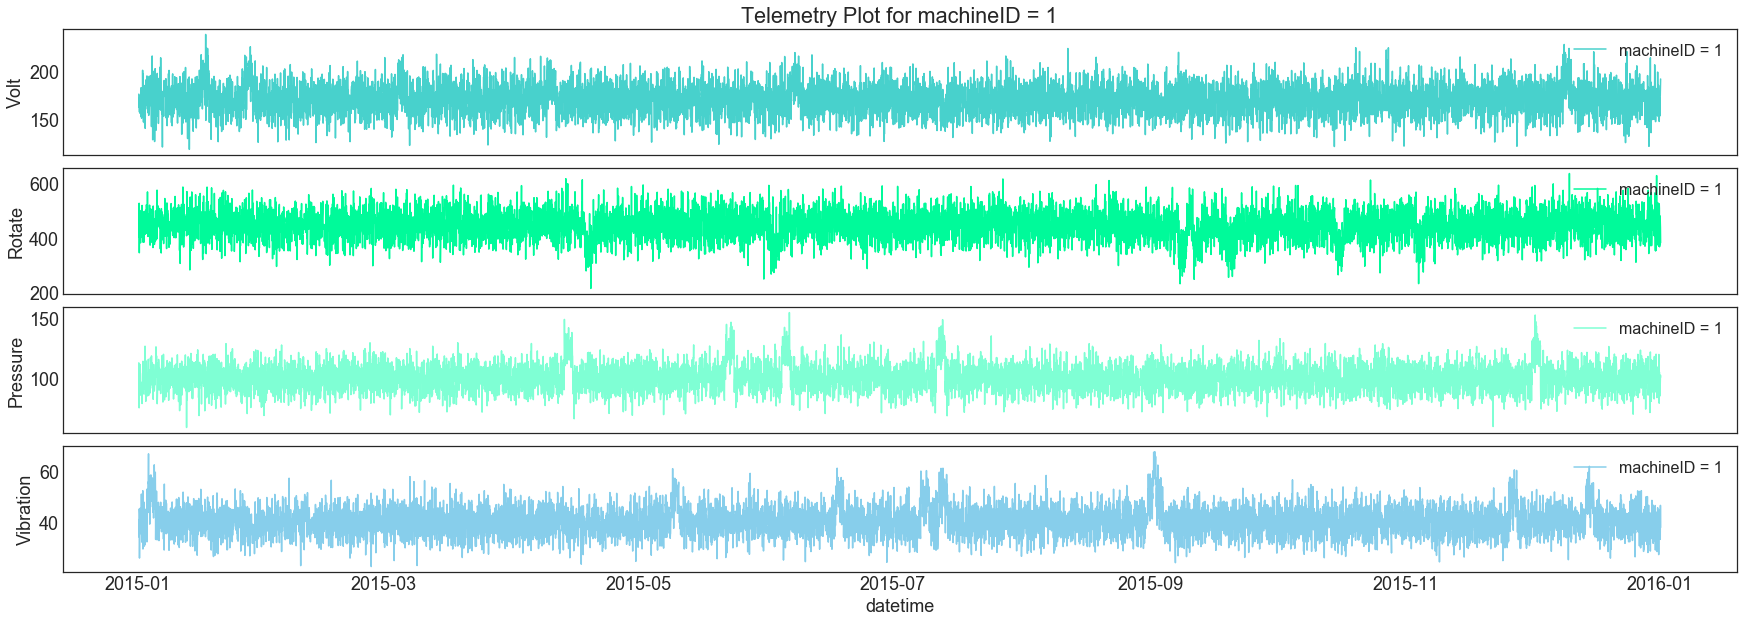

In [10]:
date_mID1 = telemetry_df[(telemetry_df.machineID == 1)]['datetime']
volt_mID1 = telemetry_df[(telemetry_df.machineID == 1)]['volt']
rotate_mID1 = telemetry_df[(telemetry_df.machineID == 1)]['rotate']
pressure_mID1 = telemetry_df[(telemetry_df.machineID == 1)]['pressure']
vibr_mID1 = telemetry_df[(telemetry_df.machineID == 1)]['vibration']

sns.set_style("white") #Alternatively: sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 18})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (30, 10), sharex = True)
fig.subplots_adjust(hspace = 0.1) #Remove / Reduce space between plots

ax1.plot(date_mID1, volt_mID1, 'mediumturquoise', label = 'machineID = 1')
ax1.set(title = 'Telemetry Plot for machineID = 1', ylabel = 'Volt')
ax1.legend(loc = 'upper right', fontsize = 16)

ax2.plot(date_mID1, rotate_mID1, 'mediumspringgreen', label = 'machineID = 1')
ax2.set(ylabel = 'Rotate')
ax2.legend(loc = 'upper right', fontsize = 16)

ax3.plot(date_mID1, pressure_mID1, 'aquamarine', label = 'machineID = 1')
ax3.set(ylabel = 'Pressure')
ax3.legend(loc = 'upper right', fontsize = 16)

ax4.plot(date_mID1, vibr_mID1, 'skyblue', label = 'machineID = 1')
ax4.set(xlabel = 'datetime', ylabel = 'Vibration')
ax4.legend(loc = 'upper right', fontsize = 16)

### Errors
[[Back to the top]](#Overview)

The second major data source are error logs. These are non-breaking errors thrown while the machine was still operational and do not count as failures. The <b>error date and times are rounded to the closest hour</b> since the telemetry data is collected at an hourly rate.

In [11]:
#Importing Data
file = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\PdM_errors.csv' #Path
error_df = pd.read_csv(file,
                           delimiter = ',',
                           parse_dates = ['datetime'],
                           error_bad_lines = False,#Skip Rows with errors
                           nrows = 1000000 #nrows = number of rows to import (to limit import size
                          )

In [12]:
error_df.head()

datetime  machineID errorID
0 2015-01-03 07:00:00          1  error1
1 2015-01-03 20:00:00          1  error3
2 2015-01-04 06:00:00          1  error5
3 2015-01-10 15:00:00          1  error4
4 2015-01-22 10:00:00          1  error4

In [13]:
error_df.tail()

datetime  machineID errorID
3914 2015-11-21 08:00:00        100  error2
3915 2015-12-04 02:00:00        100  error1
3916 2015-12-08 06:00:00        100  error2
3917 2015-12-08 06:00:00        100  error3
3918 2015-12-22 03:00:00        100  error3

In [14]:
error_df.duplicated().value_counts()

False    3919
dtype: int64

No duplicate values, perfect!

In [15]:
error_df.columns

Index(['datetime', 'machineID', 'errorID'], dtype='object')

In [16]:
error_df.isnull().sum()

datetime     0
machineID    0
errorID      0
dtype: int64

None of these rows has a missing or nan or null value, perfect!

In [17]:
error_df.describe(include = 'all')

datetime    machineID errorID
count                  3919  3919.000000    3919
unique                 2720          NaN       5
top     2015-12-08 06:00:00          NaN  error1
freq                     12          NaN    1010
first   2015-01-01 06:00:00          NaN     NaN
last    2016-01-01 05:00:00          NaN     NaN
mean                    NaN    51.044654     NaN
std                     NaN    28.954988     NaN
min                     NaN     1.000000     NaN
25%                     NaN    25.000000     NaN
50%                     NaN    51.000000     NaN
75%                     NaN    77.000000     NaN
max                     NaN   100.000000     NaN

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

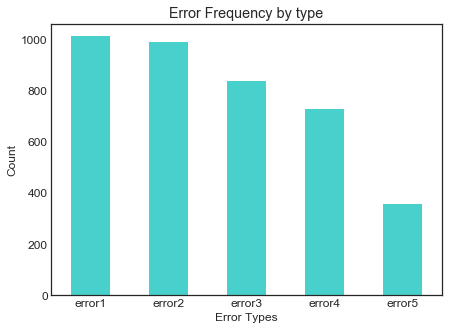

In [18]:
error_counts = error_df['errorID'].value_counts()

plt.rcParams.update({'font.size': 12})
plt.title('Error Frequency by type')
plt.xlabel('Error Types')
plt.ylabel('Count')
error_counts.plot(kind = 'bar', color = 'mediumturquoise', figsize = (7, 5))
plt.xticks(rotation = 0) #Force x-axis labels to be horizontal

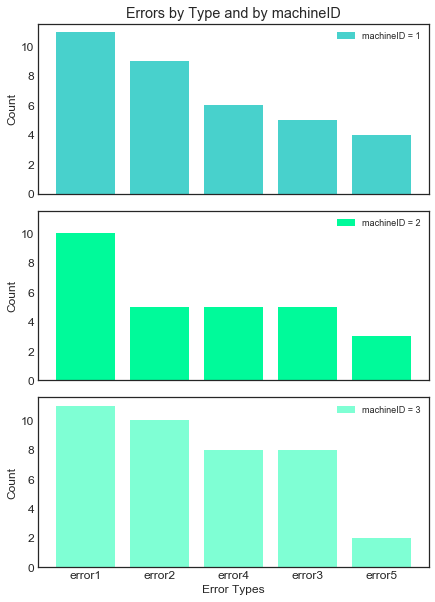

In [19]:
errors_mID1 = dict(error_df[(error_df.machineID == 1)]['errorID'].value_counts())
errors_mID2 = dict(error_df[(error_df.machineID == 2)]['errorID'].value_counts())
errors_mID3 = dict(error_df[(error_df.machineID == 3)]['errorID'].value_counts())

plt.rcParams.update({'font.size': 12})
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (7, 10), sharey = True, sharex = True)
fig.subplots_adjust(hspace = 0.1) #Remove / Reduce space between plots

ax1.bar(errors_mID1.keys(), list(errors_mID1.values()), color = 'mediumturquoise', label = 'machineID = 1')
ax1.set(title = 'Errors by Type and by machineID', ylabel = 'Count')
ax1.legend(loc = 'upper right', fontsize = 9)

ax2.bar(errors_mID2.keys(), list(errors_mID2.values()), color = 'mediumspringgreen', label = 'machineID = 2')
ax2.set(ylabel = 'Count')
ax2.legend(loc = 'upper right', fontsize = 9)

ax3.bar(errors_mID3.keys(), list(errors_mID3.values()), color = 'aquamarine', label = 'machineID = 3')
ax3.set(xlabel = 'Error Types', ylabel = 'Count')
ax3.legend(loc = 'upper right', fontsize = 9)

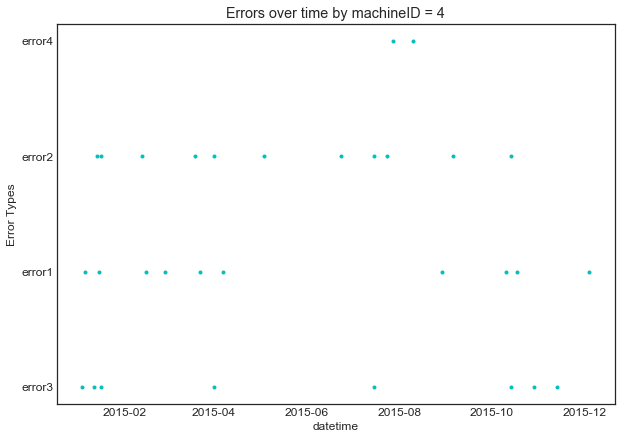

In [20]:
errors_dt_mID4 = error_df[(error_df.machineID == 4)]
errors_dt_mID4 = errors_dt_mID4[['datetime', 'errorID']].copy()

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()

ax.plot(errors_dt_mID4['datetime'], errors_dt_mID4['errorID'], '.c')
ax.set(title = 'Errors over time by machineID = 4', xlabel = 'datetime', ylabel = 'Error Types')
fig.set_figwidth(10)
fig.set_figheight(7)

### Maintenance
[[Back to the top]](#Overview)

These are the scheduled and unscheduled maintenance records which correspond to both regular inspection of components as well as inspections due to failures. <b>A record is generated if a component is replaced during the scheduled inspection or replaced due to a break down</b>. The <b>records that are created due to break downs will be called failures</b> which is explained in the later sections. Maintenance data has both 2014 and 2015 records.

In [21]:
#Importing Data
file = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\PdM_maint.csv' #Path
maintenance_df = pd.read_csv(file,
                           delimiter = ',',
                           parse_dates = ['datetime'],
                           error_bad_lines = False,#Skip Rows with errors
                           nrows = 1000000 #nrows = number of rows to import (to limit import size
                          )

In [22]:
maintenance_df.head()

datetime  machineID   comp
0 2014-06-01 06:00:00          1  comp2
1 2014-07-16 06:00:00          1  comp4
2 2014-07-31 06:00:00          1  comp3
3 2014-12-13 06:00:00          1  comp1
4 2015-01-05 06:00:00          1  comp4

In [23]:
maintenance_df.tail()

datetime  machineID   comp
3281 2015-10-10 06:00:00        100  comp3
3282 2015-10-25 06:00:00        100  comp4
3283 2015-11-09 06:00:00        100  comp4
3284 2015-12-09 06:00:00        100  comp2
3285 2015-12-24 06:00:00        100  comp2

In [24]:
maintenance_df.duplicated().value_counts()

False    3286
dtype: int64

No duplicate values, perfect!

In [25]:
maintenance_df.columns

Index(['datetime', 'machineID', 'comp'], dtype='object')

In [26]:
maintenance_df.isnull().sum()

datetime     0
machineID    0
comp         0
dtype: int64

None of these rows has a missing or nan or null value, perfect!

In [27]:
maintenance_df.describe(include = 'all')

datetime    machineID   comp
count                  3286  3286.000000   3286
unique                  374          NaN      4
top     2014-11-28 06:00:00          NaN  comp2
freq                     37          NaN    863
first   2014-06-01 06:00:00          NaN    NaN
last    2016-01-01 06:00:00          NaN    NaN
mean                    NaN    50.284236    NaN
std                     NaN    28.914478    NaN
min                     NaN     1.000000    NaN
25%                     NaN    25.250000    NaN
50%                     NaN    50.000000    NaN
75%                     NaN    75.000000    NaN
max                     NaN   100.000000    NaN

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

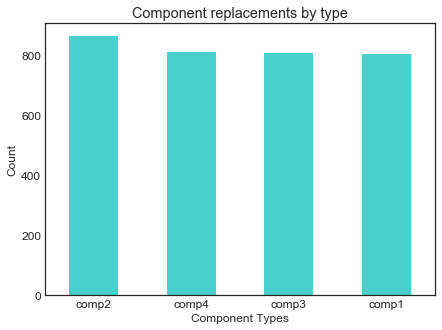

In [28]:
component_counts = maintenance_df['comp'].value_counts()

plt.title('Component replacements by type')
plt.xlabel('Component Types')
plt.ylabel('Count')
plt.rcParams.update({'font.size': 12})
component_counts.plot(kind = 'bar', color = 'mediumturquoise', figsize = (7, 5))
plt.xticks(rotation = 0) #Force x-axis labels to be horizontal

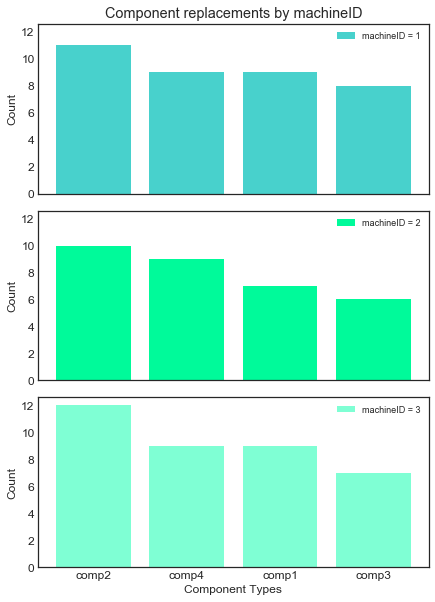

In [29]:
comp_mID1 = dict(maintenance_df[(maintenance_df.machineID == 1)]['comp'].value_counts())
comp_mID2 = dict(maintenance_df[(maintenance_df.machineID == 2)]['comp'].value_counts())
comp_mID3 = dict(maintenance_df[(maintenance_df.machineID == 3)]['comp'].value_counts())

plt.rcParams.update({'font.size': 12})
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (7, 10), sharey = True, sharex = True)
fig.subplots_adjust(hspace = 0.1) #Remove / Reduce space between plots

ax1.bar(comp_mID1.keys(), list(comp_mID1.values()), color = 'mediumturquoise', label = 'machineID = 1')
ax1.set(title = 'Component replacements by machineID', ylabel = 'Count')
ax1.legend(loc = 'upper right', fontsize = 9)

ax2.bar(comp_mID2.keys(), list(comp_mID2.values()), color = 'mediumspringgreen', label = 'machineID = 2')
ax2.set(ylabel = 'Count')
ax2.legend(loc = 'upper right', fontsize = 9)

ax3.bar(comp_mID3.keys(), list(comp_mID3.values()), color = 'aquamarine', label = 'machineID = 3')
ax3.set(xlabel = 'Component Types', ylabel = 'Count')
ax3.legend(loc = 'upper right', fontsize = 9)

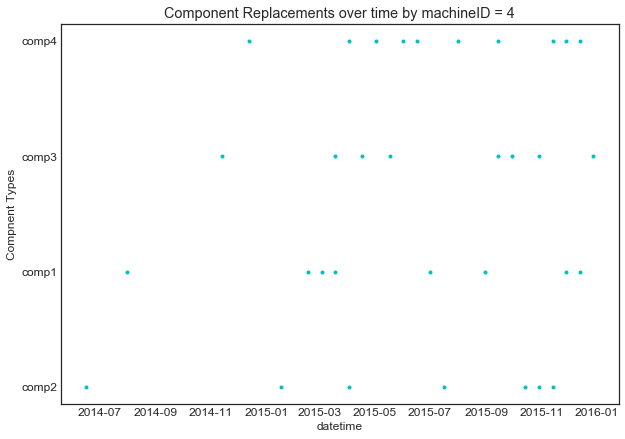

In [30]:
comp_dt_mID4 = maintenance_df[(maintenance_df.machineID == 4)]
comp_dt_mID4 = comp_dt_mID4[['datetime', 'comp']].copy()

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()

ax.plot(comp_dt_mID4['datetime'], comp_dt_mID4['comp'], '.c')
ax.set(title = 'Component Replacements over time by machineID = 4', xlabel = 'datetime', ylabel = 'Compnent Types')
fig.set_figwidth(10)
fig.set_figheight(7)

### Machines
[[Back to the top]](#Overview)

This data set includes information about model type and age (years in service) of the machines.

In [31]:
#Importing Data
file = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\PdM_machines.csv' #Path
machine_df = pd.read_csv(file,
                           delimiter = ',',
                           #parse_dates = ['datetime'],
                           error_bad_lines = False,#Skip Rows with errors
                           nrows = 1000000 #nrows = number of rows to import (to limit import size
                          )

In [32]:
machine_df.head()

machineID   model  age
0          1  model3   18
1          2  model4    7
2          3  model3    8
3          4  model3    7
4          5  model3    2

In [33]:
machine_df.tail()

machineID   model  age
95         96  model2   10
96         97  model2   14
97         98  model2   20
98         99  model1   14
99        100  model4    5

In [34]:
machine_df.duplicated().value_counts()

False    100
dtype: int64

No duplicate values, perfect!

In [35]:
machine_df.columns

Index(['machineID', 'model', 'age'], dtype='object')

In [36]:
machine_df.isnull().sum()

machineID    0
model        0
age          0
dtype: int64

None of these rows has a missing or nan or null value, perfect!

In [37]:
machine_df.describe(include = 'all')

machineID   model         age
count   100.000000     100  100.000000
unique         NaN       4         NaN
top            NaN  model3         NaN
freq           NaN      35         NaN
mean     50.500000     NaN   11.330000
std      29.011492     NaN    5.856974
min       1.000000     NaN    0.000000
25%      25.750000     NaN    6.750000
50%      50.500000     NaN   12.000000
75%      75.250000     NaN   16.000000
max     100.000000     NaN   20.000000

In [38]:
#Machine age statistics by model
age_statistics = machine_df['age'].groupby(machine_df['model']).describe()
age_statistics

count       mean       std  min    25%   50%    75%   max
model                                                            
model1   16.0  12.250000  5.385165  2.0   9.25  14.0  16.00  20.0
model2   17.0  12.764706  5.847322  2.0  10.00  14.0  18.00  20.0
model3   35.0  12.028571  5.607168  1.0   8.50  14.0  17.00  20.0
model4   32.0   9.343750  6.099230  0.0   4.00   9.5  14.25  20.0

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

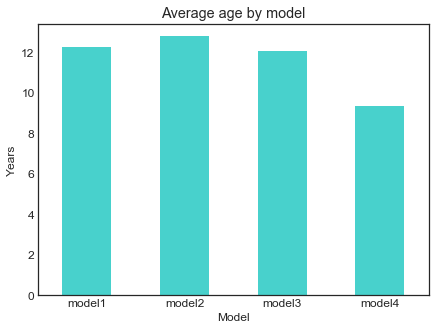

In [39]:
age_statistics['mean'].plot(kind = 'bar', color = 'mediumturquoise', figsize = (7, 5))
plt.title('Average age by model')
plt.xlabel('Model')
plt.ylabel('Years')
plt.rcParams.update({'font.size': 12})
plt.xticks(rotation = 0) #Force x-axis labels to be horizontal

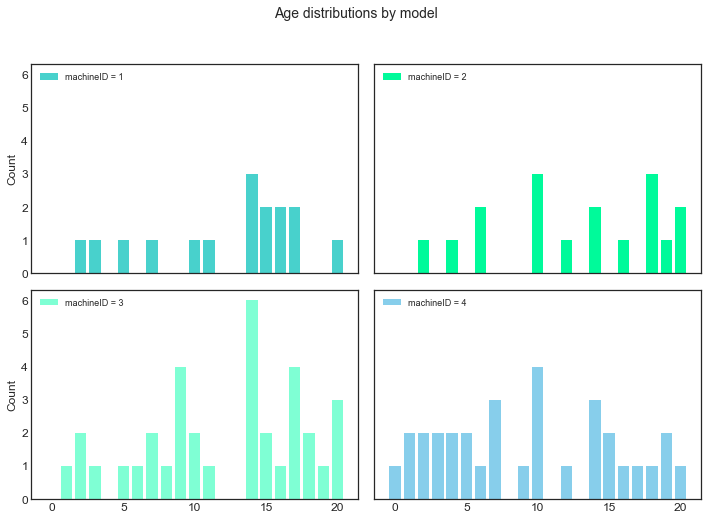

In [40]:
ages_model1 = dict(machine_df[(machine_df.model == 'model1')]['age'].value_counts())
ages_model2 = dict(machine_df[(machine_df.model == 'model2')]['age'].value_counts())
ages_model3 = dict(machine_df[(machine_df.model == 'model3')]['age'].value_counts())
ages_model4 = dict(machine_df[(machine_df.model == 'model4')]['age'].value_counts())

plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(2, 2, figsize = (12, 8), sharey = True, sharex = True)
fig.subplots_adjust(hspace = 0.08, wspace = 0.05) #Remove / Reduce space between plots
fig.suptitle("Age distributions by model", fontsize = 14)

axs[0,0].bar(ages_model1.keys(), list(ages_model1.values()), color = 'mediumturquoise', label = 'machineID = 1')
axs[0,0].set(ylabel = 'Count')
axs[0,0].legend(loc = 'upper left', fontsize = 9)

axs[0,1].bar(ages_model2.keys(), list(ages_model2.values()), color = 'mediumspringgreen', label = 'machineID = 2')
#axs[0,1].set(ylabel = 'Count')
axs[0,1].legend(loc = 'upper left', fontsize = 9)

axs[1,0].bar(ages_model3.keys(), list(ages_model3.values()), color = 'aquamarine', label = 'machineID = 3')
axs[1,0].set(ylabel = 'Count')
axs[1,0].legend(loc = 'upper left', fontsize = 9)

axs[1,1].bar(ages_model4.keys(), list(ages_model4.values()), color = 'skyblue', label = 'machineID = 4')
#axs[1,1].set(ylabel = 'Count')
axs[1,1].legend(loc = 'upper left', fontsize = 9)

### Failures
[[Back to the top]](#Overview)

These are the records of component replacements due to failures. Each record has a date and time, machine ID and failed component type.

In [41]:
#Importing Data
file = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\PdM_failures.csv' #Path
failure_df = pd.read_csv(file,
                           delimiter = ',',
                           parse_dates = ['datetime'],
                           error_bad_lines = False,#Skip Rows with errors
                           nrows = 1000000 #nrows = number of rows to import (to limit import size
                          )

In [42]:
failure_df.head()

datetime  machineID failure
0 2015-01-05 06:00:00          1   comp4
1 2015-03-06 06:00:00          1   comp1
2 2015-04-20 06:00:00          1   comp2
3 2015-06-19 06:00:00          1   comp4
4 2015-09-02 06:00:00          1   comp4

In [43]:
failure_df.tail()

datetime  machineID failure
756 2015-11-29 06:00:00         99   comp3
757 2015-12-14 06:00:00         99   comp4
758 2015-02-12 06:00:00        100   comp1
759 2015-09-10 06:00:00        100   comp1
760 2015-12-09 06:00:00        100   comp2

In [44]:
failure_df.duplicated().value_counts()

False    761
dtype: int64

No duplicate values, perfect!

In [45]:
failure_df.columns

Index(['datetime', 'machineID', 'failure'], dtype='object')

In [46]:
failure_df.isnull().sum()

datetime     0
machineID    0
failure      0
dtype: int64

None of these rows has a missing or nan or null value, perfect!

In [47]:
failure_df.describe(include = 'all')

datetime   machineID failure
count                   761  761.000000     761
unique                  302         NaN       4
top     2015-01-02 03:00:00         NaN   comp2
freq                     18         NaN     259
first   2015-01-02 03:00:00         NaN     NaN
last    2015-12-31 06:00:00         NaN     NaN
mean                    NaN   51.911958     NaN
std                     NaN   29.515542     NaN
min                     NaN    1.000000     NaN
25%                     NaN   24.000000     NaN
50%                     NaN   51.000000     NaN
75%                     NaN   79.000000     NaN
max                     NaN  100.000000     NaN

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

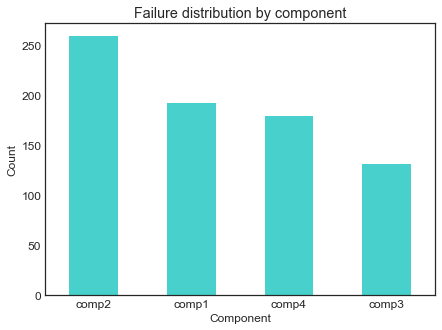

In [48]:
failure_df['failure'].value_counts().plot(kind = 'bar', color = 'mediumturquoise', figsize = (7, 5))
plt.title('Failure distribution by component')
plt.xlabel('Component')
plt.ylabel('Count')
plt.rcParams.update({'font.size': 12})
plt.xticks(rotation = 0) #Force x-axis labels to be horizontal

In [49]:
#Amount of failures by machineID and component
failure_stats = failure_df.groupby(['machineID', 'failure']).count()
failure_stats.rename(columns = {'datetime': '#Occurences'}, inplace = True)
failure_stats.head(7)

#Occurences
machineID failure             
1         comp1              1
          comp2              2
          comp4              4
2         comp1              1
          comp2              3
3         comp1              1
          comp2              4

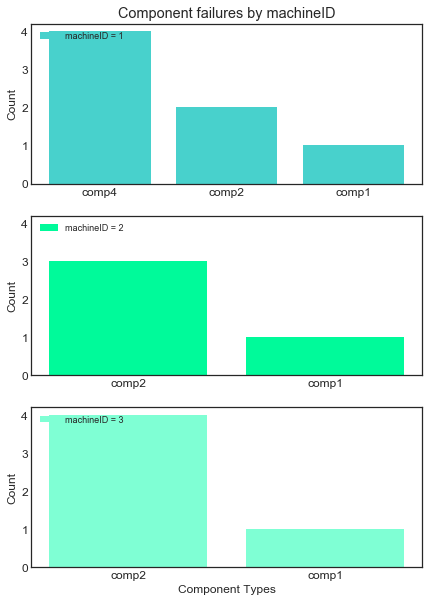

In [50]:
fails_mID1 = dict(failure_df[(failure_df.machineID == 1)]['failure'].value_counts())
fails_mID2 = dict(failure_df[(failure_df.machineID == 2)]['failure'].value_counts())
fails_mID3 = dict(failure_df[(failure_df.machineID == 3)]['failure'].value_counts())

plt.rcParams.update({'font.size': 12})
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (7, 10), sharey = True)
fig.subplots_adjust(hspace = 0.2) #Remove / Reduce space between plots

ax1.bar(fails_mID1.keys(), list(fails_mID1.values()), color = 'mediumturquoise', label = 'machineID = 1')
ax1.set(title = 'Component failures by machineID', ylabel = 'Count')
ax1.legend(loc = 'upper left', fontsize = 9)

ax2.bar(fails_mID2.keys(), list(fails_mID2.values()), color = 'mediumspringgreen', label = 'machineID = 2')
ax2.set(ylabel = 'Count')
ax2.legend(loc = 'upper left', fontsize = 9)

ax3.bar(fails_mID3.keys(), list(fails_mID3.values()), color = 'aquamarine', label = 'machineID = 3')
ax3.set(xlabel = 'Component Types', ylabel = 'Count')
ax3.legend(loc = 'upper left', fontsize = 9)

## Data Preparation
[[Back to the top]](#Overview)

<i><b>CRISP-DM:</b> "The data preparation phase covers all activities to construct the final dataset (data that will be fed into the modeling tool(s)) from the initial raw data. Data preparation tasks are likely to be performed multiple times, and not in any prescribed order. Tasks include table, record, and attribute selection as well as transformation and cleaning of data for modeling tools." [Source: Wiki]</i>

### Feature Engineering
[[Back to the top]](#Overview)

An important step in predictive maintenance applications is <b>feature engineering</b>, which requires bringing the different data sources together to create features that best describe a machines's health condition at a given point in time. In the next subsections, different types of feature engineering methods are used to create features based on the properties of each data source.

#### Creation of telemtry-based lag features
[[Back to the top]](#Overview)

Telemetry data often comes with time-stamps which makes it suitable for calculating lagging features. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean and standard deviation to represent the short term history of the telemetry data over the lag window. 

In the following, we will calculate the <b>rolling mean and standard deviation of telemetry data for every last 3 hours</b> (=lag window) and machineID. This allows us to capture more <b>short-term effects</b> on the variation of those parameters.

In [51]:
#Calcuation of the rolling mean with a rolling window of t=3 hours(width=3), for every 3 hours and for every machine ID
temp_list = []
features = ['volt', 'rotate', 'pressure', 'vibration']
for feature in features:
    temp_list.append(pd.pivot_table(telemetry_df, 
                                    index = 'datetime',
                                    columns = 'machineID',
                                    values = feature).rolling(3).mean().dropna().unstack())
tel_mean_3h = pd.concat(temp_list, axis = 1)
tel_mean_3h.columns = [x + '_mean_3h' for x in features]
tel_mean_3h.reset_index(inplace = True)
tel_mean_3h.head()

machineID            datetime  volt_mean_3h  rotate_mean_3h  \
0          1 2015-01-01 08:00:00    170.028993      449.533798   
1          1 2015-01-01 09:00:00    165.443986      425.415550   
2          1 2015-01-01 10:00:00    163.687586      436.292011   
3          1 2015-01-01 11:00:00    164.192565      403.949857   
4          1 2015-01-01 12:00:00    162.223630      454.923953   

   pressure_mean_3h  vibration_mean_3h  
0         94.592122          40.893502  
1         93.315664          39.571655  
2         98.791038          33.763834  
3        105.687417          34.255891  
4        106.523125          34.799816

In [52]:
#Calcuation of the rolling std with a rolling window of t=3 hours(width=3), for every 3 hours and for every machine ID
temp_list = []
features = ['volt', 'rotate', 'pressure', 'vibration']
for feature in features:
    temp_list.append(pd.pivot_table(telemetry_df, 
                                    index = 'datetime',
                                    columns = 'machineID',
                                    values = feature).rolling(3).std().dropna().unstack())
tel_std_3h = pd.concat(temp_list, axis = 1)
tel_std_3h.columns = [x + '_std_3h' for x in features]
tel_std_3h.reset_index(inplace = True)
tel_std_3h.head()

machineID            datetime  volt_std_3h  rotate_std_3h  pressure_std_3h  \
0          1 2015-01-01 08:00:00     6.721032      67.849599        18.934956   
1          1 2015-01-01 09:00:00     4.807415      92.702671        17.106476   
2          1 2015-01-01 10:00:00     6.773501      90.603712        20.440216   
3          1 2015-01-01 11:00:00     7.596570      50.120452         8.555032   
4          1 2015-01-01 12:00:00     8.919370      38.316408         9.176711   

   vibration_std_3h  
0          5.874970  
1          4.808836  
2          7.574349  
3          7.662229  
4          8.414362

Now, we procede to calculate the <b>rolling mean and standard deviation of telemetry data for every last 12 hours</b> (=lag window) and machineID. This allows us to capture more <b>medium-term effects</b>  on the variation of those parameters.

In [53]:
#Calcuation of the rolling mean with a rolling window of t=12 hours(width=12), for every 12 hours and for every machine ID
temp_list = []
features = ['volt', 'rotate', 'pressure', 'vibration']
for feature in features:
    temp_list.append(pd.pivot_table(telemetry_df, 
                                    index = 'datetime',
                                    columns = 'machineID',
                                    values = feature).rolling(12).mean().dropna().unstack())
tel_mean_12h = pd.concat(temp_list, axis = 1)
tel_mean_12h.columns = [x + '_mean_12h' for x in features]
tel_mean_12h.reset_index(inplace = True)
tel_mean_12h.head()

machineID            datetime  volt_mean_12h  rotate_mean_12h  \
0          1 2015-01-01 17:00:00     166.967614       429.934546   
1          1 2015-01-01 18:00:00     165.062250       435.948616   
2          1 2015-01-01 19:00:00     166.717241       437.236263   
3          1 2015-01-01 20:00:00     166.662702       426.828877   
4          1 2015-01-01 21:00:00     168.329725       439.809680   

   pressure_mean_12h  vibration_mean_12h  
0         102.444134           39.190634  
1         100.188676           39.109040  
2         100.024046           38.938475  
3         101.523869           39.401894  
4          99.566707           40.226839

In [54]:
#Calcuation of the rolling std with a rolling window of t=12 hours(width=12), for every 12 hours and for every machine ID
temp_list = []
features = ['volt', 'rotate', 'pressure', 'vibration']
for feature in features:
    temp_list.append(pd.pivot_table(telemetry_df, 
                                    index = 'datetime',
                                    columns = 'machineID',
                                    values = feature).rolling(12).std().dropna().unstack())
tel_std_12h = pd.concat(temp_list, axis = 1)
tel_std_12h.columns = [x + '_std_12h' for x in features]
tel_std_12h.reset_index(inplace = True)
tel_std_12h.head()

machineID            datetime  volt_std_12h  rotate_std_12h  \
0          1 2015-01-01 17:00:00      6.849631       49.650872   
1          1 2015-01-01 18:00:00      7.213021       52.433305   
2          1 2015-01-01 19:00:00      8.775702       51.728834   
3          1 2015-01-01 20:00:00      8.748726       43.925228   
4          1 2015-01-01 21:00:00      9.726885       40.822233   

   pressure_std_12h  vibration_std_12h  
0         10.782098           5.619049  
1         11.178989           5.532069  
2         11.269133           5.417642  
3          8.536877           5.207254  
4          9.265976           6.195010

Finally, we now calculate the <b>rolling mean and standard deviation of telemetry data for every last 24 hours</b> (=lag window) and machineID. This allows us to capture more <b>long-term effects</b>  on the variation of those parameters.

In [55]:
#Calcuation of the rolling mean with a rolling window of t=24 hours(width=24), for every 24 hours and for every machine ID
temp_list = []
features = ['volt', 'rotate', 'pressure', 'vibration']
for feature in features:
    temp_list.append(pd.pivot_table(telemetry_df, 
                                    index = 'datetime',
                                    columns = 'machineID',
                                    values = feature).rolling(24).mean().dropna().unstack())
tel_mean_24h = pd.concat(temp_list, axis = 1)
tel_mean_24h.columns = [x + '_mean_24h' for x in features]
tel_mean_24h.reset_index(inplace = True)
tel_mean_24h.head()

machineID            datetime  volt_mean_24h  rotate_mean_24h  \
0          1 2015-01-02 05:00:00     169.733809       445.179865   
1          1 2015-01-02 06:00:00     170.614862       446.364859   
2          1 2015-01-02 07:00:00     170.961598       445.610629   
3          1 2015-01-02 08:00:00     170.525721       443.906847   
4          1 2015-01-02 09:00:00     169.893965       447.009407   

   pressure_mean_24h  vibration_mean_24h  
0          96.797113           40.385160  
1          96.849785           39.736826  
2          97.179484           39.419434  
3          97.667249           39.786670  
4          97.715600           39.498374

In [56]:
#Calcuation of the rolling std with a rolling window of t=24 hours(width=24), for every 24 hours and for every machine ID
temp_list = []
features = ['volt', 'rotate', 'pressure', 'vibration']
for feature in features:
    temp_list.append(pd.pivot_table(telemetry_df, 
                                    index = 'datetime',
                                    columns = 'machineID',
                                    values = feature).rolling(24).std().dropna().unstack())
tel_std_24h = pd.concat(temp_list, axis = 1)
tel_std_24h.columns = [x + '_std_24h' for x in features]
tel_std_24h.reset_index(inplace = True)
tel_std_24h.head()

machineID            datetime  volt_std_24h  rotate_std_24h  \
0          1 2015-01-02 05:00:00     11.233120       48.717395   
1          1 2015-01-02 06:00:00     12.519402       48.385076   
2          1 2015-01-02 07:00:00     12.410607       49.228285   
3          1 2015-01-02 08:00:00     12.591948       46.930282   
4          1 2015-01-02 09:00:00     13.370357       42.432317   

   pressure_std_24h  vibration_std_24h  
0         10.079880           5.853209  
1         10.171540           6.163231  
2         10.252470           6.161772  
3          9.406795           6.098173  
4          9.471669           6.195076

Now, we need to finally crate a new dataframe, which contains all 6 dataframes created above (tel_mean_3h, tel_mean_12h, tel_mean_24h, tel_std_3h, tel_std_12h and tel_std_24h) plus the original data of the telemetry_df. We must be careful when joining these tables, as they have different lengths. This happens because of the different window sizes (e.g. a window size of 3 produces the first 2 rows for each machineID NaN values, which we droped; similarly, for the 24h window, the first 23 rows were NaN values which we droped, so those NaN rows obviously become unusable). In order to achieve consistency, we have to take the dataframe with the smallest amount of rows (in this case the 24h window ones) and basically left join the other dataframes with more rows onto the smaller one. This will produce a new dataframe, which only takes data "from the right", which has a corresponding value on the left (in this case a date and machineID). So we will basically loose one day of data for each machine on the final telemetry feature df. However, by this procedure we avoid problematic NaN rows in the later modeling stage and build a consistent basis.

In [57]:
#Merging all telemetry dataframes together
telemetry_feature_df = pd.merge(tel_mean_24h, tel_std_24h, how = 'left', on = ['datetime', 'machineID'])
telemetry_feature_df = pd.merge(telemetry_feature_df, tel_mean_12h, how = 'left', on = ['datetime', 'machineID'])
telemetry_feature_df = pd.merge(telemetry_feature_df, tel_std_12h, how = 'left', on = ['datetime', 'machineID'])
telemetry_feature_df = pd.merge(telemetry_feature_df, tel_mean_3h, how = 'left', on = ['datetime', 'machineID'])
telemetry_feature_df = pd.merge(telemetry_feature_df, tel_std_3h, how = 'left', on = ['datetime', 'machineID'])
telemetry_feature_df = pd.merge(telemetry_feature_df, telemetry_df, how = 'left', on = ['datetime', 'machineID'])

#Reordering all columns
telemetry_feature_df = telemetry_feature_df[['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
                                            'volt_mean_3h', 'rotate_mean_3h', 'pressure_mean_3h', 'vibration_mean_3h',
                                            'volt_std_3h', 'rotate_std_3h', 'pressure_std_3h', 'vibration_std_3h',
                                            'volt_mean_12h', 'rotate_mean_12h', 'pressure_mean_12h', 'vibration_mean_12h',
                                            'volt_std_12h', 'rotate_std_12h', 'pressure_std_12h', 'vibration_std_12h',
                                            'volt_mean_24h', 'rotate_mean_24h', 'pressure_mean_24h', 'vibration_mean_24h',
                                            'volt_std_24h', 'rotate_std_24h', 'pressure_std_24h', 'vibration_std_24h',
                                            ]]
telemetry_feature_df.tail()

datetime  machineID        volt      rotate    pressure  \
873795 2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
873796 2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
873797 2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
873798 2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
873799 2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

        vibration  volt_mean_3h  rotate_mean_3h  pressure_mean_3h  \
873795  50.771941    170.306956      438.653616        102.346227   
873796  35.123072    177.266129      440.894903        100.687019   
873797  48.314561    187.179710      429.749108         98.201386   
873798  44.835259    182.525427      435.932056         98.798172   
873799  37.845245    176.431587      452.561688         92.436483   

        vibration_mean_3h        ...          pressure_std_12h  \
873795          47.481232        ...                  9.071803   
873796          43.425922        ...                  9.168380   
873797          44.736524        ...                  9.460712   
873798          42.757630        ...                  9.409584   
873799          43.665022        ...                 11.461247   

        vibration_std_12h  volt_mean_24h  rotate_mean_24h  pressure_mean_24h  \
873795           7.579317     170.619827       462.234803         101.414987   
873796           7.133608     172.838745       461.095362         101.396728   
873797           7.457245     173.778674       455.688781         101.020326   
873798           7.399220     173.872030       455.376558         101.447889   
873799           6.778192     173.770428       456.774345         100.507221   

        vibration_mean_24h  volt_std_24h  rotate_std_24h  pressure_std_24h  \
873795           39.955780     16.403499       65.897332          8.830133   
873796           39.964090     15.119775       65.929509          8.836617   
873797           40.420416     15.623554       61.106287          8.949630   
873798           40.261609     15.564393       61.308632          8.835047   
873799           40.166266     15.573014       61.859239          9.942610   

        vibration_std_24h  
873795           6.146110  
873796           6.139142  
873797           6.341081  
873798           6.171566  
873799           6.191276  

[5 rows x 30 columns]

In [58]:
telemetry_feature_df.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'volt_mean_3h', 'rotate_mean_3h', 'pressure_mean_3h',
       'vibration_mean_3h', 'volt_std_3h', 'rotate_std_3h', 'pressure_std_3h',
       'vibration_std_3h', 'volt_mean_12h', 'rotate_mean_12h',
       'pressure_mean_12h', 'vibration_mean_12h', 'volt_std_12h',
       'rotate_std_12h', 'pressure_std_12h', 'vibration_std_12h',
       'volt_mean_24h', 'rotate_mean_24h', 'pressure_mean_24h',
       'vibration_mean_24h', 'volt_std_24h', 'rotate_std_24h',
       'pressure_std_24h', 'vibration_std_24h'],
      dtype='object')

In [59]:
len(telemetry_feature_df.columns)

30

In [60]:
telemetry_feature_df.describe(include = 'all')

datetime      machineID           volt         rotate  \
count                873800  873800.000000  873800.000000  873800.000000   
unique                 8738            NaN            NaN            NaN   
top     2015-04-12 11:00:00            NaN            NaN            NaN   
freq                    100            NaN            NaN            NaN   
first   2015-01-02 05:00:00            NaN            NaN            NaN   
last    2016-01-01 06:00:00            NaN            NaN            NaN   
mean                    NaN      50.500000     170.771321     446.613367   
std                     NaN      28.866087      15.507275      52.669865   
min                     NaN       1.000000      97.333604     138.432075   
25%                     NaN      25.750000     160.298921     412.317160   
50%                     NaN      50.500000     170.602168     447.566490   
75%                     NaN      75.250000     180.998828     482.179356   
max                     NaN     100.000000     255.124717     695.020984   

             pressure      vibration   volt_mean_3h  rotate_mean_3h  \
count   873800.000000  873800.000000  873800.000000   873800.000000   
unique            NaN            NaN            NaN             NaN   
top               NaN            NaN            NaN             NaN   
freq              NaN            NaN            NaN             NaN   
first             NaN            NaN            NaN             NaN   
last              NaN            NaN            NaN             NaN   
mean       100.855506      40.384304     170.771187      446.613294   
std         11.044859       5.368543       9.495748       33.110844   
min         51.237106      14.877054     125.532506      194.464557   
25%         93.497208      36.777509     164.436482      427.512746   
50%        100.424302      40.237042     170.427130      448.369897   
75%        107.551963      43.783799     176.610767      468.436213   
max        185.951998      76.791072     241.420717      590.642954   

        pressure_mean_3h  vibration_mean_3h        ...          \
count      873800.000000      873800.000000        ...           
unique               NaN                NaN        ...           
top                  NaN                NaN        ...           
freq                 NaN                NaN        ...           
first                NaN                NaN        ...           
last                 NaN                NaN        ...           
mean          100.855322          40.384287        ...           
std             7.408431           3.475018        ...           
min            72.118639          25.899820        ...           
25%            96.231059          38.148325        ...           
50%           100.236379          40.150566        ...           
75%           104.404563          42.229031        ...           
max           166.190047          69.311324        ...           

        pressure_std_12h  vibration_std_12h  volt_mean_24h  rotate_mean_24h  \
count      873800.000000      873800.000000  873800.000000    873800.000000   
unique               NaN                NaN            NaN              NaN   
top                  NaN                NaN            NaN              NaN   
freq                 NaN                NaN            NaN              NaN   
first                NaN                NaN            NaN              NaN   
last                 NaN                NaN            NaN              NaN   
mean            9.857738           4.917199     170.772145       446.613775   
std             2.209013           1.081059       4.716800        18.072190   
min             1.945681           1.153457     155.372493       265.791558   
25%             8.331325           4.164492     168.072252       441.564750   
50%             9.741890           4.869392     170.209295       449.208835   
75%            11.238767           5.614276     172.458726       456.372101   
max    

#### Creation of error-based lag features
[[Back to the top]](#Overview)

The error log also comes with timestamps, so we can procede in a similar way as with the telemetry data. However, errors are not numerical values, but categorical values and thus require a different treatment. It would not make a lot of sense to average errors over different lag windows. Therefore, we will just calculate the aggregated sum of errors by error type and machineID, over a rolling window of 24 hours.

In [61]:
#Expanding the errorID column to create separate columns for each error type as dummy variables with get_dummies()
error_count_df = pd.get_dummies(error_df, columns = ['errorID'])

#Rename the columns
error_count_df.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
error_count_df.head(14)

datetime  machineID  error1  error2  error3  error4  error5
0  2015-01-03 07:00:00          1       1       0       0       0       0
1  2015-01-03 20:00:00          1       0       0       1       0       0
2  2015-01-04 06:00:00          1       0       0       0       0       1
3  2015-01-10 15:00:00          1       0       0       0       1       0
4  2015-01-22 10:00:00          1       0       0       0       1       0
5  2015-01-25 15:00:00          1       0       0       0       1       0
6  2015-01-27 04:00:00          1       1       0       0       0       0
7  2015-03-03 22:00:00          1       0       1       0       0       0
8  2015-03-05 06:00:00          1       1       0       0       0       0
9  2015-03-20 18:00:00          1       1       0       0       0       0
10 2015-03-26 01:00:00          1       0       1       0       0       0
11 2015-03-31 23:00:00          1       1       0       0       0       0
12 2015-04-19 06:00:00          1       0       1       0       0       0
13 2015-04-19 06:00:00          1       0       0       1       0       0

Because one single machine can have multiple errors in the same 1 hour window, we first need to sum these errors per machine and hour. As an example, on the 2015-04-19 06:00:00, machine 1 has errors 2 and 3 in the same hour (see above rows 12 and 13 of the df).

In [62]:
#Summing errors for a specific machine and hour
error_count_df = error_count_df.groupby(['machineID', 'datetime']).sum().reset_index()

#Reordering & Renaming columns
error_count_df = error_count_df[['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']]
error_count_df.columns = ['datetime', 'machineID', 'error1_sum', 'error2_sum', 'error3_sum', 'error4_sum', 'error5_sum']
error_count_df.head(14)

datetime  machineID  error1_sum  error2_sum  error3_sum  \
0  2015-01-03 07:00:00          1           1           0           0   
1  2015-01-03 20:00:00          1           0           0           1   
2  2015-01-04 06:00:00          1           0           0           0   
3  2015-01-10 15:00:00          1           0           0           0   
4  2015-01-22 10:00:00          1           0           0           0   
5  2015-01-25 15:00:00          1           0           0           0   
6  2015-01-27 04:00:00          1           1           0           0   
7  2015-03-03 22:00:00          1           0           1           0   
8  2015-03-05 06:00:00          1           1           0           0   
9  2015-03-20 18:00:00          1           1           0           0   
10 2015-03-26 01:00:00          1           0           1           0   
11 2015-03-31 23:00:00          1           1           0           0   
12 2015-04-19 06:00:00          1           0           1           1   
13 2015-04-29 19:00:00          1           0           0           0   

    error4_sum  error5_sum  
0            0           0  
1            0           0  
2            0           1  
3            1           0  
4            1           0  
5            1           0  
6            0           0  
7            0           0  
8            0           0  
9            0           0  
10           0           0  
11           0           0  
12           0           0  
13           1           0

As we can see above in the dataframe, in row 12, there are two ones now, so the two same dates have been collapsed into one row basically.

In [63]:
#We want the error_count_df to be on the same timeline as the telemetry feature df, thus we left-join and fill in blanks
error_count_df = telemetry_feature_df[['datetime', 'machineID']].merge(
    error_count_df, on = ['datetime', 'machineID'], how = 'left').fillna(0)
error_count_df.iloc[25:30]

datetime  machineID  error1_sum  error2_sum  error3_sum  \
25 2015-01-03 06:00:00          1         0.0         0.0         0.0   
26 2015-01-03 07:00:00          1         1.0         0.0         0.0   
27 2015-01-03 08:00:00          1         0.0         0.0         0.0   
28 2015-01-03 09:00:00          1         0.0         0.0         0.0   
29 2015-01-03 10:00:00          1         0.0         0.0         0.0   

    error4_sum  error5_sum  
25         0.0         0.0  
26         0.0         0.0  
27         0.0         0.0  
28         0.0         0.0  
29         0.0         0.0

Above we can now see, the same datetime column from the telemetry_feature_df, which will make it easier to merge later on, moreover, the error sum in the error columns (e.g. row 26). Now, we can finally proceed to <b>calculate the rolling sum of errors over 24 hour windows for every hour</b>. This will help us to <b>understand longer-term effects of errors</b>, which maybe co-occur.

In [64]:
#Calcuation of the rolling sum of errors with a rolling window of t=24 hours(width=24), for every hour and machine ID
temp_list = []
errors = ['error1_sum', 'error2_sum', 'error3_sum', 'error4_sum', 'error5_sum']
for error in errors:
    temp_list.append(pd.pivot_table(error_count_df, 
                                    index = 'datetime',
                                    columns = 'machineID',
                                    values = error).rolling(24).sum().dropna().unstack())
error_count_24h_df = pd.concat(temp_list, axis = 1)
error_count_24h_df.columns = [x + '_24h' for x in errors]
error_count_24h_df.reset_index(inplace = True)
error_count_24h_df.head(30)

machineID            datetime  error1_sum_24h  error2_sum_24h  \
0           1 2015-01-03 04:00:00             0.0             0.0   
1           1 2015-01-03 05:00:00             0.0             0.0   
2           1 2015-01-03 06:00:00             0.0             0.0   
3           1 2015-01-03 07:00:00             1.0             0.0   
4           1 2015-01-03 08:00:00             1.0             0.0   
5           1 2015-01-03 09:00:00             1.0             0.0   
6           1 2015-01-03 10:00:00             1.0             0.0   
7           1 2015-01-03 11:00:00             1.0             0.0   
8           1 2015-01-03 12:00:00             1.0             0.0   
9           1 2015-01-03 13:00:00             1.0             0.0   
10          1 2015-01-03 14:00:00             1.0             0.0   
11          1 2015-01-03 15:00:00             1.0             0.0   
12          1 2015-01-03 16:00:00             1.0             0.0   
13          1 2015-01-03 17:00:00             1.0             0.0   
14          1 2015-01-03 18:00:00             1.0             0.0   
15          1 2015-01-03 19:00:00             1.0             0.0   
16          1 2015-01-03 20:00:00             1.0             0.0   
17          1 2015-01-03 21:00:00             1.0             0.0   
18          1 2015-01-03 22:00:00             1.0             0.0   
19          1 2015-01-03 23:00:00             1.0             0.0   
20          1 2015-01-04 00:00:00             1.0             0.0   
21          1 2015-01-04 01:00:00             1.0             0.0   
22          1 2015-01-04 02:00:00             1.0             0.0   
23          1 2015-01-04 03:00:00             1.0             0.0   
24          1 2015-01-04 04:00:00             1.0             0.0   
25          1 2015-01-04 05:00:00             1.0             0.0   
26          1 2015-01-04 06:00:00             1.0             0.0   
27          1 2015-01-04 07:00:00             0.0             0.0   
28          1 2015-01-04 08:00:00             0.0             0.0   
29          1 2015-01-04 09:00:00             0.0             0.0   

    error3_sum_24h  error4_sum_24h  error5_sum_24h  
0              0.0             0.0             0.0  
1              0.0             0.0             0.0  
2              0.0             0.0             0.0  
3              0.0             0.0             0.0  
4              0.0             0.0             0.0  
5              0.0             0.0             0.0  
6              0.0             0.0             0.0  
7              0.0             0.0             0.0  
8              0.0             0.0             0.0  
9              0.0             0.0             0.0  
10             0.0             0.0             0.0  
11             0.0             0.0             0.0  
12             0.0             0.0             0.0  
13             0.0             0.0             0.0  
14             0.0             0.0             0.0  
15             0.0             0.0             0.0  
16             1.0             0.0             0.0  
17             1.0             0.0             0.0  
18             1.0             0.0             0.0  
19             1.0             0.0             0.0  
20             1.0             0.0             0.0  
21             1.0             0.0             0.0  
22             1.0             0.0             0.0  
23             1.0             0.0             0.0  
24             1.0             0.0             0.0  
25             1.0             0.0             0.0  
26             1.0             0.0             1.0  
27             1.0             0.0             1.0  
28             1.0             0.0             1.0  
29             1.0             0.0             1.0

The length of the error_count_24h_df is even a little smaller than the telemetry_feature_df, as we had to cut of the first 23 rows for each machine, in order to calculate the rolling sum (first 23 rows for each error are NaN values). Thus, we end up having 23*100 = 2,300 rows less, or 873,800 - 2,300 = 871,500 rows. We have to put the final error_feature_df together, which will consist of the error_count_df (which contains the sum, but on an hourly basis) and of the error_count_24h_df (which contains the error sum on a rolling basis of 24h).

In [65]:
#Merging all error dataframes together
error_feature_df = pd.merge(error_count_24h_df, error_count_df, how = 'left', on = ['datetime', 'machineID'])

#Reordering all columns
error_feature_df = error_feature_df[['datetime', 'machineID',
                                     'error1_sum', 'error2_sum', 'error3_sum', 'error4_sum', 'error5_sum',
                                     'error1_sum_24h', 'error2_sum_24h', 'error3_sum_24h', 'error4_sum_24h',
                                     'error5_sum_24h'
                                    ]]
error_feature_df.tail()

datetime  machineID  error1_sum  error2_sum  error3_sum  \
871495 2016-01-01 02:00:00        100         0.0         0.0         0.0   
871496 2016-01-01 03:00:00        100         0.0         0.0         0.0   
871497 2016-01-01 04:00:00        100         0.0         0.0         0.0   
871498 2016-01-01 05:00:00        100         0.0         0.0         0.0   
871499 2016-01-01 06:00:00        100         0.0         0.0         0.0   

        error4_sum  error5_sum  error1_sum_24h  error2_sum_24h  \
871495         0.0         0.0             0.0             0.0   
871496         0.0         0.0             0.0             0.0   
871497         0.0         0.0             0.0             0.0   
871498         0.0         0.0             0.0             0.0   
871499         0.0         0.0             0.0             0.0   

        error3_sum_24h  error4_sum_24h  error5_sum_24h  
871495             0.0             0.0             0.0  
871496             0.0             0.0             0.0  
871497             0.0             0.0             0.0  
871498             0.0             0.0             0.0  
871499             0.0             0.0             0.0

In [66]:
error_feature_df.columns

Index(['datetime', 'machineID', 'error1_sum', 'error2_sum', 'error3_sum',
       'error4_sum', 'error5_sum', 'error1_sum_24h', 'error2_sum_24h',
       'error3_sum_24h', 'error4_sum_24h', 'error5_sum_24h'],
      dtype='object')

In [67]:
len(error_feature_df.columns)

12

In [68]:
error_feature_df.describe(include = 'all')

datetime      machineID     error1_sum     error2_sum  \
count                871500  871500.000000  871500.000000  871500.000000   
unique                 8715            NaN            NaN            NaN   
top     2015-04-12 11:00:00            NaN            NaN            NaN   
freq                    100            NaN            NaN            NaN   
first   2015-01-03 04:00:00            NaN            NaN            NaN   
last    2016-01-01 06:00:00            NaN            NaN            NaN   
mean                    NaN      50.500000       0.001147       0.001128   
std                     NaN      28.866087       0.033855       0.033566   
min                     NaN       1.000000       0.000000       0.000000   
25%                     NaN      25.750000       0.000000       0.000000   
50%                     NaN      50.500000       0.000000       0.000000   
75%                     NaN      75.250000       0.000000       0.000000   
max                     NaN     100.000000       1.000000       1.000000   

           error3_sum     error4_sum     error5_sum  error1_sum_24h  \
count   871500.000000  871500.000000  871500.000000   871500.000000   
unique            NaN            NaN            NaN             NaN   
top               NaN            NaN            NaN             NaN   
freq              NaN            NaN            NaN             NaN   
first             NaN            NaN            NaN             NaN   
last              NaN            NaN            NaN             NaN   
mean         0.000958       0.000832       0.000406        0.027561   
std          0.030939       0.028831       0.020150        0.166000   
min          0.000000       0.000000       0.000000        0.000000   
25%          0.000000       0.000000       0.000000        0.000000   
50%          0.000000       0.000000       0.000000        0.000000   
75%          0.000000       0.000000       0.000000        0.000000   
max          1.000000       1.000000       1.000000        2.000000   

        error2_sum_24h  error3_sum_24h  error4_sum_24h  error5_sum_24h  
count    871500.000000   871500.000000   871500.000000   871500.000000  
unique             NaN             NaN             NaN             NaN  
top                NaN             NaN             NaN             NaN  
freq               NaN             NaN             NaN             NaN  
first              NaN             NaN             NaN             NaN  
last               NaN             NaN             NaN             NaN  
mean          0.027082        0.022937        0.019953        0.009752  
std           0.164451        0.151480        0.140999        0.098841  
min           0.000000        0.000000        0.000000        0.000000  
25%           0.000000        0.000000        0.000000        0.000000  
50%           0.000000        0.000000        0.000000        0.000000  
75%           0.000000        0.000000        0.000000        0.000000  
max           2.000000        2.000000        2.000000        2.000000

#### Maintenance-based component replacement features
[[Back to the top]](#Overview)

The maintenance dataset is crucial for this modeling problem, as it contains information regarding the last replacements of each component of individual machines. In this case, it does not make a lot of sense to calculate a rolling average, as the replacements occur on a specific point in time. However, what does make a lot of sense is to <b>calculate the time since the last replacement for each component and machine</b>. This indicator should correlate with component failures (i.e. the longer a component was not replaced, the higher the chance it will fail), since <b>we can expect that each component degrades more over time</b>.

In [69]:
#Expanding the comp column to create separate columns for each error type as dummy variables with get_dummies()
component_repl_df = pd.get_dummies(maintenance_df, columns = ['comp'])

#Rename the columns
component_repl_df.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']
component_repl_df.head(7)

datetime  machineID  comp1  comp2  comp3  comp4
0 2014-06-01 06:00:00          1      0      1      0      0
1 2014-07-16 06:00:00          1      0      0      0      1
2 2014-07-31 06:00:00          1      0      0      1      0
3 2014-12-13 06:00:00          1      1      0      0      0
4 2015-01-05 06:00:00          1      0      0      0      1
5 2015-01-05 06:00:00          1      1      0      0      0
6 2015-01-20 06:00:00          1      0      0      1      0

Because one single machine can have multiple replacements on the same day, we first need to sum these replacements per machine and day. As an example, on the 2015-01-05 06:00:00, machine 1 had components 1 and 4 replaced on the same day (see above rows 4 and 5 of the df).

In [70]:
#Summing replacements for a specific machine and hour
component_repl_df = component_repl_df.groupby(['machineID', 'datetime']).sum().reset_index()

#Reordering & Renaming columns
component_repl_df = component_repl_df[['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']]
component_repl_df.columns = ['datetime', 'machineID', 'comp1_sum', 'comp2_sum', 'comp3_sum', 'comp4_sum']
component_repl_df.head(7)

datetime  machineID  comp1_sum  comp2_sum  comp3_sum  comp4_sum
0 2014-06-01 06:00:00          1          0          1          0          0
1 2014-07-16 06:00:00          1          0          0          0          1
2 2014-07-31 06:00:00          1          0          0          1          0
3 2014-12-13 06:00:00          1          1          0          0          0
4 2015-01-05 06:00:00          1          1          0          0          1
5 2015-01-20 06:00:00          1          1          0          1          0
6 2015-02-04 06:00:00          1          0          0          1          1

As we can see above in the dataframe, in row 4, there are two ones now, so the two same dates have been collapsed into one row basically.

In [71]:
#We want the component_repl_df to be on the same timeline as the telemetry_df, but as we have 4 replacement dates from
#2014 for each machineID, we must do an outer rather than an inner join; Moreover, we fill in NaN values with 0's
component_repl_df = telemetry_df[['datetime', 'machineID']].merge(
component_repl_df, on = ['datetime', 'machineID'], how = 'outer').fillna(0).sort_values(by = ['machineID', 'datetime'])

component_repl_df = component_repl_df.reset_index(drop = True)
component_repl_df.head()

datetime  machineID  comp1_sum  comp2_sum  comp3_sum  comp4_sum
0 2014-06-01 06:00:00          1        0.0        1.0        0.0        0.0
1 2014-07-16 06:00:00          1        0.0        0.0        0.0        1.0
2 2014-07-31 06:00:00          1        0.0        0.0        1.0        0.0
3 2014-12-13 06:00:00          1        1.0        0.0        0.0        0.0
4 2015-01-01 06:00:00          1        0.0        0.0        0.0        0.0

As we can see in the df above, we still have the 2014 dates before the 2015 dates. In the following, we now just want to calculate how long it has been since the last replacement for each component and machine.

In [72]:
#First create a copy of the component_repl_df to the final maintenance_feature_df
maintenance_feature_df = component_repl_df.copy()

#Converting all 1's in the above df to the actual timestamp of the component replacement
components = ['comp1_sum', 'comp2_sum', 'comp3_sum', 'comp4_sum']
for component in components:
    maintenance_feature_df.loc[maintenance_feature_df[component] < 1, component] = np.nan
    maintenance_feature_df.loc[-maintenance_feature_df[component].isnull(), component] = (
    maintenance_feature_df.loc[-maintenance_feature_df[component].isnull(), 'datetime'])
maintenance_feature_df.iloc[98:103]

datetime  machineID           comp1_sum comp2_sum comp3_sum  \
98  2015-01-05 04:00:00          1                 NaT       NaT       NaT   
99  2015-01-05 05:00:00          1                 NaT       NaT       NaT   
100 2015-01-05 06:00:00          1 2015-01-05 06:00:00       NaT       NaT   
101 2015-01-05 07:00:00          1                 NaT       NaT       NaT   
102 2015-01-05 08:00:00          1                 NaT       NaT       NaT   

              comp4_sum  
98                  NaT  
99                  NaT  
100 2015-01-05 06:00:00  
101                 NaT  
102                 NaT

In [73]:
#Second, we want to forward fill all remaining fields with the same date as the last replacement to calculate the delta
components = ['comp1_sum', 'comp2_sum', 'comp3_sum', 'comp4_sum']
for component in components:
    maintenance_feature_df[component] = maintenance_feature_df[component].fillna(method = 'ffill')
maintenance_feature_df.head()

datetime  machineID           comp1_sum           comp2_sum  \
0 2014-06-01 06:00:00          1                 NaT 2014-06-01 06:00:00   
1 2014-07-16 06:00:00          1                 NaT 2014-06-01 06:00:00   
2 2014-07-31 06:00:00          1                 NaT 2014-06-01 06:00:00   
3 2014-12-13 06:00:00          1 2014-12-13 06:00:00 2014-06-01 06:00:00   
4 2015-01-01 06:00:00          1 2014-12-13 06:00:00 2014-06-01 06:00:00   

            comp3_sum           comp4_sum  
0                 NaT                 NaT  
1                 NaT 2014-07-16 06:00:00  
2 2014-07-31 06:00:00 2014-07-16 06:00:00  
3 2014-07-31 06:00:00 2014-07-16 06:00:00  
4 2014-07-31 06:00:00 2014-07-16 06:00:00

In [74]:
#Finally, we can calculate the difference between the replacement day and the dates after
#This is achieved by replacing the fields with the dates of the most recent component change
#With the days since the most recent component change
for component in components:
    maintenance_feature_df[component] = (maintenance_feature_df['datetime'] - 
                                    maintenance_feature_df[component]) / np.timedelta64(1, 'D')

#Renaming the columns now as they do not represent sums anymore, but counts of days (or time) past since the last repl.
maintenance_feature_df.columns = ['datetime', 'machineID',
                                  'comp1_since_last_repl', 'comp2_since_last_repl',
                                  'comp3_since_last_repl', 'comp4_since_last_repl']
maintenance_feature_df.head()

datetime  machineID  comp1_since_last_repl  \
0 2014-06-01 06:00:00          1                    NaN   
1 2014-07-16 06:00:00          1                    NaN   
2 2014-07-31 06:00:00          1                    NaN   
3 2014-12-13 06:00:00          1                    0.0   
4 2015-01-01 06:00:00          1                   19.0   

   comp2_since_last_repl  comp3_since_last_repl  comp4_since_last_repl  
0                    0.0                    NaN                    NaN  
1                   45.0                    NaN                    0.0  
2                   60.0                    0.0                   15.0  
3                  195.0                  135.0                  150.0  
4                  214.0                  154.0                  169.0

In [75]:
#The last things remaining to do now is to remove the 2014 dates, to start in 2015
maintenance_feature_df = maintenance_feature_df.loc[maintenance_feature_df['datetime'] > pd.to_datetime('2015-01-01')]
maintenance_feature_df = maintenance_feature_df.reset_index(drop = True) #Drop the old index
maintenance_feature_df.head(13)

datetime  machineID  comp1_since_last_repl  \
0  2015-01-01 06:00:00          1              19.000000   
1  2015-01-01 07:00:00          1              19.041667   
2  2015-01-01 08:00:00          1              19.083333   
3  2015-01-01 09:00:00          1              19.125000   
4  2015-01-01 10:00:00          1              19.166667   
5  2015-01-01 11:00:00          1              19.208333   
6  2015-01-01 12:00:00          1              19.250000   
7  2015-01-01 13:00:00          1              19.291667   
8  2015-01-01 14:00:00          1              19.333333   
9  2015-01-01 15:00:00          1              19.375000   
10 2015-01-01 16:00:00          1              19.416667   
11 2015-01-01 17:00:00          1              19.458333   
12 2015-01-01 18:00:00          1              19.500000   

    comp2_since_last_repl  comp3_since_last_repl  comp4_since_last_repl  
0              214.000000             154.000000             169.000000  
1              214.041667             154.041667             169.041667  
2              214.083333             154.083333             169.083333  
3              214.125000             154.125000             169.125000  
4              214.166667             154.166667             169.166667  
5              214.208333             154.208333             169.208333  
6              214.250000             154.250000             169.250000  
7              214.291667             154.291667             169.291667  
8              214.333333             154.333333             169.333333  
9              214.375000             154.375000             169.375000  
10             214.416667             154.416667             169.416667  
11             214.458333             154.458333             169.458333  
12             214.500000             154.500000             169.500000

As we can see above now, the final maintenance_feature_df starts in 2015, which will make it easier to merge later on. Moreover, we can now see for every hour, how long it has been since the last replacement on a component and machine basis.

In [76]:
maintenance_feature_df.columns

Index(['datetime', 'machineID', 'comp1_since_last_repl',
       'comp2_since_last_repl', 'comp3_since_last_repl',
       'comp4_since_last_repl'],
      dtype='object')

In [77]:
len(maintenance_feature_df.columns)

6

In [78]:
maintenance_feature_df.describe(include = 'all')

datetime      machineID  comp1_since_last_repl  \
count                876100  876100.000000          876100.000000   
unique                 8761            NaN                    NaN   
top     2015-04-12 11:00:00            NaN                    NaN   
freq                    100            NaN                    NaN   
first   2015-01-01 06:00:00            NaN                    NaN   
last    2016-01-01 06:00:00            NaN                    NaN   
mean                    NaN      50.500000              53.525185   
std                     NaN      28.866087              62.491679   
min                     NaN       1.000000               0.000000   
25%                     NaN      25.750000              13.291667   
50%                     NaN      50.500000              32.791667   
75%                     NaN      75.250000              68.708333   
max                     NaN     100.000000             491.958333   

        comp2_since_last_repl  comp3_since_last_repl  comp4_since_last_repl  
count           876100.000000          876100.000000          876100.000000  
unique                    NaN                    NaN                    NaN  
top                       NaN                    NaN                    NaN  
freq                      NaN                    NaN                    NaN  
first                     NaN                    NaN                    NaN  
last                      NaN                    NaN                    NaN  
mean                51.540806              52.725962              53.834191  
std                 59.269254              58.873114              59.707978  
min                  0.000000               0.000000               0.000000  
25%                 12.125000              13.125000              13.000000  
50%                 29.666667              32.291667              32.500000  
75%                 66.541667              67.333333              70.458333  
max                348.958333             370.958333             394.958333

#### Adding machine-based features
[[Back to the top]](#Overview)

The machine_df simply cointains some information on the age of each machine and its model. Age in this case means the year of first operation. As we do not have a date of first operation, we cannot transform the variables and will, thus, use them directly as descriptive information in the final feature dataframe. What we can do, however, is to transform the model value from text to an integer value (so instead of listing 'model3', the column will simply feature a '3').

In [79]:
#First creating a new and final machine_feature_df based on the machine_df
machine_feature_df = machine_df.copy()

#Definition of the mapping of the values that should be replaced
mapping = {'model1': 1, 'model2': 2, 'model3': 3, 'model4': 4}

#Applying this magic spell, which I found on stackexchange
machine_feature_df = machine_feature_df.applymap(lambda s: mapping.get(s) if s in mapping else s)
machine_feature_df.head()

machineID  model  age
0          1      3   18
1          2      4    7
2          3      3    8
3          4      3    7
4          5      3    2

In [80]:
machine_feature_df['model'].value_counts()

3    35
4    32
2    17
1    16
Name: model, dtype: int64

In [81]:
machine_feature_df.dtypes

machineID    int64
model        int64
age          int64
dtype: object

### Labeled Dataframe
[[Back to the top]](#Overview)

In this subsection, we merge all dataframes together, which we constructed by feature engineering and also supplement this data with the initial telemetry data. Moreover, we add the labels to the dataframe.
We proceed in a logical order, so we start with the smallest dataframe (in this case the smallest amount of row numbers, so error_feature_df) and iteratively left merge larger dataframes onto it. In the end we add the machine-based features for each row as two new columns "model" and "age".

In [82]:
#Merging telemetry onto error df; then merging maintenance df onto the final one and finally add the machine df
final_feature_df = error_feature_df.merge(telemetry_feature_df, on = ['datetime', 'machineID'], how = 'left')
final_feature_df = final_feature_df.merge(maintenance_feature_df, on = ['datetime', 'machineID'], how = 'left')
final_feature_df = final_feature_df.merge(machine_feature_df, on = ['machineID'], how = 'left')

#Reordering all columns
final_feature_df = final_feature_df[['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
                                     'volt_mean_3h', 'rotate_mean_3h', 'pressure_mean_3h', 'vibration_mean_3h',
                                     'volt_std_3h', 'rotate_std_3h', 'pressure_std_3h', 'vibration_std_3h',
                                     'volt_mean_12h', 'rotate_mean_12h', 'pressure_mean_12h', 'vibration_mean_12h',
                                     'volt_std_12h', 'rotate_std_12h', 'pressure_std_12h', 'vibration_std_12h',
                                     'volt_mean_24h', 'rotate_mean_24h', 'pressure_mean_24h', 'vibration_mean_24h',
                                     'volt_std_24h', 'rotate_std_24h', 'pressure_std_24h', 'vibration_std_24h',
                                     'error1_sum', 'error2_sum', 'error3_sum','error4_sum', 'error5_sum',
                                     'error1_sum_24h', 'error2_sum_24h', 'error3_sum_24h',
                                     'error4_sum_24h', 'error5_sum_24h',
                                     'comp1_since_last_repl', 'comp2_since_last_repl',
                                     'comp3_since_last_repl', 'comp4_since_last_repl',
                                     'model', 'age'
                                     ]]
final_feature_df.head()

datetime  machineID        volt      rotate    pressure  \
0 2015-01-03 04:00:00          1  194.942847  418.842271   95.896312   
1 2015-01-03 05:00:00          1  174.138401  489.250315   91.926306   
2 2015-01-03 06:00:00          1  177.594089  459.956670   96.651624   
3 2015-01-03 07:00:00          1  175.213280  486.494804  104.432962   
4 2015-01-03 08:00:00          1  164.341435  568.972310   94.488533   

   vibration  volt_mean_3h  rotate_mean_3h  pressure_mean_3h  \
0  47.163648    182.879455      483.645728         96.595739   
1  32.323616    181.690108      472.783187         93.395164   
2  52.997327    182.225112      456.016419         94.824748   
3  47.875804    175.648590      478.567263         97.670298   
4  49.023585    172.382935      505.141261         98.524373   

   vibration_mean_3h ...   error2_sum_24h  error3_sum_24h  error4_sum_24h  \
0          39.669375 ...              0.0             0.0             0.0   
1          38.621099 ...              0.0             0.0             0.0   
2          44.161530 ...              0.0             0.0             0.0   
3          44.398916 ...              0.0             0.0             0.0   
4          49.965572 ...              0.0             0.0             0.0   

   error5_sum_24h  comp1_since_last_repl  comp2_since_last_repl  \
0             0.0              20.916667             215.916667   
1             0.0              20.958333             215.958333   
2             0.0              21.000000             216.000000   
3             0.0              21.041667             216.041667   
4             0.0              21.083333             216.083333   

   comp3_since_last_repl  comp4_since_last_repl  model  age  
0             155.916667             170.916667      3   18  
1             155.958333             170.958333      3   18  
2             156.000000             171.000000      3   18  
3             156.041667             171.041667      3   18  
4             156.083333             171.083333      3   18  

[5 rows x 46 columns]

In [83]:
final_feature_df.tail()

datetime  machineID        volt      rotate    pressure  \
871495 2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
871496 2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
871497 2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
871498 2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
871499 2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

        vibration  volt_mean_3h  rotate_mean_3h  pressure_mean_3h  \
871495  50.771941    170.306956      438.653616        102.346227   
871496  35.123072    177.266129      440.894903        100.687019   
871497  48.314561    187.179710      429.749108         98.201386   
871498  44.835259    182.525427      435.932056         98.798172   
871499  37.845245    176.431587      452.561688         92.436483   

        vibration_mean_3h ...   error2_sum_24h  error3_sum_24h  \
871495          47.481232 ...              0.0             0.0   
871496          43.425922 ...              0.0             0.0   
871497          44.736524 ...              0.0             0.0   
871498          42.757630 ...              0.0             0.0   
871499          43.665022 ...              0.0             0.0   

        error4_sum_24h  error5_sum_24h  comp1_since_last_repl  \
871495             0.0             0.0              82.833333   
871496             0.0             0.0              82.875000   
871497             0.0             0.0              82.916667   
871498             0.0             0.0              82.958333   
871499             0.0             0.0              83.000000   

        comp2_since_last_repl  comp3_since_last_repl  comp4_since_last_repl  \
871495               7.833333              82.833333              52.833333   
871496               7.875000              82.875000              52.875000   
871497               7.916667              82.916667              52.916667   
871498               7.958333              82.958333              52.958333   
871499               8.000000              83.000000              53.000000   

        model  age  
871495      4    5  
871496      4    5  
871497      4    5  
871498      4    5  
871499      4    5  

[5 rows x 46 columns]

So far, we have constructed our final_feature_df through the process of feature engineering. In this last step before the modeling phase begins, we have to generate labels that we are going to train the models on. 

When using multi-class classification to predict failures due to a problem (i.e. component failure), labelling is done by taking a time window prior to the failure of an asset (until the point of failure) and labelling those records as 'about to fail due to a problem', while labelling all other records as 'normal'. This time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be necessary, to allow e.g. for the arrival of replacement parts.

We are going to generate our labels based on the failure_df. To do so, we first refine our <b>prediction problem</b> as the following: We want to <b>predict whether a machine will break (fail) within the next 24 hours due to the failure of an internal component (1 to 4)</b>. So we create a new final_labeled_df, which contains all columns of our final_feature_df, plus a new categorical feature (column) `failure`. All records that fall within this 24 hour window before a failure of e.g. component 1 occurs, would be labelled as `failure = comp1`, and so forth for the other components. All records, which do not fall into such a 24 hour failure-window, will have a `failure = none` label.

In [84]:
#Creating our final_labeled_df by left merging the failure_df onto the final_feature_df
final_labeled_df = final_feature_df.merge(failure_df, on = ['datetime', 'machineID'], how = 'left')
final_labeled_df.tail()

datetime  machineID        volt      rotate    pressure  \
871536 2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
871537 2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
871538 2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
871539 2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
871540 2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

        vibration  volt_mean_3h  rotate_mean_3h  pressure_mean_3h  \
871536  50.771941    170.306956      438.653616        102.346227   
871537  35.123072    177.266129      440.894903        100.687019   
871538  48.314561    187.179710      429.749108         98.201386   
871539  44.835259    182.525427      435.932056         98.798172   
871540  37.845245    176.431587      452.561688         92.436483   

        vibration_mean_3h   ...     error3_sum_24h  error4_sum_24h  \
871536          47.481232   ...                0.0             0.0   
871537          43.425922   ...                0.0             0.0   
871538          44.736524   ...                0.0             0.0   
871539          42.757630   ...                0.0             0.0   
871540          43.665022   ...                0.0             0.0   

        error5_sum_24h  comp1_since_last_repl  comp2_since_last_repl  \
871536             0.0              82.833333               7.833333   
871537             0.0              82.875000               7.875000   
871538             0.0              82.916667               7.916667   
871539             0.0              82.958333               7.958333   
871540             0.0              83.000000               8.000000   

        comp3_since_last_repl  comp4_since_last_repl  model  age  failure  
871536              82.833333              52.833333      4    5      NaN  
871537              82.875000              52.875000      4    5      NaN  
871538              82.916667              52.916667      4    5      NaN  
871539              82.958333              52.958333      4    5      NaN  
871540              83.000000              53.000000      4    5      NaN  

[5 rows x 47 columns]

Above we see the new column failure as the last feature in the dataframe. This label only contains the failures in the exact moment of happening, e.g. for machineID = 1 and datetime = 2015-01-05 06:00:00, we see the first failure for machine 1 (see below in row 50 the failure column, which shows that comp4 failed)

In [85]:
final_labeled_df.iloc[48:53]

datetime  machineID        volt      rotate    pressure  \
48 2015-01-05 04:00:00          1  202.520488  387.005318   94.686208   
49 2015-01-05 05:00:00          1  177.510419  469.787301  100.498426   
50 2015-01-05 06:00:00          1  179.303153  499.777962  111.833028   
51 2015-01-05 07:00:00          1  155.511452  498.398435  103.068134   
52 2015-01-05 08:00:00          1  172.439821  392.124959  108.135159   

    vibration  volt_mean_3h  rotate_mean_3h  pressure_mean_3h  \
48  45.202347    179.331002      426.050927         97.545047   
49  59.577251    185.782709      439.531288         99.413660   
50  52.383097    186.444687      452.190194        102.339221   
51  33.270415    170.775008      489.321233        105.133196   
52  39.477497    169.084809      463.433785        107.678774   

    vibration_mean_3h   ...     error3_sum_24h  error4_sum_24h  \
48          51.107382   ...                0.0             0.0   
49          51.558082   ...                0.0             0.0   
50          52.387565   ...                0.0             0.0   
51          48.410254   ...                0.0             0.0   
52          41.710336   ...                0.0             0.0   

    error5_sum_24h  comp1_since_last_repl  comp2_since_last_repl  \
48             1.0              22.916667             217.916667   
49             1.0              22.958333             217.958333   
50             0.0               0.000000             218.000000   
51             0.0               0.041667             218.041667   
52             0.0               0.083333             218.083333   

    comp3_since_last_repl  comp4_since_last_repl  model  age  failure  
48             157.916667             172.916667      3   18      NaN  
49             157.958333             172.958333      3   18      NaN  
50             158.000000               0.000000      3   18    comp4  
51             158.041667               0.041667      3   18      NaN  
52             158.083333               0.083333      3   18      NaN  

[5 rows x 47 columns]

What we need to do now is to take all the failure points and backwards fill the 23 rows above (i.e. 23h) with the same failure label, to create the above-mentioned 24h window.

In [86]:
#We use the backwards fill method to achieve this...
final_labeled_df = final_labeled_df.fillna(method = 'bfill', limit = 23) #Backward fill with component number
final_labeled_df = final_labeled_df.fillna('none') #Fill all remaining NaN values with the 'none' label
final_labeled_df.iloc[26:52]

datetime  machineID        volt      rotate    pressure  \
26 2015-01-04 06:00:00          1  165.010140  448.468838   97.709630   
27 2015-01-04 07:00:00          1  142.666469  433.279499  118.853452   
28 2015-01-04 08:00:00          1  191.168936  479.615136  101.999663   
29 2015-01-04 09:00:00          1  157.436263  438.091311  113.100915   
30 2015-01-04 10:00:00          1  153.143558  440.162685   94.524894   
31 2015-01-04 11:00:00          1  215.656488  458.097746   95.036280   
32 2015-01-04 12:00:00          1  173.525320  421.728389  100.617527   
33 2015-01-04 13:00:00          1  169.501121  454.460114   91.675576   
34 2015-01-04 14:00:00          1  129.016707  479.457721  111.575038   
35 2015-01-04 15:00:00          1  168.503141  455.536868   83.689837   
36 2015-01-04 16:00:00          1  184.640476  365.213804   87.474009   
37 2015-01-04 17:00:00          1  176.208034  517.348533   82.400818   
38 2015-01-04 18:00:00          1  183.684832  414.481164  111.684659   
39 2015-01-04 19:00:00          1  199.755983  425.832560  107.335080   
40 2015-01-04 20:00:00          1  187.536628  427.763970  103.159963   
41 2015-01-04 21:00:00          1  162.368945  458.491868   95.748683   
42 2015-01-04 22:00:00          1  180.562703  447.101400   89.260131   
43 2015-01-04 23:00:00          1  167.023756  471.194987   89.474271   
44 2015-01-05 00:00:00          1  161.928938  376.719605   89.969588   
45 2015-01-05 01:00:00          1  127.163620  430.475185   95.667178   
46 2015-01-05 02:00:00          1  158.155297  429.346217   94.892589   
47 2015-01-05 03:00:00          1  177.317220  461.801246  103.056344   
48 2015-01-05 04:00:00          1  202.520488  387.005318   94.686208   
49 2015-01-05 05:00:00          1  177.510419  469.787301  100.498426   
50 2015-01-05 06:00:00          1  179.303153  499.777962  111.833028   
51 2015-01-05 07:00:00          1  155.511452  498.398435  103.068134   

    vibration  volt_mean_3h  rotate_mean_3h  pressure_mean_3h  \
26  48.238941    177.074581      432.265823        102.668468   
27  54.848731    159.441757      448.646021        106.768676   
28  52.882567    166.281848      453.787824        106.187582   
29  53.695544    163.757223      450.328649        111.318010   
30  57.411078    167.249586      452.623044        103.208490   
31  51.647981    175.412103      445.450581        100.887363   
32  50.458297    180.775122      439.996273         96.726234   
33  45.951349    186.227643      444.762083         95.776461   
34  49.398412    157.347716      451.882075        101.289380   
35  43.917862    155.673656      463.151568         95.646817   
36  52.048152    160.720108      433.402797         94.246294   
37  46.950492    176.450550      446.033068         84.521555   
38  56.837165    181.511114      432.347833         93.853162   
39  41.674887    186.549616      452.554086        100.473519   
40  50.146515    190.325814      422.692565        107.393234   
41  50.240045    183.220518      437.362799        102.081242   
42  51.941914    176.822758      444.452412         96.056259   
43  62.464103    169.985134      458.929418         91.494362   
44  58.087488    169.838466      431.671997         89.567997   
45  46.845600    152.038771      426.129926         91.703679   
46  58.225151    149.082619      412.180336         93.509785   
47  49.894647    154.212046      440.540882         97.872037   
48  45.202347    179.331002      426.050927         97.545047   
49  59.577251    185.782709      439.531288         99.413660   
50  52.383097    186.444687      452.190194        102.339221   
51  33.270415    170.775008      489.321233        105.133196   

    vibration_mean_3h   ...     error3_sum_24h  error4_sum_24h  \
26          52.118000   ...                1.0             0.0   
27          53.848446   ...                1.0             0.0   
28          51.990080   ...                1.0             0.0   
29          53.808947 

As we can see above, now not only row 50 is labeled as `failure = comp4`, but also the 23 rows above that one.

Another crucial aspect for the final_labeled_df above must be noted. The number of rows has increased by 41 (to a total of 871,541) in comparison to the final_feature_df (#rows = 871,500), so what happened here? 
This took me a while to figure out, however, the answer is quite simple. What happens is that in some failures, to be exact in 41 of them, two components break (fail) simultaneously. When we do a left-join then those rows are basically duplicated, so all entries of all variables, including datetime stay exactly the same, apart from the last entry in the `failure` column, where the different failed component is stated. In the following is an example of such a situation to make it clearer.

In [87]:
#First we show, that there are actually 41 duplicates, based on datetime and machineID
final_labeled_df.duplicated(['datetime', 'machineID']).value_counts()

False    871500
True         41
dtype: int64

In [88]:
#Now we write a command which returns only the duplicated rows in the final_labeled_df
final_labeled_df[final_labeled_df.duplicated(['datetime', 'machineID'])]

datetime  machineID        volt      rotate    pressure  \
10518  2015-03-19 06:00:00          2  179.277874  322.388170  118.153934   
52798  2015-01-24 06:00:00          7  173.147584  375.349784   97.799776   
89723  2015-04-20 06:00:00         11  147.434836  416.325283  127.446344   
95967  2015-01-07 06:00:00         12  186.767368  373.895987  106.477937   
106939 2015-04-11 06:00:00         13  176.969611  468.842807  120.801370   
110180 2015-08-24 06:00:00         13  201.190185  455.792993  168.992513   
113061 2015-12-22 06:00:00         13  154.864450  297.989464   93.256419   
122428 2015-01-20 06:00:00         15  192.213962  341.783089   94.903821   
129269 2015-11-01 06:00:00         15  180.976427  401.045408   97.481732   
135033 2015-07-01 06:00:00         16  173.151400  474.377202  132.558339   
141565 2015-04-01 06:00:00         17  177.622648  346.849178  109.302076   
146606 2015-10-28 06:00:00         17  157.667580  485.989261  136.728462   
179475 2015-08-06 06:00:00         21  156.375228  352.968530  116.056165   
184927 2015-03-23 06:00:00         22  141.721148  322.667118  100.447308   
186368 2015-05-22 06:00:00         22  227.014488  401.531774  131.039696   
212802 2015-06-03 06:00:00         25  200.968106  354.200916   94.189912   
214603 2015-08-17 06:00:00         25  155.225938  379.542049  106.530789   
257939 2015-08-07 06:00:00         30  147.642724  409.059490   88.523554   
269127 2015-11-18 06:00:00         31  199.441678  512.560863  140.556322   
274315 2015-06-24 06:00:00         32  156.904538  399.489002   98.433016   
279575 2015-01-31 06:00:00         33  191.485890  398.490160   89.492304   
302526 2015-09-18 06:00:00         35  173.524978  509.311306  105.425259   
330736 2015-12-13 06:00:00         38  188.088400  500.512639   94.719920   
424394 2015-09-12 06:00:00         49  184.451753  443.209524  125.381354   
444876 2015-01-19 06:00:00         52  167.135645  296.190022   92.829165   
451717 2015-10-31 06:00:00         52  162.934971  457.479285  109.044317   
485738 2015-09-26 06:00:00         56  150.480638  329.005947  107.078330   
540960 2015-01-28 06:00:00         63  198.377051  327.115406   87.598982   
563143 2015-08-14 06:00:00         65  182.774717  329.728154  106.283864   
569771 2015-05-19 06:00:00         66  203.056005  421.154439   95.623346   
610635 2015-01-26 06:00:00         71  158.064066  426.482995  108.847943   
719296 2015-07-15 06:00:00         83  177.838880  500.359905   97.648513   
723257 2015-12-27 06:00:00         83  168.055046  375.005708  101.195685   
764025 2015-09-01 06:00:00         88  156.426261  460.025193  119.408524   
766186 2015-11-30 06:00:00         88  176.235046  471.802557  100.570303   
781121 2015-08-18 06:00:00         90  186.241541  429.858547  122.065911   
795672 2015-04-20 06:00:00         92  189.843776  351.115732   89.547454   
818215 2015-11-19 06:00:00         94  157.924842  417.129548  139.750755   
837185 2015-01-24 06:00:00         97  203.907877  412.513798  132.485387   
848205 2015-04-30 06:00:00         98  154.125119  343.460135   85.853673   
849646 2015-06-29 06:00:00         98  231.317520  389.259020   90.300412   

        vibration  volt_mean_3h  rotate_mean_3h  pressure_mean_3h  \
10518   47.415885    183.179196      365.050388        109.176723   
52798   48.752201    179.071557      362.030472        106.366349   
89723   33.539570    166.476968      369.896096        130.800942   
95967   44.167180    198.692962      386.646497         99.484412   
106939  46.804225    183.012994      430.573286        124.716500   
110180  45.009065    196.661442      445.833361        160.946950   
113061  46.632903    177.916635      353.404074        100.800475   
122428  40.679992    160.305882      340.783445         93.292451   
129269  53.128177    165.508450      324.302515         95.632988   
135033  46.482440    178.641370      425.289723        131.838704   
141565  57.464953    168

As we can see the dataframe above, which only contains duplicates has a length of exactly 41 and returns us the row numbers of all duplicates. Based on these row numbers, we will now show one example of such a duplicate to clarify.

In [89]:
final_labeled_df.iloc[10510:10520]

datetime  machineID        volt      rotate    pressure  \
10510 2015-03-18 23:00:00          2  202.923515  469.664356   88.837158   
10511 2015-03-19 00:00:00          2  194.890052  257.891638  103.589069   
10512 2015-03-19 01:00:00          2  191.720614  422.990672  113.247750   
10513 2015-03-19 02:00:00          2  195.202817  412.424296   91.342034   
10514 2015-03-19 03:00:00          2  163.674462  360.224008  119.943141   
10515 2015-03-19 04:00:00          2  164.984285  410.609817  100.753128   
10516 2015-03-19 05:00:00          2  205.275428  362.153176  108.623106   
10517 2015-03-19 06:00:00          2  179.277874  322.388170  118.153934   
10518 2015-03-19 06:00:00          2  179.277874  322.388170  118.153934   
10519 2015-03-19 07:00:00          2  178.817837  424.685912  107.352289   

       vibration  volt_mean_3h  rotate_mean_3h  pressure_mean_3h  \
10510  34.794333    191.476875      374.713495        101.884021   
10511  31.720052    195.243982      355.931379         97.322267   
10512  40.624933    196.511394      383.515555        101.891326   
10513  30.857904    193.937828      364.435535        102.726284   
10514  39.150557    183.532631      398.546325        108.177642   
10515  33.515403    174.620521      394.419373        104.012768   
10516  47.711374    177.978058      377.662333        109.773125   
10517  47.415885    183.179196      365.050388        109.176723   
10518  47.415885    183.179196      365.050388        109.176723   
10519  44.229450    187.790380      369.742419        111.376443   

       vibration_mean_3h   ...     error3_sum_24h  error4_sum_24h  \
10510          41.603551   ...                1.0             0.0   
10511          36.871772   ...                1.0             0.0   
10512          35.713106   ...                1.0             0.0   
10513          34.400963   ...                1.0             0.0   
10514          36.877798   ...                1.0             0.0   
10515          34.507955   ...                1.0             0.0   
10516          40.125778   ...                1.0             0.0   
10517          42.880887   ...                0.0             0.0   
10518          42.880887   ...                0.0             0.0   
10519          46.452236   ...                0.0             0.0   

       error5_sum_24h  comp1_since_last_repl  comp2_since_last_repl  \
10510             0.0             275.708333             215.708333   
10511             0.0             275.750000             215.750000   
10512             0.0             275.791667             215.791667   
10513             0.0             275.833333             215.833333   
10514             0.0             275.875000             215.875000   
10515             0.0             275.916667             215.916667   
10516             0.0             275.958333             215.958333   
10517             0.0               0.000000               0.000000   
10518             0.0               0.000000               0.000000   
10519             0.0               0.041667               0.041667   

       comp3_since_last_repl  comp4_since_last_repl  model  age  failure  
10510              29.708333              14.708333      4    7    comp1  
10511              29.750000              14.750000      4    7    comp1  
10512              29.791667              14.791667      4    7    comp1  
10513              29.833333              14.833333      4    7    comp1  
10514              29.875000              14.875000      4    7    comp1  
10515              29.916667              14.916667      4    7    comp1  
10516              29.958333              14.958333      4    7    comp1  
10517              30.000000              15.000000      4    7    comp1  
10518              30.000000              15.000000      4    7    comp2  
10519              30.041667              15.041667      4    7     none  

[10 rows x 47 columns]

As we can see above, rows 10,517 and 10,518 are exactly the same in all columns (apart from the index obviously), but in the very last column `failure`, we see that on row 10,517 it states `comp1` and on row 10,518 it states `comp2`, which means that these two components failed or broke simultaneously (or at least in the same hour).
So in order to correctly fit the algorithm, we have to not only duplicate the row of the failure hour for each component (leaving all other variables apart from the `failure` column equal), but actually also add the 23 rows above the failure for each of the two components, to establish the same basis (<b>performing a very small upsampling</b>). As we know that in 41 cases two components failed simultaneously, we expect the dataframe to grow by 41*23 = 943 rows. This transofrmation is done in the following.
<br><b>Limitation:</b> The algorithms will only be able to predict one label at a time, so it will not be able to say whether the machine is going to fail due to two or even more components. It will just select the component which is most likely to lead to the failure of the machine.

In [90]:
#Selecting, copying, pasting and adjusting the 23 rows above the duplicates
helper_df = pd.DataFrame()
temp = pd.DataFrame()
duplicates_list = list(final_labeled_df[final_labeled_df.duplicated(['datetime', 'machineID'])].index)
failure = ''

for entry in duplicates_list:
    failure = final_labeled_df.iloc[entry]['failure']
    temp = final_labeled_df.iloc[entry-24:entry-1].copy()
    temp['failure'] = failure
    helper_df = helper_df.append(temp)

In [91]:
#Appending the newly created rows to the end of the final_labeled_df
final_labeled_df = final_labeled_df.append(helper_df)

#Resorting the dataframe so that all is in the correct order and resetting the index finally
final_labeled_df = final_labeled_df.sort_values(by = ['machineID', 'datetime'])
final_labeled_df = final_labeled_df.reset_index(drop = True) #Resetting index

In [92]:
final_labeled_df.iloc[10536:10543]

datetime  machineID        volt      rotate    pressure  \
10536 2015-03-19 04:00:00          2  164.984285  410.609817  100.753128   
10537 2015-03-19 04:00:00          2  164.984285  410.609817  100.753128   
10538 2015-03-19 05:00:00          2  205.275428  362.153176  108.623106   
10539 2015-03-19 05:00:00          2  205.275428  362.153176  108.623106   
10540 2015-03-19 06:00:00          2  179.277874  322.388170  118.153934   
10541 2015-03-19 06:00:00          2  179.277874  322.388170  118.153934   
10542 2015-03-19 07:00:00          2  178.817837  424.685912  107.352289   

       vibration  volt_mean_3h  rotate_mean_3h  pressure_mean_3h  \
10536  33.515403    174.620521      394.419373        104.012768   
10537  33.515403    174.620521      394.419373        104.012768   
10538  47.711374    177.978058      377.662333        109.773125   
10539  47.711374    177.978058      377.662333        109.773125   
10540  47.415885    183.179196      365.050388        109.176723   
10541  47.415885    183.179196      365.050388        109.176723   
10542  44.229450    187.790380      369.742419        111.376443   

       vibration_mean_3h   ...     error3_sum_24h  error4_sum_24h  \
10536          34.507955   ...                1.0             0.0   
10537          34.507955   ...                1.0             0.0   
10538          40.125778   ...                1.0             0.0   
10539          40.125778   ...                1.0             0.0   
10540          42.880887   ...                0.0             0.0   
10541          42.880887   ...                0.0             0.0   
10542          46.452236   ...                0.0             0.0   

       error5_sum_24h  comp1_since_last_repl  comp2_since_last_repl  \
10536             0.0             275.916667             215.916667   
10537             0.0             275.916667             215.916667   
10538             0.0             275.958333             215.958333   
10539             0.0             275.958333             215.958333   
10540             0.0               0.000000               0.000000   
10541             0.0               0.000000               0.000000   
10542             0.0               0.041667               0.041667   

       comp3_since_last_repl  comp4_since_last_repl  model  age  failure  
10536              29.916667              14.916667      4    7    comp1  
10537              29.916667              14.916667      4    7    comp2  
10538              29.958333              14.958333      4    7    comp1  
10539              29.958333              14.958333      4    7    comp2  
10540              30.000000              15.000000      4    7    comp1  
10541              30.000000              15.000000      4    7    comp2  
10542              30.041667              15.041667      4    7     none  

[7 rows x 47 columns]

In [93]:
len(final_labeled_df)

872484

In the dataframe above, we can now see in the failure column, that in row 10541 we start with comp2 and one row above comp1... We note that for each hour the pair features exactly the same values in all other variables then in the failure column, like we intended to. Finally we also see that the length of the final_labeled_df has increased exactly by the expected 943 rows, from 871,541 to 872,484 rows. 
Now that we are certain that our dataframe is fully understood and correct, we perform the last transformation to it, which consists in transforming the labels in the `failure` column to integer values. So `none` will be replaced by `0`, `comp1` will be replaced by `1` and so forth. After that, we will give an overview of the final_labeled_df and then proceed with adapting the modeling dataframe to the requirements of an artificial neural network.

In [94]:
#Substituting the string labels by int values in the failure column (label column)
final_labeled_df['failure'].replace('none', 0, inplace = True)
final_labeled_df['failure'].replace('comp1', 1, inplace = True)
final_labeled_df['failure'].replace('comp2', 2, inplace = True)
final_labeled_df['failure'].replace('comp3', 3, inplace = True)
final_labeled_df['failure'].replace('comp4', 4, inplace = True)

Due to the correlation of some features and due to the nature of the maintenance data (the algorithm starts predicting naively that a failure occurs when there is a maintenance occurance), we will drop some features in the following:
- The different time lags (3h and 12h mean and std) are correlated with each other and will thus be dropped
- The errors_sum column is fundamentally correlated with the error_sum_24h feature and will be dropped
- Maintenance data will be dropped due to the fact of being a superset from the failure data

In [95]:
#Dropping the different Telemetry Lags
final_labeled_df.drop(['volt_mean_3h', 'rotate_mean_3h', 'pressure_mean_3h', 'vibration_mean_3h',
                       'volt_std_3h', 'rotate_std_3h', 'pressure_std_3h', 'vibration_std_3h',
                       'volt_mean_12h', 'rotate_mean_12h', 'pressure_mean_12h', 'vibration_mean_12h',
                       'volt_std_12h', 'rotate_std_12h', 'pressure_std_12h', 'vibration_std_12h'],
                       axis = 1, inplace = True)

#Dropping the different Error Lags
final_labeled_df.drop(['error1_sum', 'error2_sum', 'error3_sum', 'error4_sum', 'error5_sum'],
                       axis = 1, inplace = True)

#Dropping the component replacement features
final_labeled_df.drop(['comp1_since_last_repl', 'comp2_since_last_repl',
                       'comp3_since_last_repl', 'comp4_since_last_repl'],
                       axis = 1, inplace = True)

In [96]:
final_labeled_df.head()

datetime  machineID        volt      rotate    pressure  \
0 2015-01-03 04:00:00          1  194.942847  418.842271   95.896312   
1 2015-01-03 05:00:00          1  174.138401  489.250315   91.926306   
2 2015-01-03 06:00:00          1  177.594089  459.956670   96.651624   
3 2015-01-03 07:00:00          1  175.213280  486.494804  104.432962   
4 2015-01-03 08:00:00          1  164.341435  568.972310   94.488533   

   vibration  volt_mean_24h  rotate_mean_24h  pressure_mean_24h  \
0  47.163648     170.653496       454.514860         100.850710   
1  32.323616     170.356866       454.242875         100.787669   
2  52.997327     169.533156       454.785072         100.050567   
3  47.875804     169.700339       459.028774         100.094720   
4  49.023585     169.859196       462.466826         100.409064   

   vibration_mean_24h   ...     pressure_std_24h  vibration_std_24h  \
0           39.306509   ...            11.337811           5.678391   
1           38.471831   ...            11.384920           5.121860   
2           39.449734   ...            11.036546           5.561553   
3           39.953035   ...            11.052525           5.759618   
4           40.204330   ...            10.765817           6.023521   

   error1_sum_24h  error2_sum_24h  error3_sum_24h  error4_sum_24h  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             1.0             0.0             0.0             0.0   
4             1.0             0.0             0.0             0.0   

   error5_sum_24h  model  age  failure  
0             0.0      3   18        0  
1             0.0      3   18        0  
2             0.0      3   18        0  
3             0.0      3   18        0  
4             0.0      3   18        0  

[5 rows x 22 columns]

In [97]:
final_labeled_df.tail()

datetime  machineID        volt      rotate    pressure  \
872479 2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
872480 2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
872481 2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
872482 2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
872483 2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

        vibration  volt_mean_24h  rotate_mean_24h  pressure_mean_24h  \
872479  50.771941     170.619827       462.234803         101.414987   
872480  35.123072     172.838745       461.095362         101.396728   
872481  48.314561     173.778674       455.688781         101.020326   
872482  44.835259     173.872030       455.376558         101.447889   
872483  37.845245     173.770428       456.774345         100.507221   

        vibration_mean_24h   ...     pressure_std_24h  vibration_std_24h  \
872479           39.955780   ...             8.830133           6.146110   
872480           39.964090   ...             8.836617           6.139142   
872481           40.420416   ...             8.949630           6.341081   
872482           40.261609   ...             8.835047           6.171566   
872483           40.166266   ...             9.942610           6.191276   

        error1_sum_24h  error2_sum_24h  error3_sum_24h  error4_sum_24h  \
872479             0.0             0.0             0.0             0.0   
872480             0.0             0.0             0.0             0.0   
872481             0.0             0.0             0.0             0.0   
872482             0.0             0.0             0.0             0.0   
872483             0.0             0.0             0.0             0.0   

        error5_sum_24h  model  age  failure  
872479             0.0      4    5        0  
872480             0.0      4    5        0  
872481             0.0      4    5        0  
872482             0.0      4    5        0  
872483             0.0      4    5        0  

[5 rows x 22 columns]

In [98]:
final_labeled_df.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'volt_mean_24h', 'rotate_mean_24h', 'pressure_mean_24h',
       'vibration_mean_24h', 'volt_std_24h', 'rotate_std_24h',
       'pressure_std_24h', 'vibration_std_24h', 'error1_sum_24h',
       'error2_sum_24h', 'error3_sum_24h', 'error4_sum_24h', 'error5_sum_24h',
       'model', 'age', 'failure'],
      dtype='object')

In [99]:
len(final_labeled_df.columns)

22

In [100]:
final_labeled_df.failure.describe()

count    872484.000000
mean          0.048909
std           0.373708
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: failure, dtype: float64

In [101]:
final_labeled_df.describe(include = 'all')

datetime      machineID           volt         rotate  \
count                872484  872484.000000  872484.000000  872484.000000   
unique                 8715            NaN            NaN            NaN   
top     2015-01-23 20:00:00            NaN            NaN            NaN   
freq                    102            NaN            NaN            NaN   
first   2015-01-03 04:00:00            NaN            NaN            NaN   
last    2016-01-01 06:00:00            NaN            NaN            NaN   
mean                    NaN      50.493935     170.781255     446.558503   
std                     NaN      28.869315      15.513850      52.712778   
min                     NaN       1.000000      97.333604     138.432075   
25%                     NaN      25.000000     160.304685     412.252873   
50%                     NaN      50.000000     170.610873     447.529323   
75%                     NaN      75.000000     181.010331     482.148445   
max                     NaN     100.000000     255.124717     695.020984   

             pressure      vibration  volt_mean_24h  rotate_mean_24h  \
count   872484.000000  872484.000000  872484.000000    872484.000000   
unique            NaN            NaN            NaN              NaN   
top               NaN            NaN            NaN              NaN   
freq              NaN            NaN            NaN              NaN   
first             NaN            NaN            NaN              NaN   
last              NaN            NaN            NaN              NaN   
mean       100.865552      40.389770     170.778534       446.559189   
std         11.058180       5.373442       4.737970        18.197544   
min         51.237106      14.877054     155.372493       265.791558   
25%         93.499747      36.779399     168.071188       441.546610   
50%        100.428601      40.240729     170.208718       449.199153   
75%        107.561041      43.789995     172.459444       456.366604   
max        185.951998      76.791072     220.782618       502.220121   

        pressure_mean_24h  vibration_mean_24h      ...        \
count       872484.000000       872484.000000      ...         
unique                NaN                 NaN      ...         
top                   NaN                 NaN      ...         
freq                  NaN                 NaN      ...         
first                 NaN                 NaN      ...         
last                  NaN                 NaN      ...         
mean           100.863017           40.389938      ...         
std              4.762212            2.071252      ...         
min             90.352636           35.060087      ...         
25%             98.670675           39.356017      ...         
50%            100.099392           40.072418      ...         
75%            101.613749           40.834384      ...         
max            152.660905           61.932124      ...         

        pressure_std_24h  vibration_std_24h  error1_sum_24h  error2_sum_24h  \
count      872484.000000      872484.000000   872484.000000   872484.000000   
unique               NaN                NaN             NaN             NaN   
top                  NaN                NaN             NaN             NaN   
freq                 NaN                NaN             NaN             NaN   
first                NaN                NaN             NaN             NaN   
last                 NaN                NaN             NaN             NaN   
mean           10.046076           5.001914        0.028058        0.027778   
std             1.711191           0.799460        0.167557        0.166526   
min             4.145308           2.074097        0.000000        0.000000   
25%             8.923762           4.461081        0.000000        0.000000   
50%             9.922906           4.958838        0.000000        0.000000   
75%            10.979438           5.484079        0.000000        0.000000   
max            28.867

In [102]:
len(final_labeled_df)

872484

In [103]:
final_labeled_df.failure.value_counts()

0    854724
2      6144
1      4344
4      4224
3      3048
Name: failure, dtype: int64

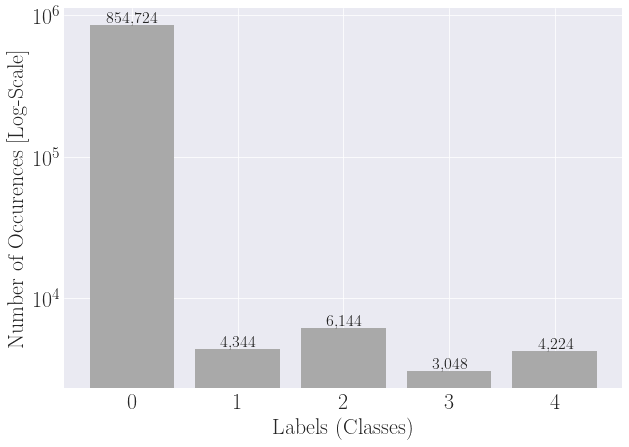

In [104]:
#Set Style
sns.set_style('darkgrid')

#Define the size of the plot
plt.rcParams['figure.figsize'] = (10, 7)

#Adjusting the Writing size
plt.rcParams.update({'font.size': 22})

#Adjusting the Fonts to be able to use Latex, Note: Latex must be installed for this to work
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

#Create the Plot
fig, ax = plt.subplots()

#Create the Histogram in the Plot
ax.bar([0, 2, 1, 4, 3], final_labeled_df.failure.value_counts(), log = True, color = 'darkgray')

#Add Axis titles
plt.ylabel('Number of Occurences [Log-Scale]') # ,fontsize = 18
plt.xlabel('Labels (Classes)')

#Adding writing to the axes
ax.text(-0.25, 890000, '854,724', fontsize = 16)
ax.text(0.83, 4500, '4,344', fontsize = 16)
ax.text(1.84, 6400, '6,144', fontsize = 16)
ax.text(2.84, 3150, '3,048', fontsize = 16)
ax.text(3.84, 4400, '4,224', fontsize = 16)

plt.savefig('Label_Distribution_Over_All_Timestamps.png', dpi = 200, bbox_inches = 'tight', format = 'png')

plt.show()

#Reset to No Latex
plt.rc('text', usetex = False)

#### Labeled Dataframe for ANN
[[Back to the top]](#Overview)

In the following, we construct the equivalent of the final_labeled_df, but for artificial neural network (ANN) architectures. This mainly implies excluding the columns created by the feature engineering.

In [105]:
#First selecting the columns that we can reuse from the final_labeled_df
final_labeled_ann_df = final_labeled_df[['datetime', 'machineID',
                             'volt', 'rotate', 'pressure', 'vibration',
                             'model', 'age', 'failure']].copy()

#Getting the errors
final_labeled_ann_df = final_labeled_ann_df.merge(error_count_df, on = ['datetime', 'machineID'], 
                                                    how = 'left').fillna(0)

#Reordering and Renaming some of the columns for better comprehension
final_labeled_ann_df = final_labeled_ann_df[['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
                     'error1_sum', 'error2_sum', 'error3_sum', 'error4_sum', 'error5_sum',
                     'model', 'age', 'failure']]

final_labeled_ann_df.columns = ['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
                     'error1', 'error2', 'error3', 'error4', 'error5',
                     'model', 'age', 'failure']

final_labeled_ann_df.tail()

datetime  machineID        volt      rotate    pressure  \
872479 2016-01-01 02:00:00        100  179.438162  395.222827  102.290715   
872480 2016-01-01 03:00:00        100  189.617555  446.207972   98.180607   
872481 2016-01-01 04:00:00        100  192.483414  447.816524   94.132837   
872482 2016-01-01 05:00:00        100  165.475310  413.771670  104.081073   
872483 2016-01-01 06:00:00        100  171.336037  496.096870   79.095538   

        vibration  error1  error2  error3  error4  error5  model  age  failure  
872479  50.771941     0.0     0.0     0.0     0.0     0.0      4    5        0  
872480  35.123072     0.0     0.0     0.0     0.0     0.0      4    5        0  
872481  48.314561     0.0     0.0     0.0     0.0     0.0      4    5        0  
872482  44.835259     0.0     0.0     0.0     0.0     0.0      4    5        0  
872483  37.845245     0.0     0.0     0.0     0.0     0.0      4    5        0

As we can see in the dataframe above, we have all the telemetry data, the errors for each time point as a binary coding, the maintenance also as a binary coding, machine model and age and finally the multiclass label column.

### Training and Test Sets
[[Back to the top]](#Overview)

When working with time-series data, such as telemetry and errors, splitting the data into training and test sets should be performed carefully to prevent overestimating the performance of the models. We should remember that we generated some features with lagging aggregates (the largest lagging windows being the 24h mean and std ones), so basicallly we should not use any data point for the test set, that somehow lags into the training set, as similar feature values could occur and the model would get an unfair advantage (when predicting on a test set record that shares its time window with a training set record). 

Due to the time-ordered nature of this type of data, validation and testing based on random sampling is not a viable approach here, cross validation methods that rely on random samples such as k-fold cross validation are not useful either. So when training predictive models in time-series related problems we mainly have two options. The first one is that we train on historical data and test on future data (e.g. train on first 9 months, test on next 3 months). The second option is that we have machineID's like in our case and we basically train a model on a certain amount of machines and validate on the other ones (e.g. train on first 75 machines and test on the next 25 machines). In this situation, we will choose the second option (machineID based split), as it offers greater benefits in terms of training consistently over the whole time period, avoiding the risk that we could miss any time dependent factors in our training set.

To construct a train and test set, we thus follow a machineID-based spliting strategy. This means that <b>we split the data into two parts: machineID 1 to 75 for training and machineID 76 to 100 for testing</b>. With this strategy we can also <b>prevent the leaking problem at the splitting point</b> explained earlier. This approach corresponds to a 75/25 split, which means that we will use 75% of the data to train the model and 25% of the data to test the model. 
<br><b>Limitation:</b> Further splits, such as 60/40 and 80/20, could be explored or tested.

As we have two different dataframes now (one especially for ANNs and one for all other methods), we also need to create separate test and training sets based on these two dataframes. This is achieved in the following.

#### Non-Normalized
[[Back to the top]](#Overview)

In [106]:
#Defining the train/test split for our data, in this machineID 75 will be the splitting point
train_test_split_machineID = 75

In [107]:
train_df = final_labeled_df[final_labeled_df['machineID'] <= train_test_split_machineID]
train_df.tail()

datetime  machineID        volt      rotate    pressure  \
654364 2016-01-01 02:00:00         75  179.432434  380.509455   87.674152   
654365 2016-01-01 03:00:00         75  220.224217  461.107698   86.772168   
654366 2016-01-01 04:00:00         75  200.240847  474.000832  108.530850   
654367 2016-01-01 05:00:00         75  212.162933  441.982142  104.816933   
654368 2016-01-01 06:00:00         75  194.304346  506.924586  101.655917   

        vibration  volt_mean_24h  rotate_mean_24h  pressure_mean_24h  \
654364  38.803251     181.430930       424.399511         100.007212   
654365  29.342106     182.827319       425.989703          99.603098   
654366  35.008782     183.902705       428.744313         100.175962   
654367  31.021542     186.523975       429.042725         100.384927   
654368  46.421516     187.437159       430.654893         100.274382   

        vibration_mean_24h   ...     pressure_std_24h  vibration_std_24h  \
654364           39.801706   ...             8.508895           5.420815   
654365           39.291404   ...             8.905229           5.807859   
654366           39.576108   ...             9.023058           5.391856   
654367           39.215574   ...             9.071956           5.667259   
654368           39.266140   ...             9.038162           5.728136   

        error1_sum_24h  error2_sum_24h  error3_sum_24h  error4_sum_24h  \
654364             0.0             0.0             0.0             0.0   
654365             0.0             0.0             0.0             0.0   
654366             0.0             0.0             0.0             0.0   
654367             0.0             0.0             0.0             0.0   
654368             0.0             0.0             0.0             0.0   

        error5_sum_24h  model  age  failure  
654364             0.0      3   19        0  
654365             0.0      3   19        0  
654366             0.0      3   19        0  
654367             0.0      3   19        0  
654368             0.0      3   19        0  

[5 rows x 22 columns]

In [108]:
test_df = final_labeled_df[final_labeled_df['machineID'] > train_test_split_machineID]
test_df.reset_index(inplace = True, drop = True)
test_df.head()

datetime  machineID        volt      rotate    pressure  \
0 2015-01-03 04:00:00         76  159.077858  463.268115   99.836651   
1 2015-01-03 05:00:00         76  168.874939  422.430444   90.680505   
2 2015-01-03 06:00:00         76  161.841489  423.787001  108.519650   
3 2015-01-03 07:00:00         76  180.679989  397.144210  109.666342   
4 2015-01-03 08:00:00         76  174.403680  502.389812  112.473193   

   vibration  volt_mean_24h  rotate_mean_24h  pressure_mean_24h  \
0  44.177068     175.946148       437.867975          99.109422   
1  42.960636     176.669220       440.562034          98.798174   
2  44.913357     175.283501       438.809223          99.634476   
3  43.701090     175.607685       437.265839         100.141980   
4  39.961410     174.684470       439.194517         100.064502   

   vibration_mean_24h   ...     pressure_std_24h  vibration_std_24h  \
0           41.889142   ...            10.680956           4.100460   
1           41.690672   ...            10.818075           3.916935   
2           41.645535   ...            10.758840           3.871132   
3           42.054792   ...            10.938867           3.517384   
4           42.193895   ...            10.840127           3.355517   

   error1_sum_24h  error2_sum_24h  error3_sum_24h  error4_sum_24h  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   error5_sum_24h  model  age  failure  
0             0.0      2   10        0  
1             0.0      2   10        0  
2             0.0      2   10        0  
3             0.0      2   10        0  
4             0.0      2   10        0  

[5 rows x 22 columns]

#### Normalized with FE
[[Back to the top]](#Overview)

The neural network may have difficulty converging before the maximum number of iterations allowed if the data is not normalized. The Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data. We thus have to normalize the previously created final_labeled_ann_df. To do so, we use the MinMax scaler from sklearn. We first create the train_df_ann and construct the scaler on this df, to later apply it to the test_df_ann, in order to prevent the leaking problem explained later on.

In [109]:
#Defining the Training DF
train_df_ann_fe = final_labeled_df.loc[final_labeled_ann_df['machineID'] <= train_test_split_machineID]
train_df_ann_fe.tail()

datetime  machineID        volt      rotate    pressure  \
654364 2016-01-01 02:00:00         75  179.432434  380.509455   87.674152   
654365 2016-01-01 03:00:00         75  220.224217  461.107698   86.772168   
654366 2016-01-01 04:00:00         75  200.240847  474.000832  108.530850   
654367 2016-01-01 05:00:00         75  212.162933  441.982142  104.816933   
654368 2016-01-01 06:00:00         75  194.304346  506.924586  101.655917   

        vibration  volt_mean_24h  rotate_mean_24h  pressure_mean_24h  \
654364  38.803251     181.430930       424.399511         100.007212   
654365  29.342106     182.827319       425.989703          99.603098   
654366  35.008782     183.902705       428.744313         100.175962   
654367  31.021542     186.523975       429.042725         100.384927   
654368  46.421516     187.437159       430.654893         100.274382   

        vibration_mean_24h   ...     pressure_std_24h  vibration_std_24h  \
654364           39.801706   ...             8.508895           5.420815   
654365           39.291404   ...             8.905229           5.807859   
654366           39.576108   ...             9.023058           5.391856   
654367           39.215574   ...             9.071956           5.667259   
654368           39.266140   ...             9.038162           5.728136   

        error1_sum_24h  error2_sum_24h  error3_sum_24h  error4_sum_24h  \
654364             0.0             0.0             0.0             0.0   
654365             0.0             0.0             0.0             0.0   
654366             0.0             0.0             0.0             0.0   
654367             0.0             0.0             0.0             0.0   
654368             0.0             0.0             0.0             0.0   

        error5_sum_24h  model  age  failure  
654364             0.0      3   19        0  
654365             0.0      3   19        0  
654366             0.0      3   19        0  
654367             0.0      3   19        0  
654368             0.0      3   19        0  

[5 rows x 22 columns]

In [110]:
#Importing the Scaler
from sklearn.preprocessing import MinMaxScaler

#Defining the columns to be normalized (and exclude datetime, machineID and failure)
cols_normalize = train_df_ann_fe.columns.difference(['datetime', 'machineID', 'failure'])

#Starting the MinMax scaler and normalizing the columns, while saving to new temporary df
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df_ann_fe[cols_normalize]), 
                             columns = cols_normalize, 
                             index = train_df_ann_fe.index)

#Create new df, where we are joining the non-normalized columns of train_df with the normalized columns of norm_train_df
join_df = train_df_ann_fe[train_df_ann_fe.columns.difference(cols_normalize)].join(norm_train_df)

#Overwriting the train_df and reindexing the columns
train_df_ann_fe = join_df.reindex(columns = train_df_ann_fe.columns)
train_df_ann_fe.head()

datetime  machineID      volt    rotate  pressure  vibration  \
0 2015-01-03 04:00:00          1  0.618598  0.503801  0.331509   0.510843   
1 2015-01-03 05:00:00          1  0.486750  0.630300  0.302039   0.265831   
2 2015-01-03 06:00:00          1  0.508650  0.577670  0.337116   0.607159   
3 2015-01-03 07:00:00          1  0.493562  0.625350  0.394877   0.522601   
4 2015-01-03 08:00:00          1  0.424662  0.773534  0.321059   0.541552   

   volt_mean_24h  rotate_mean_24h  pressure_mean_24h  vibration_mean_24h  \
0       0.233618         0.798039           0.168486            0.158024   
1       0.229083         0.796887           0.167474            0.126963   
2       0.216490         0.799182           0.155644            0.163354   
3       0.219046         0.817148           0.156353            0.182083   
4       0.221475         0.831703           0.161398            0.191435   

    ...     pressure_std_24h  vibration_std_24h  error1_sum_24h  \
0   ...             0.290930           0.336024             0.0   
1   ...             0.292836           0.283100             0.0   
2   ...             0.278744           0.324913             0.0   
3   ...             0.279391           0.343748             0.5   
4   ...             0.267794           0.368844             0.5   

   error2_sum_24h  error3_sum_24h  error4_sum_24h  error5_sum_24h     model  \
0             0.0             0.0             0.0             0.0  0.666667   
1             0.0             0.0             0.0             0.0  0.666667   
2             0.0             0.0             0.0             0.0  0.666667   
3             0.0             0.0             0.0             0.0  0.666667   
4             0.0             0.0             0.0             0.0  0.666667   

   age  failure  
0  0.9        0  
1  0.9        0  
2  0.9        0  
3  0.9        0  
4  0.9        0  

[5 rows x 22 columns]

Now, we prepare the test data, by also normalizing it. To make the experiment fair, the scaling coefficients (min and max) values which were calculated on the training dataset, must now be applied to scale the test dataset. This is to avoid contaminating the experiment with knowledge from the training dataset, which could potentially give the model a small edge (leaking problem).

In [111]:
#Defining the Testing DF
test_df_ann_fe = final_labeled_df.loc[final_labeled_df['machineID'] > train_test_split_machineID]
test_df_ann_fe.head()

datetime  machineID        volt      rotate    pressure  \
654369 2015-01-03 04:00:00         76  159.077858  463.268115   99.836651   
654370 2015-01-03 05:00:00         76  168.874939  422.430444   90.680505   
654371 2015-01-03 06:00:00         76  161.841489  423.787001  108.519650   
654372 2015-01-03 07:00:00         76  180.679989  397.144210  109.666342   
654373 2015-01-03 08:00:00         76  174.403680  502.389812  112.473193   

        vibration  volt_mean_24h  rotate_mean_24h  pressure_mean_24h  \
654369  44.177068     175.946148       437.867975          99.109422   
654370  42.960636     176.669220       440.562034          98.798174   
654371  44.913357     175.283501       438.809223          99.634476   
654372  43.701090     175.607685       437.265839         100.141980   
654373  39.961410     174.684470       439.194517         100.064502   

        vibration_mean_24h   ...     pressure_std_24h  vibration_std_24h  \
654369           41.889142   ...            10.680956           4.100460   
654370           41.690672   ...            10.818075           3.916935   
654371           41.645535   ...            10.758840           3.871132   
654372           42.054792   ...            10.938867           3.517384   
654373           42.193895   ...            10.840127           3.355517   

        error1_sum_24h  error2_sum_24h  error3_sum_24h  error4_sum_24h  \
654369             0.0             0.0             0.0             0.0   
654370             0.0             0.0             0.0             0.0   
654371             0.0             0.0             0.0             0.0   
654372             0.0             0.0             0.0             0.0   
654373             0.0             0.0             0.0             0.0   

        error5_sum_24h  model  age  failure  
654369             0.0      2   10        0  
654370             0.0      2   10        0  
654371             0.0      2   10        0  
654372             0.0      2   10        0  
654373             0.0      2   10        0  

[5 rows x 22 columns]

In [112]:
#Column normalization with the same min_max_scaler as we used before
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df_ann_fe[cols_normalize]), 
                            columns = cols_normalize, 
                            index = test_df_ann_fe.index)

#Create new df, where we are joining the non-normalized columns of test_df with the normalized columns of norm_test_df
test_join_df = test_df_ann_fe[test_df_ann_fe.columns.difference(cols_normalize)].join(norm_test_df)

#Overwriting the test_df_fe, reindexing the columns in the previous order and resetting the index
test_df_ann_fe = test_join_df.reindex(columns = test_df_ann_fe.columns)
test_df_ann_fe = test_df_ann_fe.reset_index(drop = True)
test_df_ann_fe.head()

datetime  machineID      volt    rotate  pressure  vibration  \
0 2015-01-03 04:00:00         76  0.391304  0.583619  0.360759   0.461534   
1 2015-01-03 05:00:00         76  0.453393  0.510248  0.292792   0.441451   
2 2015-01-03 06:00:00         76  0.408818  0.512685  0.425213   0.473691   
3 2015-01-03 07:00:00         76  0.528207  0.464817  0.433725   0.453676   
4 2015-01-03 08:00:00         76  0.488431  0.653908  0.454561   0.391933   

   volt_mean_24h  rotate_mean_24h  pressure_mean_24h  vibration_mean_24h  \
0       0.314533         0.727563           0.140540            0.254132   
1       0.325588         0.738969           0.135544            0.246747   
2       0.304403         0.731548           0.148966            0.245067   
3       0.309359         0.725014           0.157111            0.260297   
4       0.295244         0.733179           0.155868            0.265473   

    ...     pressure_std_24h  vibration_std_24h  error1_sum_24h  \
0   ...             0.264361           0.185969             0.0   
1   ...             0.269907           0.168517             0.0   
2   ...             0.267511           0.164161             0.0   
3   ...             0.274793           0.130521             0.0   
4   ...             0.270799           0.115128             0.0   

   error2_sum_24h  error3_sum_24h  error4_sum_24h  error5_sum_24h     model  \
0             0.0             0.0             0.0             0.0  0.333333   
1             0.0             0.0             0.0             0.0  0.333333   
2             0.0             0.0             0.0             0.0  0.333333   
3             0.0             0.0             0.0             0.0  0.333333   
4             0.0             0.0             0.0             0.0  0.333333   

   age  failure  
0  0.5        0  
1  0.5        0  
2  0.5        0  
3  0.5        0  
4  0.5        0  

[5 rows x 22 columns]

#### Normalized without FE
[[Back to the top]](#Overview)

In [113]:
#Defining the Training DF
train_df_ann = final_labeled_ann_df.loc[final_labeled_ann_df['machineID'] <= train_test_split_machineID]
train_df_ann.tail()

datetime  machineID        volt      rotate    pressure  \
654364 2016-01-01 02:00:00         75  179.432434  380.509455   87.674152   
654365 2016-01-01 03:00:00         75  220.224217  461.107698   86.772168   
654366 2016-01-01 04:00:00         75  200.240847  474.000832  108.530850   
654367 2016-01-01 05:00:00         75  212.162933  441.982142  104.816933   
654368 2016-01-01 06:00:00         75  194.304346  506.924586  101.655917   

        vibration  error1  error2  error3  error4  error5  model  age  failure  
654364  38.803251     0.0     0.0     0.0     0.0     0.0      3   19        0  
654365  29.342106     0.0     0.0     0.0     0.0     0.0      3   19        0  
654366  35.008782     0.0     0.0     0.0     0.0     0.0      3   19        0  
654367  31.021542     0.0     0.0     0.0     0.0     0.0      3   19        0  
654368  46.421516     0.0     0.0     0.0     0.0     0.0      3   19        0

In [114]:
#Importing the Scaler
from sklearn.preprocessing import MinMaxScaler

#Defining the columns to be normalized (and exclude datetime, machineID and failure)
cols_normalize = train_df_ann.columns.difference(['datetime', 'machineID', 'failure'])

#Starting the MinMax scaler and normalizing the columns, while saving to new temporary df
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df_ann[cols_normalize]), 
                             columns = cols_normalize, 
                             index = train_df_ann.index)

#Create new df, where we are joining the non-normalized columns of train_df with the normalized columns of norm_train_df
join_df = train_df_ann[train_df_ann.columns.difference(cols_normalize)].join(norm_train_df)

#Overwriting the train_df and reindexing the columns
train_df_ann = join_df.reindex(columns = train_df_ann.columns)
train_df_ann.head()

datetime  machineID      volt    rotate  pressure  vibration  \
0 2015-01-03 04:00:00          1  0.618598  0.503801  0.331509   0.510843   
1 2015-01-03 05:00:00          1  0.486750  0.630300  0.302039   0.265831   
2 2015-01-03 06:00:00          1  0.508650  0.577670  0.337116   0.607159   
3 2015-01-03 07:00:00          1  0.493562  0.625350  0.394877   0.522601   
4 2015-01-03 08:00:00          1  0.424662  0.773534  0.321059   0.541552   

   error1  error2  error3  error4  error5     model  age  failure  
0     0.0     0.0     0.0     0.0     0.0  0.666667  0.9        0  
1     0.0     0.0     0.0     0.0     0.0  0.666667  0.9        0  
2     0.0     0.0     0.0     0.0     0.0  0.666667  0.9        0  
3     1.0     0.0     0.0     0.0     0.0  0.666667  0.9        0  
4     0.0     0.0     0.0     0.0     0.0  0.666667  0.9        0

Now, we prepare the test data, by also normalizing it. To make the experiment fair, the scaling coefficients (min and max) values which were calculated on the training dataset, must now be applied to scale the test dataset. This is to avoid contaminating the experiment with knowledge from the training dataset, which could potentially give the model a small edge (leaking problem).

In [115]:
#Defining the Testing DF
test_df_ann = final_labeled_ann_df.loc[final_labeled_ann_df['machineID'] > train_test_split_machineID]
test_df_ann.head()

datetime  machineID        volt      rotate    pressure  \
654369 2015-01-03 04:00:00         76  159.077858  463.268115   99.836651   
654370 2015-01-03 05:00:00         76  168.874939  422.430444   90.680505   
654371 2015-01-03 06:00:00         76  161.841489  423.787001  108.519650   
654372 2015-01-03 07:00:00         76  180.679989  397.144210  109.666342   
654373 2015-01-03 08:00:00         76  174.403680  502.389812  112.473193   

        vibration  error1  error2  error3  error4  error5  model  age  failure  
654369  44.177068     0.0     0.0     0.0     0.0     0.0      2   10        0  
654370  42.960636     0.0     0.0     0.0     0.0     0.0      2   10        0  
654371  44.913357     0.0     0.0     0.0     0.0     0.0      2   10        0  
654372  43.701090     0.0     0.0     0.0     0.0     0.0      2   10        0  
654373  39.961410     0.0     0.0     0.0     0.0     0.0      2   10        0

In [116]:
#Column normalization with the same min_max_scaler as we used before
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df_ann[cols_normalize]), 
                            columns = cols_normalize, 
                            index = test_df_ann.index)

#Create new df, where we are joining the non-normalized columns of test_df with the normalized columns of norm_test_df
test_join_df = test_df_ann[test_df_ann.columns.difference(cols_normalize)].join(norm_test_df)

#Overwriting the test_df, reindexing the columns in the previous order and resetting the index
test_df_ann = test_join_df.reindex(columns = test_df_ann.columns)
test_df_ann = test_df_ann.reset_index(drop = True)
test_df_ann.head()

datetime  machineID      volt    rotate  pressure  vibration  \
0 2015-01-03 04:00:00         76  0.391304  0.583619  0.360759   0.461534   
1 2015-01-03 05:00:00         76  0.453393  0.510248  0.292792   0.441451   
2 2015-01-03 06:00:00         76  0.408818  0.512685  0.425213   0.473691   
3 2015-01-03 07:00:00         76  0.528207  0.464817  0.433725   0.453676   
4 2015-01-03 08:00:00         76  0.488431  0.653908  0.454561   0.391933   

   error1  error2  error3  error4  error5     model  age  failure  
0     0.0     0.0     0.0     0.0     0.0  0.333333  0.5        0  
1     0.0     0.0     0.0     0.0     0.0  0.333333  0.5        0  
2     0.0     0.0     0.0     0.0     0.0  0.333333  0.5        0  
3     0.0     0.0     0.0     0.0     0.0  0.333333  0.5        0  
4     0.0     0.0     0.0     0.0     0.0  0.333333  0.5        0

<b>In sum we now have the 6 following dataframes as bases for training and testing:</b>
<br>- train_df: Non-Normalized, contains all data (incl. Feature Engineering Features) from the first 75 machineIDs
<br>- test_df: Non-Normalized, contains all data (incl. Feature Engineering Features) from the last 25 machineIDs
<br>- train_df_ann_fe: Normalized, contains all data (incl. Feature Engineering Features) from the first 75 machineIDs
<br>- test_df_ann_fe: Normalized, contains all data (incl. Feature Engineering Features) from the last 25 machineIDs
<br>- train_df_ann: Normalized, contains all data (excl. Feature Engineering Features) from the first 75 machineIDs
<br>- test_df_ann: Normalized, contains all data (excl. Feature Engineering Features) from the last 25 machineIDs

##### Sequence Generation for LSTM
[[Back to the top]](#Overview)

Compared to all other previously used models, the LSTM operates on temporal data. This data must be put together in a special form. In our example, in the train_df_ann, we have 15 features that we want to train our LSTM upon. One of the first steps is to choose how long the sequences should be that the LSTM should take into account. Our dataset is on an hourly basis, so we have 24 datapoints per day and machine. If we e.g. choose a sequence length of 24, then we will basically construct a "chain" of the hourly datapoints all linked together for the past 24h. This means that the LSTM looks not only at 15 features in one specific hour, but it looks at 15*24 = 360 features simultaneously. By taking into account this temporal dimension, we expect the performance of the LSTM to be superior to all other algorithms tested so far. However, on the downside, configuring such an LSTM is more time intensive and the interpretability of sequential data over e.g. 24h is much harder than it is of one time point (for this case looking at 15 vs. 360 variables which influence the behaviour and predictions of our LSTM). In the following we proceed with preparing the data for the LSTM and performing the above-described transformations from single time point data into sequential data.

In [117]:
#Defining a window of size 24 / 120
sequence_length = 24 #This Machine is unfortunately not able to e.g. use a 240 day window... MemoryError!

We will be using Keras, which is a wrapper class that allows for an easy LSTM implementation on top of the Tensorflow backend. Regarding the architecture, the Keras LSTM expects an input in the shape of an array of 3 dimensions (samples, time steps, features). Samples is the number of training sequences, time steps is the look back window or previously defined sequence_length and features is the number of features of each sequence at each time step.
To generate the data in this form, we will define a function as we will need to use it multiple times.

There are two steps to generate the arrays in the above-mentioned format. In the following we perform the first step, whcih is to generate the array of the sequence data, i.e. the data that should be learned (without the labels).

In [118]:
#Picking the relevant feature columns and saving them as sequence_cols 
sequence_cols = ['volt', 'rotate', 'pressure', 'vibration',
       'error1', 'error2', 'error3', 'error4', 'error5',
       'model', 'age']

In [119]:
#Function definition to reshape the data into (samples, time steps, features) 
def gen_sequence(machineID_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means that for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    
    #Saving all values from the feature columns in an array
    data_array = machineID_df[seq_cols].values
    
    #Saving the length of the array in a variable (number of rows / objects)
    num_elements = data_array.shape[0]
    
    #Defining the iteration range on the iterable and returning the generator for the data_array
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [120]:
#Sequence generator, generates separate sequenes for each machineID, with length sequence_length
seq_gen = (list(gen_sequence(train_df_ann[train_df_ann['machineID'] == id], sequence_length, sequence_cols)) #Fct. call
           for id in train_df_ann['machineID'].unique())

In [121]:
#Generate sequences and convert to numpy array
lstm_seq_array_X_train = np.concatenate(list(seq_gen)).astype(np.float32)
lstm_seq_array_X_train.shape

(652569, 24, 11)

As we can see above, the training data is now in the correct 3D-Array format. We have 652,569 sequences, all with a length of 24 (hours = seq_length) and 15 features for each of the 24h.

Here starts the second step: creation of the label array, which has the same length as the sequence array, as there is one label for each row.

In [122]:
#Function for the label generation
def gen_labels(machineID_df, seq_length, label):
    data_array = machineID_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [123]:
#Generation of labels
label_gen = [gen_labels(train_df_ann[train_df_ann['machineID'] == id], sequence_length, ['failure']) 
             for id in train_df_ann['machineID'].unique()]
lstm_seq_array_y_train = np.concatenate(label_gen).astype(np.float32)
lstm_seq_array_y_train.shape

(652569, 1)

Perfect, as we can see, the label_array has the same length as the sequence array. As quick sanity check, we analyse the amount of labels contained in the label_array in the following.

In [124]:
unique, counts = np.unique(lstm_seq_array_y_train, return_counts = True)
dict(zip(unique, counts))

{0.0: 639744, 1.0: 3264, 2.0: 4515, 3.0: 1899, 4.0: 3147}

Perfect, we converted the training data into the LSTM format and created the necessary 3D array. In what follows, we have to create the same for the testing data and finally set up the architecture of the LSTM, which we do in the corresponding LSTM Modeling section.

In [125]:
#Sequence generation for each machineID, with length sequence_length on the test_df
lstm_seq_array_X_test = (list(gen_sequence(test_df_ann[test_df_ann['machineID'] == id], sequence_length, sequence_cols))
           for id in test_df_ann['machineID'].unique())

In [126]:
#Generate sequences and convert to numpy array
lstm_seq_array_X_test = np.concatenate(list(lstm_seq_array_X_test)).astype(np.float32)
lstm_seq_array_X_test.shape

(217515, 24, 11)

In [127]:
#Generation of labels for the test_df
label_gen_test = [gen_labels(test_df_ann[test_df_ann['machineID'] == id], sequence_length, ['failure']) 
             for id in test_df_ann['machineID'].unique()]
lstm_seq_array_y_test = np.concatenate(label_gen_test).astype(np.float32)
lstm_seq_array_y_test.shape

(217515, 1)

In [128]:
unique, counts = np.unique(lstm_seq_array_y_test, return_counts = True)
dict(zip(unique, counts))

{0.0: 212643, 1.0: 1080, 2.0: 1608, 3.0: 1128, 4.0: 1056}

## Modeling
[[Back to the top]](#Overview)

<i><b>CRISP-DM:</b> "In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques have specific requirements on the form of data. Therefore, stepping back to the data preparation phase is often needed." [Source: Wiki]</i>

After the data preprocessing part, we can finally start to apply different modeling techniques. It should be noted that <b>feature engineering is mainly required to boost the performance of standard methods</b>, such as decision trees and regressions. The <b>beauty of deep learning frameworks, such as a LSTM network, is that it will learn its own abstract features, which is why feature engineering becomes obsolete to apply these techniques</b>. On the downside, however, there is a lot more work involved with tuning and finding the correct hyperparameters of the network. In the outlook of the modeling section, we will apply such a model to our dataset, to study differences in the model.

For now, however, we will mainly focus on more standardized machine learning models such as the ones included in the Sci-Kit-Learn ML library. 

In this section of the notebook, the predictive maintenance problem is analysed and framed as a classification experiment. This means that we try to predict the label of the components, which will fail within 24h as previously explained.

### M: Decision Tree
[[Back to the top]](#Overview) || [[To the Decision Tree Evaluation]](#E:-Decision-Tree)

The first model we start with to analyze our data set is a simple decision tree (DT). This model is usually characterized as being simple to interprete and in non-linear datasets usually also leads to a good performance.

In the following we first define the data and then start training the DT.

In [129]:
#Training Data
dt_X_train = train_df.iloc[:,2:-1]
dt_y_train = train_df.iloc[:,-1]

In [130]:
#Testing Data
dt_X_test = test_df.iloc[:,2:-1]
dt_y_test_truth = test_df.iloc[:,-1]

In [131]:
#Importing the Decision Tree from SKLearn
from sklearn import tree

#Building the decision tree model (Also try max_depth = 3 and max_leaf_nodes = 15)
dt_model = tree.DecisionTreeClassifier(
    criterion = 'entropy', #The function to measure the quality of a split
    splitter = 'best', #The strategy used to choose the split at each node
    max_depth = 5, #The maximum depth of the tree
    min_samples_split = 2, #The minimum number of samples required to split an internal node
    min_samples_leaf = 2, #The minimum number of samples required to be at a leaf node
    min_weight_fraction_leaf = 0.0, #The min. weighted fraction of the sum total of weights req. to be at a leaf node
    max_features = None, #The number of features to consider when looking for the best split
    random_state = 777, #If int, random_state is the seed used by the random number generator
    max_leaf_nodes = 10, #Grow a tree with max_leaf_nodes in best-first fashion
    min_impurity_decrease = 0.0, #Node will be split if the split decreases the impurity more or equal to this value
    class_weight = None, #Weights associated with classes, if not given, all classes are supposed to have weight one
    presort = False #Whether to presort the data to speed up the finding of best splits in fitting
    )

#Fitting the decision tree model
#dt_model.fit(dt_X_train, dt_y_train) #Unconment to retrain model

In [132]:
#Exporting and saving / importing trained model to avoid learning multople times...
import pickle
dt_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\dt_model.sav'
#pickle.dump(dt_model, open(dt_fname, 'wb')) #Unconment to overwrite existing saved model

In [133]:
#Reload the model...
loaded_dt_model = pickle.load(open(dt_fname, 'rb'))

In [134]:
#Predict on the dt_X_test, using the built model from above
dt_y_test_predicted = loaded_dt_model.predict(dt_X_test) #Prediction based on the saved and reloaded model
dt_y_test_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [135]:
#Printing the Model Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(dt_y_test_truth, dt_y_test_predicted)

0.9957957957957958

### M: Random Forest
[[Back to the top]](#Overview) || [[To the Random Forest Evaluation]](#E:-Random-Forest)

As a next classifier model, we will use a random forest (RF), which is an ensemble learning method. The RF is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In the following we first define the data and then start training the RF.

In [136]:
#Training Data
rf_X_train = train_df.iloc[:,2:-1]
rf_y_train = train_df.iloc[:,-1]

In [137]:
#Testing Data
rf_X_test = test_df.iloc[:,2:-1]
rf_y_test_truth = test_df.iloc[:,-1]

In [138]:
#Importing the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#Building the random forest model
rf_model = RandomForestClassifier(
    n_estimators = 50, #The number of trees in the forest (there are 44 features...)
    criterion = 'entropy', #The function to measure the quality of a split
    max_depth = 3, #The maximum depth of the tree
    min_samples_split = 2, #The minimum number of samples required to split an internal node
    min_samples_leaf = 2, #The minimum number of samples required to be at a leaf node
    min_weight_fraction_leaf = 0.0, #The min. weighted fraction of the sum total of weights req. to be at a leaf node
    max_features = None, #The number of features to consider when looking for the best split
    max_leaf_nodes = 5, #Grow a tree with max_leaf_nodes in best-first fashion
    min_impurity_decrease = 0.0, #Node will be split if the split decreases the impurity more or equal to this value
    bootstrap = False, #Whether bootstrap samples are used when building trees
    oob_score = False, #Whether to use out-of-bag samples to estimate the generalization accuracy
    n_jobs = -1, #The number of jobs to run in parallel for fit and predict (If -1, #jobs = #number of cores)
    random_state = 777, #If int, random_state is the seed used by the random number generator
    verbose = 1, #Controls the verbosity of the tree building process
    warm_start = False, #When True reuses the sol. of the prev. call to fit and add more estimators to the ensemble
    class_weight = None #Weights associated with classes, if not given, all classes are supposed to have weight one
    )

#Fitting the random forest model
#rf_model.fit(rf_X_train, rf_y_train) #Unconment to retrain model

In [139]:
#Exporting and saving / importing trained model to avoid learning multople times...
import pickle
rf_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\rf_model.sav'
#pickle.dump(rf_model, open(rf_fname, 'wb')) #Unconment to overwrite existing saved model

In [140]:
#Reload the model...
loaded_rf_model = pickle.load(open(rf_fname, 'rb'))

In [141]:
#Predict on the rf_X_test, using the built model from above
rf_y_test_predicted = loaded_dt_model.predict(rf_X_test) #Prediction based on the saved and reloaded model
rf_y_test_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [142]:
#Printing the Model Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(rf_y_test_truth, rf_y_test_predicted)

0.9957957957957958

### M: Gradient Boosted Trees
[[Back to the top]](#Overview) || [[To the Gradient Boosted Trees Evaluation]](#E:-Gradient-Boosted-Trees)

As a next classifier model, we will use gradient boosted trees (XGB), which is similar to the random forest model.
When it comes to explaining the differences between RF and XGB, we can first establish that both are ensemble models, and both leverage decision trees as their base estimator.

However, a Random Forest uses ensembling in its more intuitive fashion, essentially using the principle of “wisdom of the crowds”. A RF will build N decision trees and then average the predictions democratically. Each tree counts for one vote. Each tree uses a different sample from the original data thus introducing randomization. Thus, <b>a RF is a low-bias-high-variance model, which aims to decrease variance instead of bias (it uses Bagging - Bootstrapped Aggregating for sampling)</b>.

Gradient Boosting takes a different approach. It starts with a (usually) not very deep tree (sometimes a decision stump - a decision tree with only one split) and will model the original target. Then it takes the errors from the first round of predictions, and passes the errors as a new target to a second tree. The second tree will model the error from the first tree, record the new errors and pass that as a target to the third tree, and so forth. Essentially it focuses on modelling errors from previous trees. Thus, <b>a XGB is a low-variance-high-bias model, which aims to decrease bias instead of variance (it uses Boosting for sampling)</b>.

Notice that RF runs trees in parallel, thus making it possible to parallelize jobs on a multiprocessor machine. XGB instead uses a sequential approach thus only using one core.

Source: https://www.quora.com/What-are-the-differences-between-Random-Forest-and-Gradient-Tree-Boosting-algorithms

In the following we first define the data and then start training the XGB.

In [143]:
#Training Data
xgb_X_train = train_df.iloc[:,2:-1]
xgb_y_train = train_df.iloc[:,-1]

In [144]:
#Testing Data
xgb_X_test = test_df.iloc[:,2:-1]
xgb_y_test_truth = test_df.iloc[:,-1]

In [145]:
#Importing the Gradient Boosted Trees Classifier
from sklearn.ensemble import GradientBoostingClassifier

#Building the XGB model
xgb_model = GradientBoostingClassifier(
    loss = 'deviance', #loss fnct. to be optimized: 'deviance' refers to logRegr with probabilistic outputs
    learning_rate = 0.1, #learning rate shrinks the contribution of each tree by learning_rate
    n_estimators = 100, #The #boosting stages to perform (XGB is fairly robust so a large # usually yields better perf.)
    subsample = 1.0, #The fraction of samples to be used for fitting the individual base learners
    criterion = 'friedman_mse', #The function to measure the quality of a split (use 'mae' for mean absolute error)
    min_samples_split = 2, #The minimum number of samples required to split an internal node
    min_samples_leaf = 1, #The minimum number of samples required to be at a leaf node
    min_weight_fraction_leaf = 0.0, #The min. weighted fraction of the sum total of weights req. to be at a leaf node
    max_depth = 3, #Maximum depth of the individual regression estimators
    min_impurity_decrease = 0.0, #Node will be split if the split decreases the impurity more or equal to this value
    min_impurity_split = None, #A node will split if its impurity is above the threshold, otherwise it is a leaf
    init = None, #An estimator object that is used to compute the initial predictions
    random_state = 777, #If int, random_state is the seed used by the random number generator
    max_features = None, #The number of features to consider when looking for the best split
    verbose = 1, #Enable verbose output (If 1 then it prints progress and performance once in a while)
    max_leaf_nodes = 5, #Grow a tree with max_leaf_nodes in best-first fashion
    warm_start = False, #When True, reuses solution of the previous call to fit and add more estim. to the ensemble
    presort = False #Whether to presort the data to speed up the finding of best splits in fitting
    )

#Fitting the XGB model
#xgb_model.fit(xgb_X_train, xgb_y_train) #Unconment to retrain model

In [146]:
#Exporting and saving / importing trained model to avoid learning multople times...
import pickle
xgb_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\xgb_model.sav'
#pickle.dump(xgb_model, open(xgb_fname, 'wb')) #Unconment to overwrite existing saved model

In [147]:
#Reload the model...
loaded_xgb_model = pickle.load(open(xgb_fname, 'rb'))

In [148]:
#Predict on the xgb_X_test, using the built model from above
xgb_y_test_predicted = loaded_xgb_model.predict(xgb_X_test) #Prediction based on the saved and reloaded model
xgb_y_test_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [149]:
#Printing the Model Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(xgb_y_test_truth, xgb_y_test_predicted)

0.9959929395043899

### M: Support Vector Machine
[[Back to the top]](#Overview) || [[To the Support Vector Machine Evaluation]](#E:-Support-Vector-Machine)

So far we have looked at three different models to predict the failure of machine components, namely DT, RF and XGB. All of these are tree-bases algorithms. In the following, we will use a support vector machine (SVM), which is an algorithm, that does not rely on a tree structure and approaches the prediction problem in a different manner.

A SVM is a linear separator, which uses a Kernel to separate the data when it is not directly linearly separable. In this case, the SVM projects the data into a space where it can separate it. This is one of its greatest strengths and weaknesses at the same time: by being able to project data into a high dimensional space, the SVM can find a linear separation for almost any data, however, at the same time it needs to use a Kernel, which is already a difficult selection problem in itself (which Kernel to use) and we could also argue that there is not a perfect kernel for every dataset. 

Note that the implementation of the SVM (SVC) below is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples. Thus, we will use a linear kernel SVM function to speed up the training process, rather than using a RBF kernel, which is a non-linear kernel often used in practice.

Sources:
<br>http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
<br>https://www.quora.com/Why-does-XGBoost-perform-better-than-SVM
<br>https://www.quora.com/What-is-an-intuitive-explanation-for-RBF-kernels

In [150]:
#Training Data
svm_X_train = train_df.iloc[:,2:-1]
svm_y_train = train_df.iloc[:,-1]

In [151]:
#Testing Data
svm_X_test = test_df.iloc[:,2:-1]
svm_y_test_truth = test_df.iloc[:,-1]

In [152]:
#Importing the Support Vector Machine Classifier
from sklearn.svm import LinearSVC

#Building the SVM model
svm_model = LinearSVC(
    penalty = 'l2', #Specifies the norm used in the penalization
    loss = 'squared_hinge', #Specifies the loss function
    dual = True, #Select the algorithm to either solve the dual or primal optimization problem
    tol = 0.0001, #Tolerance for stopping criteria
    C = 1.0, #Penalty parameter C of the error term
    multi_class = 'ovr', #Determines the multi-class strategy if y contains more than two classes (one-vs-rest)
    fit_intercept = True, #Whether to calculate the intercept for this model (data is uncentered, intercept is a must)
    intercept_scaling = 1, #When True instance vector x becomes a “synthetic” feature with constant value
    class_weight = None, #Weights associated with classes, if not given, all classes are supposed to have weight one
    verbose = 1, #Controls the verbosity of the tree building process
    random_state = 777, #If int, random_state is the seed used by the random number generator
    max_iter = 1000 #The maximum number of iterations to be run
    )

#Fitting the SVM model
#svm_model.fit(svm_X_train, svm_y_train) #Unconment to retrain model

In [153]:
#Exporting and saving / importing trained model to avoid learning multople times...
import pickle
svm_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\svm_model.sav'
#pickle.dump(svm_model, open(svm_fname, 'wb')) #Unconment to overwrite existing saved model

In [154]:
#Reload the model...
loaded_svm_model = pickle.load(open(svm_fname, 'rb'))

In [155]:
#Predict on the svm_X_test, using the built model from above
svm_y_test_predicted = loaded_svm_model.predict(svm_X_test) #Prediction based on the saved and reloaded model
svm_y_test_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [156]:
#Printing the Model Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(svm_y_test_truth, svm_y_test_predicted)

0.9889737065309584

### M: Gaussian Naive Bayes
[[Back to the top]](#Overview) || [[To the Gaussian Naive Bayes Evaluation]](#E:-Gaussian-Naive-Bayes)

The (Gaussian) Naive Bayes (GNB) is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. For example, a fruit may be considered to be an apple if it is red, round, and about 3 inches in diameter. Even if these features depend on each other or upon the existence of the other features, all of these properties independently contribute to the probability that this fruit is an apple and that is why it is known as ‘Naive’.

Naive Bayes model is easy to build and particularly useful for very large data sets. Along with simplicity, Naive Bayes is known to outperform even highly sophisticated classification methods.

Source: https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

In [157]:
#Training Data
gnb_X_train = train_df.iloc[:,2:-1]
gnb_y_train = train_df.iloc[:,-1]

In [158]:
#Testing Data
gnb_X_test = test_df.iloc[:,2:-1]
gnb_y_test_truth = test_df.iloc[:,-1]

Before we apply the GNB algorithm, it makes sense to check if our predictors are actually independent. We can achieve this by computing a correlation table between our predictors. If our predictors are linearly correlated, it means that they are not independent. That would mean that the independency condition of the theorem would not be satisfied and thus the GNB model should not be applied. We will relax this condition to the following: If the correlations are close to zero, then we will still apply the GNB algorithm.

In [159]:
#Compute the correlation table
gnb_X_train.corr().head()

volt    rotate  pressure  vibration  volt_mean_24h  \
volt           1.000000 -0.001952  0.002140   0.001535       0.290784   
rotate        -0.001952  1.000000 -0.001442  -0.002675      -0.001773   
pressure       0.002140 -0.001442  1.000000   0.001976       0.002824   
vibration      0.001535 -0.002675  0.001976   1.000000      -0.001204   
volt_mean_24h  0.290784 -0.001773  0.002824  -0.001204       1.000000   

               rotate_mean_24h  pressure_mean_24h  vibration_mean_24h  \
volt                 -0.002438           0.002283            0.001164   
rotate                0.323240          -0.003311           -0.003973   
pressure             -0.003531           0.400314            0.000376   
vibration            -0.005272           0.001189            0.360567   
volt_mean_24h        -0.005775           0.007429           -0.000239   

               volt_std_24h  rotate_std_24h  pressure_std_24h  \
volt               0.024022       -0.000193         -0.000295   
rotate             0.002510       -0.045124         -0.000478   
pressure          -0.000571        0.001791          0.099250   
vibration         -0.002349       -0.001819         -0.003972   
volt_mean_24h      0.077016       -0.005912          0.001036   

               vibration_std_24h  error1_sum_24h  error2_sum_24h  \
volt                   -0.001777        0.043080        0.000693   
rotate                  0.000727       -0.011947       -0.067337   
pressure                0.004777        0.005663        0.004384   
vibration               0.062841        0.005953        0.003767   
volt_mean_24h          -0.005773        0.140363        0.001401   

               error3_sum_24h  error4_sum_24h  error5_sum_24h     model  \
volt                 0.004071        0.001877        0.002105  0.000112   
rotate              -0.073400       -0.002843       -0.012266  0.001241   
pressure             0.008337        0.050097        0.003193 -0.021618   
vibration            0.007291       -0.000132        0.098507 -0.007220   
volt_mean_24h        0.009133        0.005909        0.005219  0.000372   

                    age  
volt          -0.001155  
rotate        -0.001797  
pressure       0.004480  
vibration      0.018561  
volt_mean_24h -0.003852

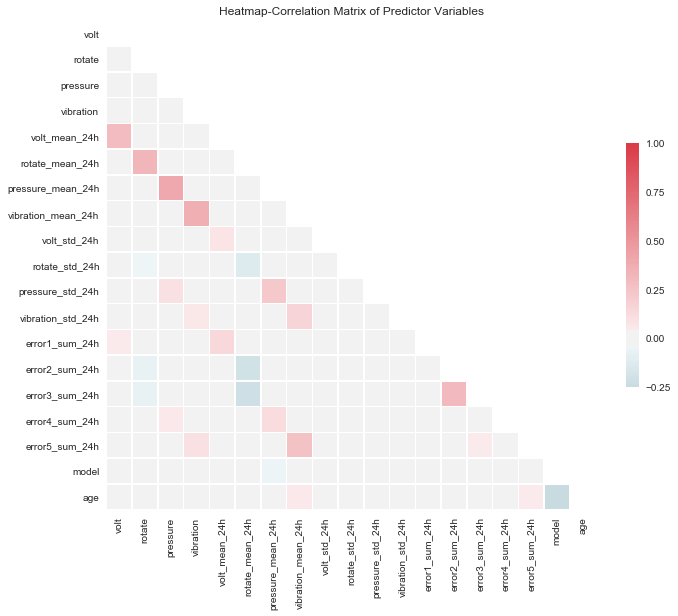

In [160]:
#Computing the visualization of the Correlation Matrix
from string import ascii_letters
import seaborn as sns

sns.set(style = "white")

# Compute the correlation matrix
corr = gnb_X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)
plt.title('Heatmap-Correlation Matrix of Predictor Variables')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})


As we can see in the visualization above, the different lags strongly correlate with each other (e.g. volt with volt_mean_3h with volt_mean_12h and volt_mean_24h). However, the predictors themselves are mostly uncorrelated. We will thus proceed accordingly with the application of the GNB algorithm.

In [161]:
#Importing the Gaussian Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

#Building the GNB model
gnb_model = GaussianNB(
    priors = None #Prior probabilities of the classes (if specified the priors are not adjusted according to the data)
    )

#Fitting the GNB model
#gnb_model.fit(gnb_X_train, gnb_y_train) #Unconment to retrain model

In [162]:
#Exporting and saving / importing trained model to avoid learning multople times...
import pickle
gnb_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\gnb_model.sav'
#pickle.dump(gnb_model, open(gnb_fname, 'wb')) #Unconment to overwrite existing saved model

In [163]:
#Reload the model...
loaded_gnb_model = pickle.load(open(gnb_fname, 'rb'))

In [164]:
#Predict on the gnb_X_test, using the built model from above
gnb_y_test_predicted = loaded_gnb_model.predict(gnb_X_test) #Prediction based on the saved and reloaded model
gnb_y_test_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [165]:
#Printing the Model Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(gnb_y_test_truth, gnb_y_test_predicted)

0.9500859638264219

### M: K-Nearest Neighbors
[[Back to the top]](#Overview) || [[To the K-Nearest Neighbors Evaluation]](#E:-K-Nearest-Neighbors)

The K-Nearest Neighbors (KNN) algorithm is a robust and versatile classifier that is often used as a benchmark for more complex classifiers such as Artificial Neural Networks (ANN) and Support Vector Machines (SVM). Despite its simplicity, KNN can outperform more powerful classifiers and is used in a variety of applications such as economic forecasting, data compression and genetics. The KNN classifier is also a non parametric and instance-based learning algorithm.

Source: https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

In [166]:
#Training Data
knn_X_train = train_df.iloc[:,2:-1]
knn_y_train = train_df.iloc[:,-1]

In [167]:
#Testing Data
knn_X_test = test_df.iloc[:,2:-1]
knn_y_test_truth = test_df.iloc[:,-1]

This model is peculiar in one thing: It uses the training set more as a lookup-table, which is why fitting the model is a very short task. The long waiting times really come with predicting the classes of the data in the test-set, where all the distances must be calculated. For this algorithm thus we first build the model, however do not export it and predict on the test set right away. As this task takes a long time, we export the results to a file and import them to save time in future notebook runs.

In [168]:
#Importing the K-Nearest Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier

#Building the KNN model
knn_model = KNeighborsClassifier(
    n_neighbors = 5, #Number of neighbors to use by default for kneighbors queries
    weights = 'uniform', #Weight function used in prediction
    algorithm = 'auto', #Algorithm used to compute the nearest neighbors
    leaf_size = 30, #Leaf size passed to BallTree or KDTree (if those algorithms are selected)
    p = 2, #Power parameter for the Minkowski metric (2 means Euclidean, 1 would mean Manhattan)
    metric = 'minkowski', #The distance metric to use for the tree
    metric_params = None, #Additional keyword arguments for the metric function
    n_jobs = -1 #The number of jobs to run in parallel for fit and predict (If -1, #jobs = #number of cores)
    )

#Fitting the KNN model
#knn_model.fit(knn_X_train, knn_y_train) #Unconment to retrain model

In [169]:
#Predict on the knn_X_test, using the built model from above
#knn_y_test_predicted = knn_model.predict(knn_X_test) #Uncomment to repredict the whole test-set

In [170]:
#Exporting and saving / importing results of learning, to avoid waiting times of testing...
import pickle
knn_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\knn_results.sav'
#pickle.dump(knn_y_test_predicted, open(knn_fname, 'wb')) #Unconment to overwrite existing data

In [171]:
#Reload the model...
loaded_knn_y_test_predicted = pickle.load(open(knn_fname, 'rb'))

In [172]:
#Printing the Model Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(knn_y_test_truth, loaded_knn_y_test_predicted)

0.9760447470371134

### M: Logistic Regression
[[Back to the top]](#Overview) || [[To the Logistic Regression Evaluation]](#E:-Logistic-Regression)

The Logistic Regression (LR) aka logit, MaxEnt classifier is a linear classifier, which does not try to predict the value of a numeric variable given a set of inputs. Instead, the output is a probability that the given input point belongs to a certain class. We can use the LR in our multiclass scenario by using a softmax function.

In [173]:
#Training Data
lr_X_train = train_df.iloc[:,2:-1]
lr_y_train = train_df.iloc[:,-1]

In [174]:
#Testing Data
lr_X_test = test_df.iloc[:,2:-1]
lr_y_test_truth = test_df.iloc[:,-1]

In [175]:
#Importing the Support Vector Machine Classifier
from sklearn.linear_model import LogisticRegression

#Building the LR model
lr_model = LogisticRegression(
    penalty = 'l2', #Used to specify the norm used in the penalization
    dual = False, #Dual or primal formulation
    tol = 0.0001, #Tolerance for stopping criteria
    C = 1.0, #Inverse of regularization strength
    fit_intercept = True, #Specifies if a constant (aka bias or intercept) should be added to the decision function
    intercept_scaling = 1, #To lessen the effect of regularization on synthetic feature weight this has to be increased
    class_weight = None, #Weights associated with classes, if not given, all classes are supposed to have weight one
    random_state = 777, # If not given, all classes are supposed to have weight one
    solver = 'liblinear', #Algorithm to use in the optimization problem
    max_iter = 100, #Maximum number of iterations taken for the solvers to converge
    multi_class = 'ovr', #Determines the multi-class strategy if y contains more than two classes (one-vs-rest)
    verbose = 1, #For the liblinear and lbfgs solvers set verbose to any positive number for verbosity
    warm_start = False #When set to True, reuse the solution of the previous call to fit as initialization
    )

#Fitting the LR model
#lr_model.fit(lr_X_train, lr_y_train) #Unconment to retrain model

In [176]:
#Exporting and saving / importing trained model to avoid learning multople times...
import pickle
lr_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\lr_model.sav'
#pickle.dump(lr_model, open(lr_fname, 'wb')) #Unconment to overwrite existing saved model

In [177]:
#Reload the model...
loaded_lr_model = pickle.load(open(lr_fname, 'rb'))

In [178]:
#Predict on the lr_X_test, using the built model from above
lr_y_test_predicted = loaded_lr_model.predict(lr_X_test) #Prediction based on the saved and reloaded model
lr_y_test_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [179]:
#Printing the Model Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(lr_y_test_truth, lr_y_test_predicted)

0.9932604360085276

### M: Multilayer Perceptron with FE
[[Back to the top]](#Overview) || [[To the Multilayer Perceptron Evaluation]](#E:-Multilayer-Perceptron-with-FE)

Multilayer Perceptrons (MLP) or also known as Artificial Neural Networks (ANN) can learn a non-linear function for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. These hidden layers allow the ANN to learn non-linear relationships. In the following we will implement such a MLP with 2 hidden layers, each with 100 and 50 neurons respectively.

In [180]:
#Training Data -> Note that we are using the normalized data for the ANN for training and testing created earlier
mlp_fe_X_train = train_df_ann_fe.iloc[:,2:-1]
mlp_fe_y_train = train_df_ann_fe.iloc[:,-1]

In [181]:
#Testing Data -> Note that we are using the normalized data for the ANN for training and testing created earlier
mlp_fe_X_test = test_df_ann_fe.iloc[:,2:-1]
mlp_fe_y_test_truth = test_df_ann_fe.iloc[:,-1]

In [182]:
#Importing the Multilayer Perceptron Classifier
from sklearn.neural_network import MLPClassifier

#Building the MLP model
mlp_fe_model = MLPClassifier(
    hidden_layer_sizes=(100,50), #The ith element represents the number of neurons in the ith hidden layer
    activation = 'relu', #Activation function for the hidden layer (tanh, relu, identity and logistic possible)
    solver = 'adam', #The solver for weight optimization (adam, sgd and lbfgs possible)
    alpha = 0.0001, #L2 penalty (regularization term) parameter
    batch_size = 'auto', #Size of minibatches for stochastic optimizers
    learning_rate = 'constant', #Learning rate schedule for weight updates (constant, invscaling and adaptive possible)
    learning_rate_init = 0.001, #The initial learning rate used
    power_t = 0.5, #The exponent for inverse scaling learning rate
    max_iter = 200, #Maximum number of iterations - the solver iterates until convergence or this number of iterations
    shuffle = False, #Whether to shuffle samples in each iteration
    random_state = 777, #If int, random_state is the seed used by the random number generator
    tol = 0.0001, #Tolerance for the optimization
    verbose = True, #Whether to print progress messages to stdout
    warm_start = False, #When set to True, reuse the solution of the previous call to fit as initialization
    early_stopping = False, #Whether to use early stopping to terminate training when validation score is not improving
    validation_fraction = 0.1, #The proportion of training data to set aside as validation set for early stopping
    beta_1 = 0.9, #Exponential decay rate for estimates of first moment vector in adam
    beta_2 = 0.999, #Exponential decay rate for estimates of second moment vector in adam
    epsilon = 1e-08 #Value for numerical stability in adam
    )

#Fitting the MLP model
#mlp_fe_model.fit(mlp_fe_X_train, mlp_fe_y_train) #Unconment to retrain model

In [183]:
#Exporting and saving / importing trained model to avoid learning multople times...
import pickle
mlp_fe_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\mlp_fe_model.sav'
#pickle.dump(mlp_fe_model, open(mlp_fe_fname, 'wb')) #Unconment to overwrite existing saved model

In [184]:
#Reload the model...
loaded_mlp_fe_model = pickle.load(open(mlp_fe_fname, 'rb'))

In [185]:
#Predict on the mlp_fe_X_test, using the built model from above
mlp_fe_y_test_predicted = loaded_mlp_fe_model.predict(mlp_fe_X_test) #Prediction based on the saved and reloaded model
mlp_fe_y_test_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [186]:
#Printing the Model Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(mlp_fe_y_test_truth, mlp_fe_y_test_predicted)

0.9960112784540266

### M: Multilayer Perceptron with FE not normalized
[[Back to the top]](#Overview) || [[To the Multilayer Perceptron Evaluation]](#E:-Multilayer-Perceptron-with-FE-not-normalized)

Multilayer Perceptrons (MLP) or also known as Artificial Neural Networks (ANN) can learn a non-linear function for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. These hidden layers allow the ANN to learn non-linear relationships. In the following we will implement such a MLP with 2 hidden layers, each with 100 and 50 neurons respectively. In this special subcase, we will do so, without normalizing the training and testing data beforehand.

In [187]:
#Training Data -> Note that we are using the normalized data for the ANN for training and testing created earlier
mlp_fe_not_norm_X_train = train_df.iloc[:,2:-1]
mlp_fe_not_norm_y_train = train_df.iloc[:,-1]

In [188]:
#Testing Data -> Note that we are using the normalized data for the ANN for training and testing created earlier
mlp_fe_not_norm_X_test = test_df.iloc[:,2:-1]
mlp_fe_not_norm_y_test_truth = test_df.iloc[:,-1]

In [189]:
#Importing the Multilayer Perceptron Classifier
from sklearn.neural_network import MLPClassifier

#Building the MLP model
mlp_fe_not_norm_model = MLPClassifier(
    hidden_layer_sizes=(100,100), #The ith element represents the number of neurons in the ith hidden layer
    activation = 'relu', #Activation function for the hidden layer (tanh, relu, identity and logistic possible)
    solver = 'adam', #The solver for weight optimization (adam, sgd and lbfgs possible)
    alpha = 0.0001, #L2 penalty (regularization term) parameter
    batch_size = 'auto', #Size of minibatches for stochastic optimizers
    learning_rate = 'constant', #Learning rate schedule for weight updates (constant, invscaling and adaptive possible)
    learning_rate_init = 0.001, #The initial learning rate used
    power_t = 0.5, #The exponent for inverse scaling learning rate
    max_iter = 200, #Maximum number of iterations - the solver iterates until convergence or this number of iterations
    shuffle = False, #Whether to shuffle samples in each iteration
    random_state = 777, #If int, random_state is the seed used by the random number generator
    tol = 0.0001, #Tolerance for the optimization
    verbose = True, #Whether to print progress messages to stdout
    warm_start = False, #When set to True, reuse the solution of the previous call to fit as initialization
    early_stopping = False, #Whether to use early stopping to terminate training when validation score is not improving
    validation_fraction = 0.1, #The proportion of training data to set aside as validation set for early stopping
    beta_1 = 0.9, #Exponential decay rate for estimates of first moment vector in adam
    beta_2 = 0.999, #Exponential decay rate for estimates of second moment vector in adam
    epsilon = 1e-08 #Value for numerical stability in adam
    )

#Fitting the MLP model
#mlp_fe_not_norm_model.fit(mlp_fe_not_norm_X_train, mlp_fe_not_norm_y_train) #Unconment to retrain model

In [190]:
#Exporting and saving / importing trained model to avoid learning multople times...
import pickle
mlp_fe_not_norm_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\mlp_fe_not_norm_model.sav'
#pickle.dump(mlp_fe_not_norm_model, open(mlp_fe_not_norm_fname, 'wb')) #Unconment to overwrite existing saved model

In [191]:
#Reload the model...
loaded_mlp_fe_not_norm_model = pickle.load(open(mlp_fe_not_norm_fname, 'rb'))

In [192]:
#Predict on the mlp_fe_X_test, using the built model from above
mlp_fe_not_norm_y_test_predicted = loaded_mlp_fe_not_norm_model.predict(mlp_fe_not_norm_X_test) #Prediction based on the saved and reloaded model
mlp_fe_not_norm_y_test_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [193]:
#Printing the Model Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(mlp_fe_not_norm_y_test_truth, mlp_fe_not_norm_y_test_predicted)

0.9956765926231576

### M: Multilayer Perceptron without FE
[[Back to the top]](#Overview) || [[To the Multilayer Perceptron Evaluation]](#E:-Multilayer-Perceptron-without-FE)

In this scenario, we learn our MLP model on the same training and test data, however, we exclude the FE which we did and used in all earlier algorithms, to see if there is a notable performance difference. As ANNs are theoretically able to define their own abstract features, we expect the performance to not be substantially worse. However, we also know that our data contains a temporal dimension, which we capture with our lagging features from the FE part. As MLPs are not designed to deal with temporal data, it is thus also plausible that the performance of the MLP without the lagging features of the FE is substantially worse compared to the other algorithms, which made use of our FE data.

In [194]:
#Training Data -> Note that we are using the normalized data for the ANN for training and testing created earlier
mlp_X_train = train_df_ann.iloc[:,2:-1]
mlp_y_train = train_df_ann.iloc[:,-1]

In [195]:
#Testing Data -> Note that we are using the normalized data for the ANN for training and testing created earlier
mlp_X_test = test_df_ann.iloc[:,2:-1]
mlp_y_test_truth = test_df_ann.iloc[:,-1]

In [196]:
#Importing the Multilayer Perceptron Classifier
from sklearn.neural_network import MLPClassifier

#Building the MLP model
mlp_model = MLPClassifier( #Try with 360,100,50 Neurons vs. 100,50 neurons
    hidden_layer_sizes=(100,50), #The ith element represents the number of neurons in the ith hidden layer
    activation = 'relu', #Activation function for the hidden layer (tanh, relu, identity and logistic possible)
    solver = 'adam', #The solver for weight optimization (adam, sgd and lbfgs possible)
    alpha = 0.0001, #L2 penalty (regularization term) parameter
    batch_size = 'auto', #Size of minibatches for stochastic optimizers
    learning_rate = 'constant', #Learning rate schedule for weight updates (constant, invscaling and adaptive possible)
    learning_rate_init = 0.001, #The initial learning rate used
    power_t = 0.5, #The exponent for inverse scaling learning rate
    max_iter = 200, #Maximum number of iterations - the solver iterates until convergence or this number of iterations
    shuffle = False, #Whether to shuffle samples in each iteration
    random_state = 777, #If int, random_state is the seed used by the random number generator
    tol = 0.0001, #Tolerance for the optimization
    verbose = True, #Whether to print progress messages to stdout
    warm_start = False, #When set to True, reuse the solution of the previous call to fit as initialization
    early_stopping = False, #Whether to use early stopping to terminate training when validation score is not improving
    validation_fraction = 0.1, #The proportion of training data to set aside as validation set for early stopping
    beta_1 = 0.9, #Exponential decay rate for estimates of first moment vector in adam
    beta_2 = 0.999, #Exponential decay rate for estimates of second moment vector in adam
    epsilon = 1e-08 #Value for numerical stability in adam
    )

#Fitting the MLP model
#mlp_model.fit(mlp_X_train, mlp_y_train) #Unconment to retrain model

In [197]:
#Exporting and saving / importing trained model to avoid learning multople times...
import pickle
mlp_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\mlp_model.sav'
#pickle.dump(mlp_model, open(mlp_fname, 'wb')) #Unconment to overwrite existing saved model

In [198]:
#Reload the model...
loaded_mlp_model = pickle.load(open(mlp_fname, 'rb'))

In [199]:
#Predict on the mlp_X_test, using the built model from above
mlp_y_test_predicted = loaded_mlp_model.predict(mlp_X_test) #Prediction based on the saved and reloaded model
mlp_y_test_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [200]:
#Printing the Model Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(mlp_y_test_truth, mlp_y_test_predicted)

0.9776631593425487

### M: Outlook: Long-Short-Term-Memory-Network
[[Back to the top]](#Overview) || [[To the LSTM Evaluation]](#E:-Outlook:-Long-Short-Term-Memory-Network)

One critical advantage of LSTMs is their ability to remember long-term sequences (window sizes) which is hard to achieve by traditional feature engineering as computing rolling averages over large window sizes (i.e. 50 or more time units) may lead to loss of information due to smoothing and abstracting of values over such a long period. While feature engineering over large window sizes may not make sense, LSTMs are able to use all the information in the window as input. Therefore, there is no feature engineering required for a LSTM network.
In this section we will use a sequence_length of 24h (to compare model performance directly to the other models) and 120h (5 days) to predict the probability of engine failure within 24 hours. Computing two different window sizes also allows us to compare the two models and check for performance differences.
<br>Source of explanation for LSTM: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Building the architecture for the LSTM requires the definition of several parameters. In our scenario we will build a network of 2 layers, each with a dropout rate. The first LSTM layer will feature 100 units, one for each value of the input sequence, followed by another LSTM layer with 50 units (just like we did in the structure for the MLP). We will also apply a dropout rate to each LSTM layer to control overfitting. The final dense output layer employs a softmax activation corresponding to the multiclass classification requirement.

In [201]:
#First we fix a random seed for the reproducibility of the results
seed = 777
np.random.seed(seed)

In [202]:
from keras.models import Sequential
from keras.layers import *

#Create a LSTM model and definition of the architecture
lstm_model = Sequential()

#Defining the number of feature weights
nb_features = lstm_seq_array_X_train.shape[2]

#Adding the first layer
lstm_model.add(LSTM(input_shape = (sequence_length, nb_features), units = 100, return_sequences = True))

#Adding a 20% dropout rate to the first layer to control overfitting
lstm_model.add(Dropout(0.2))

#Adding the second layer
lstm_model.add(LSTM(units = 100, return_sequences = False))

#Adding a 20% dropout rate to the second layer to control overfitting
lstm_model.add(Dropout(0.2))

#Adding the dense layer
lstm_model.add(Dense(5, activation = 'softmax')) #Dense(5) because we have 5 labels in our multiclass problem

#We use the efficient SGD optimizer, categorical_crossentropy for multiclass and optimize for model accuracy
lstm_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#Print the architecture 
lstm_model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 100)           44800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 125,705
Trainable params: 125,705
Non-trainable params: 0
_________________________________________________________________


As we can see above in the summary, the model architecture is shown, with a total of roughly 77K parameters, which can be tuned. Moreover, we have 2 layers both with dropout and the output shape is 5, due to multiclass setting. In the following we can now fit our model to our data.

In [203]:
%%time
#Fitting the network to the data
#lstm_model.fit(lstm_seq_array_X_train, lstm_seq_array_y_train, epochs = 5, batch_size = 200, validation_split = 0.01, verbose = 1) #Uncomment

Wall time: 0 ns


Saving and reloading the LSTM model: The LSTM is made up of two parts: the architecture and the model weights. We must save these model components in two separate files, the architecture in a json file that the keras package can use to rebuild the model later on and the weights in an HDF5 hierachy that rebuilds the exact model.

In [204]:
#Saving the Model
import os
import h5py
from sklearn import datasets 
 
#Defining the model path
lstm_fname_model = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\lstm_model_24h.json'

#Defining the model weights path
lstm_fname_weights = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\lstm_model_24h.h5'

#Uncomment the section below to save the (new) model (uncommented to avoid overwriting of already saved model)
'''
#Write model to a json file
model_json = lstm_model.to_json()
with open(lstm_fname_model, "w") as json_file:
    json_file.write(model_json)

#Saving the model weights to HDF5
lstm_model.save_weights(lstm_fname_weights)
print("Model saved")
'''

'\n#Write model to a json file\nmodel_json = lstm_model.to_json()\nwith open(lstm_fname_model, "w") as json_file:\n    json_file.write(model_json)\n\n#Saving the model weights to HDF5\nlstm_model.save_weights(lstm_fname_weights)\nprint("Model saved")\n'

In [205]:
#Reloading the Model under a new name
from keras.models import model_from_json

#Load the json and recreate model
json_file = open(lstm_fname_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_lstm_model = model_from_json(loaded_model_json)

#Readding the weights into the model
loaded_lstm_model.load_weights(lstm_fname_weights)

#Compiling the loaded model again (otherwise we cannot use it)
loaded_lstm_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("Model loaded")

Model loaded


In [206]:
loaded_lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 24, 100)           44800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 100)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 125,705
Trainable params: 125,705
Non-trainable params: 0
_________________________________________________________________


Perfect, the LSTM model is loaded and can now be used for predictions and evaluation in the corresponding section.

## Evaluation and Explanation
[[Back to the top]](#Overview)

<i><b>CRISP-DM:</b> "At this stage in the project you have built a model (or models) that appears to have high quality, from a data analysis perspective. Before proceeding to final deployment of the model, it is important to more thoroughly evaluate the model, and review the steps executed to construct the model, to be certain it properly achieves the business objectives. A key objective is to determine if there is some important business issue that has not been sufficiently considered. At the end of this phase, a decision on the use of the data mining results should be reached." [Source: Wiki]</i>

In predictive maintenance, machine failures are normally rare occurrences over the lifetime of machines compared to normal operation. This is also what we observe in this dataset. Below there is a graph with the actual distribution between the 5 types of studied labels on a non-logarithmic and on a logarithmic y-scale, alongside with the absolute values.

These skewed distributions cause an imbalance in the label distribution which usually causes poor algorithm performance. This happens because algorithms often focus on reducing the overall classification error, which normally translates into classifying the majority of class examples very good, but at the expense of minority class examples. In this situation it means that a poor algorithm would basically classify all objects as being 'none', i.e. without a failure, which would lead to a high accuracy. This problem can however be addressed, by not only looking at accuracy but considering further measure, which can be calculated on the base of the confusion matrix.

A very important such measure in the predictive maintenance area, is the recall rate (sensitivity / true positive rate / probability of detection), which, as the name suggest is how well we discover the failure of components in our situation. This measure is in a trade-off with the false-positive rate (fall-out / false-alarm), which means that we often have to allow a higher rate of false alarms in order to detect failures accurately. If costs associated with false alarms are very high (e.g. Fraudulent Credit Card Transactions), then it is often crucial to reduce recall in favour of lower false-alarms. To help with this problem there are many approaches, such as oversampling of the minority examples.

In [207]:
final_labeled_df['failure'].value_counts()

0    854724
2      6144
1      4344
4      4224
3      3048
Name: failure, dtype: int64

No handles with labels found to put in legend.
No handles with labels found to put in legend.


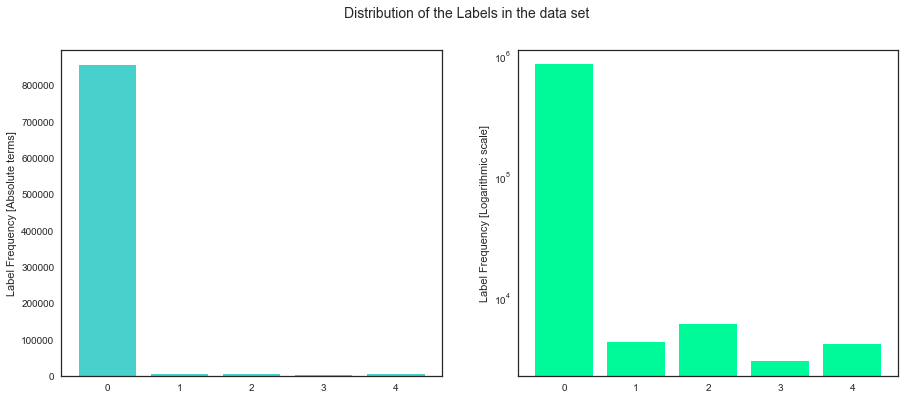

In [208]:
values_chart = dict(final_labeled_df['failure'].value_counts())

plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(1, 2, figsize = (15, 6), sharey = False, sharex = True)
fig.subplots_adjust(hspace = 0.08, wspace = 0.2) #Remove / Reduce space between plots
fig.suptitle("Distribution of the Labels in the data set", fontsize = 14)

axs[0].bar(values_chart.keys(), list(values_chart.values()), color = 'mediumturquoise', log = False)
axs[0].set(ylabel = 'Label Frequency [Absolute terms]')
axs[0].legend(loc = 'upper left', fontsize = 9)

axs[1].bar(values_chart.keys(), list(values_chart.values()), color = 'mediumspringgreen', log = True)
axs[1].set(ylabel = 'Label Frequency [Logarithmic scale]')
axs[1].legend(loc = 'upper left', fontsize = 9)

In [209]:
test_df['failure'].value_counts() #Check the failures in #occurences per component in the test_df

0    213243
2      1608
3      1128
1      1080
4      1056
Name: failure, dtype: int64

### E: Decision Tree
[[Back to the top]](#Overview) || [[To the Decision Tree Model]](#M:-Decision-Tree)

In [210]:
from sklearn.metrics import confusion_matrix
from Scripts import cm_plot as cmplot #Script for printing better confusion matrix

#Defining the output classes
classes = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

#Calculate the confusion matrix
dt_cm = confusion_matrix(dt_y_test_truth, dt_y_test_predicted)

Confusion matrix, without normalization


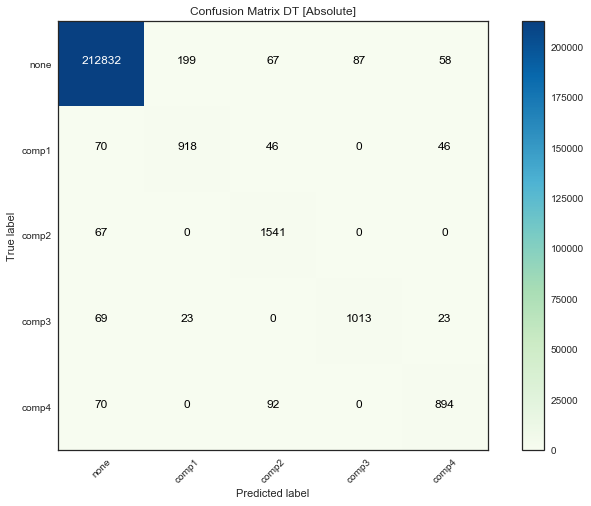

In [211]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
dt_cm_absolute = cmplot.plot_confusion_matrix(dt_cm, classes, normalize = False, 
                                             title = 'Confusion Matrix DT [Absolute]', cmap = plt.cm.GnBu)

Normalized confusion matrix


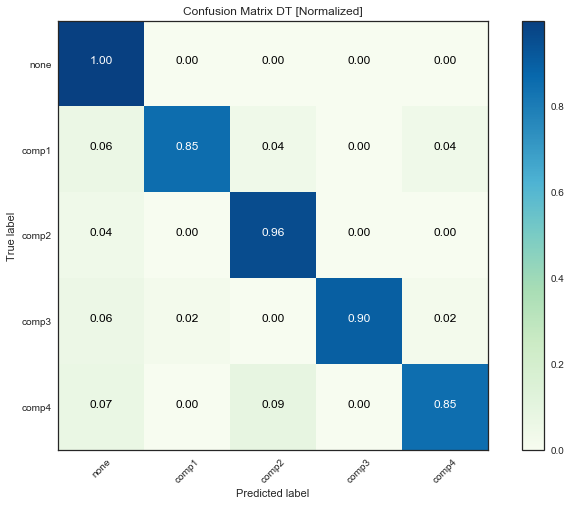

In [212]:
#Plot of the normalized Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
dt_cm_normalized = cmplot.plot_confusion_matrix(dt_cm, classes, normalize = True, 
                                             title = 'Confusion Matrix DT [Normalized]', cmap = plt.cm.GnBu)

In [213]:
from sklearn.metrics import classification_report
print(classification_report(dt_y_test_truth, dt_y_test_predicted, target_names = classes, digits = 6))

             precision    recall  f1-score   support

       none   0.998705  0.998073  0.998389    213243
      comp1   0.805263  0.850000  0.827027      1080
      comp2   0.882589  0.958333  0.918903      1608
      comp3   0.920909  0.898050  0.909336      1128
      comp4   0.875612  0.846591  0.860857      1056

avg / total   0.995893  0.995796  0.995828    218115



In [214]:
from sklearn.metrics import precision_score, recall_score

#Computation of evaluation metrics
output_labels = []
output = []

#Calculate Random Guess accuracy, precision, recall, and F1 scores
cm_row_sums = dt_cm.sum(axis = 1) #Change CM
cm_row_dist = cm_row_sums / float(np.sum(dt_cm)) #Change CM
rg_accuracy = np.ones(len(classes)) / float(len(classes))
rg_precision = cm_row_dist
rg_recall = np.ones(len(classes)) / float(len(classes))
rg_F1 = 2 * cm_row_dist / (len(classes) * cm_row_dist + 1)
output.extend([rg_accuracy.tolist(), rg_precision.tolist(),rg_recall.tolist(), rg_F1.tolist()])
output_labels.extend(['random guess accuracy', 'random guess precision', 'random guess recall', 'random guess F1'])

output_df = pd.DataFrame(output, columns = classes)
output_df.index = output_labels
output_df.transpose()

random guess accuracy  random guess precision  random guess recall  \
none                     0.2                0.977663                  0.2   
comp1                    0.2                0.004952                  0.2   
comp2                    0.2                0.007372                  0.2   
comp3                    0.2                0.005172                  0.2   
comp4                    0.2                0.004841                  0.2   

       random guess F1  
none          0.332069  
comp1         0.009664  
comp2         0.014220  
comp3         0.010082  
comp4         0.009454

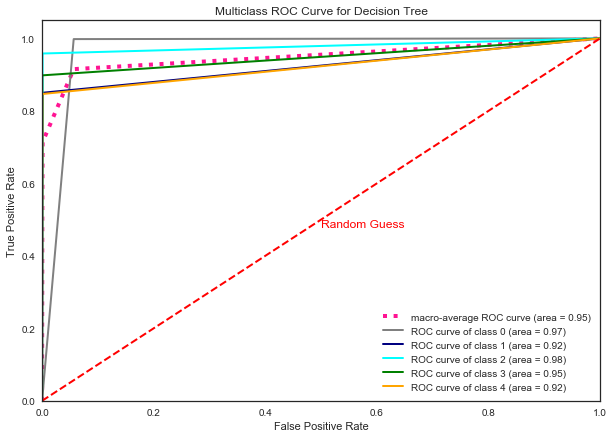

In [215]:
from Scripts import multiclass_roc as mcroc #Script for printing multiclass ROC
mcroc.plot_mc_roc(classes, dt_y_test_truth, dt_y_test_predicted, 'Multiclass ROC Curve for Decision Tree')

<BarContainer object of 19 artists>

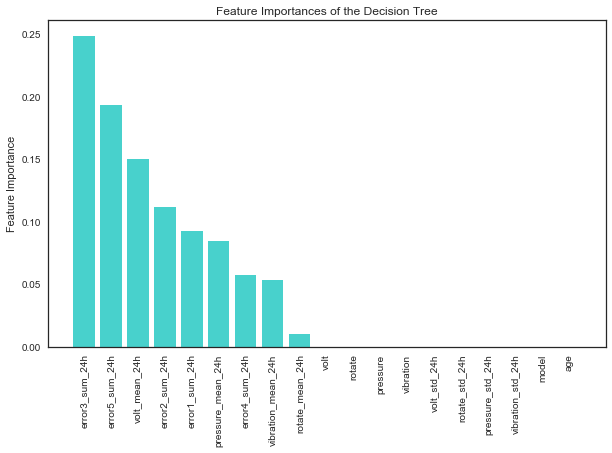

In [216]:
#Plot of feature importances
plt.figure(figsize = (10, 6))
plt.title('Feature Importances of the Decision Tree')
plt.ylabel('Feature Importance')
plt.rcParams.update({'font.size': 12})
labels, importances = zip(*sorted(zip(dt_X_test.columns, loaded_dt_model.feature_importances_),
                                      reverse = True, key = lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation = 90)
plt.bar(range(len(importances)), importances, color = 'mediumturquoise')

In [217]:
#Exporting the decision tree as a pdf
import graphviz

dot_data_dt = tree.export_graphviz(loaded_dt_model, out_file = None, 
                         feature_names = list(dt_X_test),
                         class_names = classes,
                         filled = True, rounded = True,
                         special_characters = True)
graph_dt = graphviz.Source(dot_data_dt)
fname_dt = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Plots\\dt_graph'
graph_dt.render(fname_dt)

'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Plots\\dt_graph.pdf'

In [218]:
#Displaying the decision tree
from IPython.display import IFrame

dt_pdf = 'Plots\\dt_graph.pdf'

IFrame(dt_pdf, width = 990, height = 450)

### E: Random Forest
[[Back to the top]](#Overview) || [[To the Random Forest Model]](#M:-Random-Forest)

In [219]:
from sklearn.metrics import confusion_matrix
from Scripts import cm_plot as cmplot #Script for printing better confusion matrix

#Defining the output classes
classes = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

#Calculate the confusion matrix
rf_cm = confusion_matrix(rf_y_test_truth, rf_y_test_predicted)

Confusion matrix, without normalization


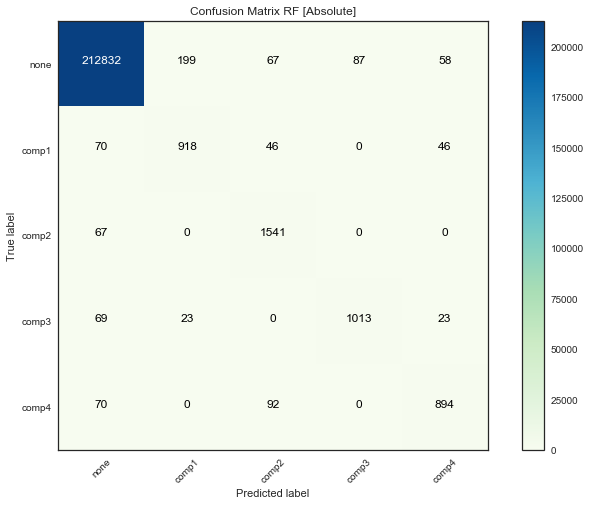

In [220]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
rf_cm_absolute = cmplot.plot_confusion_matrix(rf_cm, classes, normalize = False, 
                                             title = 'Confusion Matrix RF [Absolute]', cmap = plt.cm.GnBu)

Normalized confusion matrix


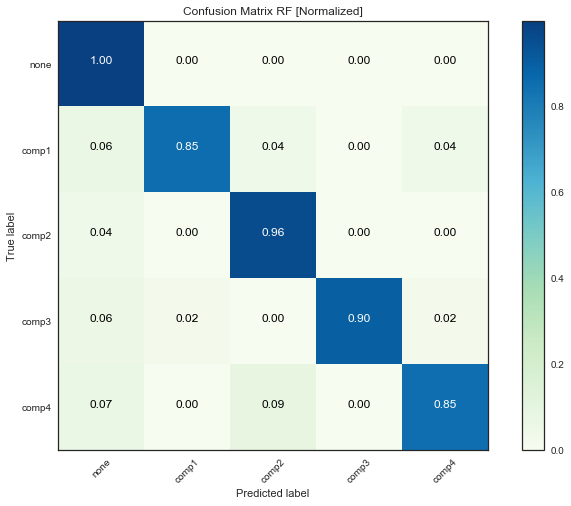

In [221]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
rf_cm_normalized = cmplot.plot_confusion_matrix(rf_cm, classes, normalize = True, 
                                             title = 'Confusion Matrix RF [Normalized]', cmap = plt.cm.GnBu)

In [222]:
from sklearn.metrics import classification_report
print(classification_report(rf_y_test_truth, rf_y_test_predicted, target_names = classes, digits = 6))

             precision    recall  f1-score   support

       none   0.998705  0.998073  0.998389    213243
      comp1   0.805263  0.850000  0.827027      1080
      comp2   0.882589  0.958333  0.918903      1608
      comp3   0.920909  0.898050  0.909336      1128
      comp4   0.875612  0.846591  0.860857      1056

avg / total   0.995893  0.995796  0.995828    218115



In [223]:
from sklearn.metrics import precision_score, recall_score

#Computation of evaluation metrics
output_labels = []
output = []

#Calculate Random Guess accuracy, precision, recall, and F1 scores
cm_row_sums = rf_cm.sum(axis = 1) #Change CM
cm_row_dist = cm_row_sums / float(np.sum(rf_cm)) #Change CM
rg_accuracy = np.ones(len(classes)) / float(len(classes))
rg_precision = cm_row_dist
rg_recall = np.ones(len(classes)) / float(len(classes))
rg_F1 = 2 * cm_row_dist / (len(classes) * cm_row_dist + 1)
output.extend([rg_accuracy.tolist(), rg_precision.tolist(),rg_recall.tolist(), rg_F1.tolist()])
output_labels.extend(['random guess accuracy', 'random guess precision', 'random guess recall', 'random guess F1'])

output_df = pd.DataFrame(output, columns = classes)
output_df.index = output_labels
output_df.transpose()

random guess accuracy  random guess precision  random guess recall  \
none                     0.2                0.977663                  0.2   
comp1                    0.2                0.004952                  0.2   
comp2                    0.2                0.007372                  0.2   
comp3                    0.2                0.005172                  0.2   
comp4                    0.2                0.004841                  0.2   

       random guess F1  
none          0.332069  
comp1         0.009664  
comp2         0.014220  
comp3         0.010082  
comp4         0.009454

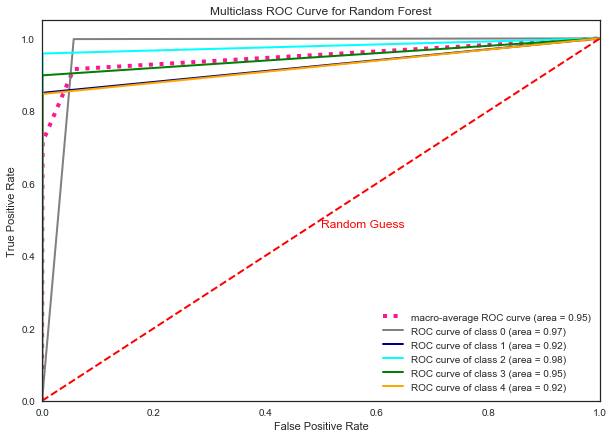

In [224]:
from Scripts import multiclass_roc as mcroc #Script for printing multiclass ROC
mcroc.plot_mc_roc(classes, rf_y_test_truth, rf_y_test_predicted, 'Multiclass ROC Curve for Random Forest')

<BarContainer object of 19 artists>

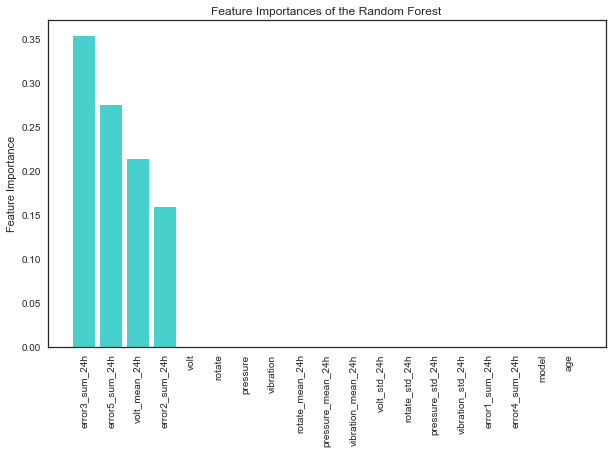

In [225]:
#Plot of feature importances
plt.figure(figsize = (10, 6))
plt.title('Feature Importances of the Random Forest')
plt.ylabel('Feature Importance')
plt.rcParams.update({'font.size': 12})
labels, importances = zip(*sorted(zip(rf_X_test.columns, loaded_rf_model.feature_importances_),
                                      reverse = True, key = lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation = 90)
plt.bar(range(len(importances)), importances, color = 'mediumturquoise')

As we can see in the results above, the random forest yields exactly the same results as the decision tree. Only in the feature importances we can see some differences. It is to be noted that we used different parameter settings in the construction of the model.
A big difference also lays in the interpretability of the RF model, which consists of 10 trees. These are not as easily visualized anymore as before the decision tree.

### E: Gradient Boosted Trees
[[Back to the top]](#Overview) || [[To the Gradient Boosted Trees Model]](#M:-Gradient-Boosted-Trees)

In [226]:
from sklearn.metrics import confusion_matrix
from Scripts import cm_plot as cmplot #Script for printing better confusion matrix

#Defining the output classes
classes = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

#Calculate the confusion matrix
xgb_cm = confusion_matrix(xgb_y_test_truth, xgb_y_test_predicted)

Confusion matrix, without normalization


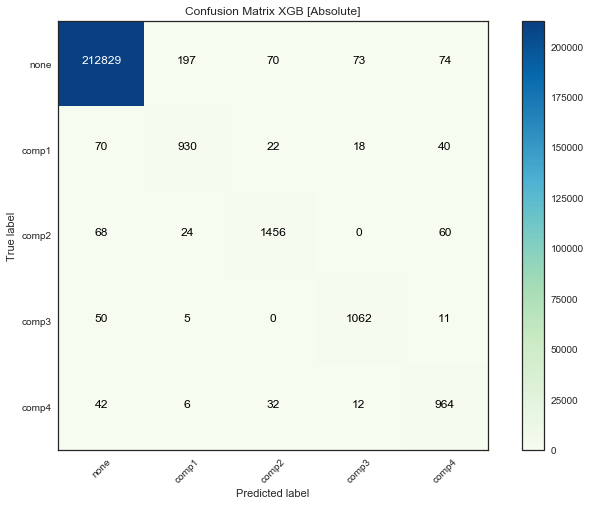

In [227]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
xgb_cm_absolute = cmplot.plot_confusion_matrix(xgb_cm, classes, normalize = False, 
                                             title = 'Confusion Matrix XGB [Absolute]', cmap = plt.cm.GnBu)

Normalized confusion matrix


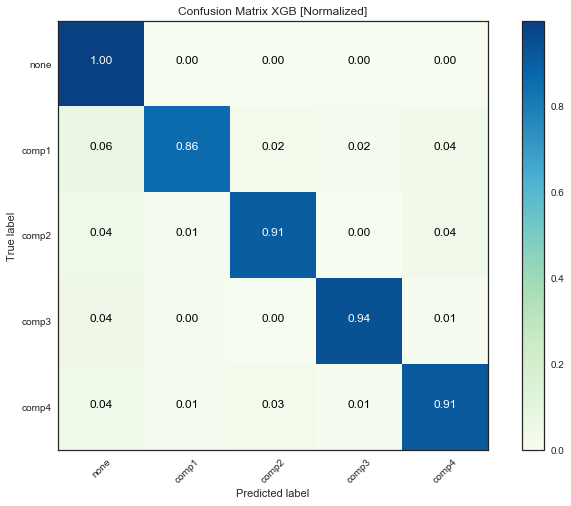

In [228]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
xgb_cm_normalized = cmplot.plot_confusion_matrix(xgb_cm, classes, normalize = True, 
                                             title = 'Confusion Matrix XGB [Normalized]', cmap = plt.cm.GnBu)

In [229]:
from sklearn.metrics import classification_report
print(classification_report(xgb_y_test_truth, xgb_y_test_predicted, target_names = classes, digits = 6))

             precision    recall  f1-score   support

       none   0.998920  0.998059  0.998489    213243
      comp1   0.800344  0.861111  0.829616      1080
      comp2   0.921519  0.905473  0.913425      1608
      comp3   0.911588  0.941489  0.926297      1128
      comp4   0.838990  0.912879  0.874376      1056

avg / total   0.996141  0.995993  0.996052    218115



In [230]:
from sklearn.metrics import precision_score, recall_score

#Computation of evaluation metrics
output_labels = []
output = []

#Calculate Random Guess accuracy, precision, recall, and F1 scores
cm_row_sums = xgb_cm.sum(axis = 1) #Change CM
cm_row_dist = cm_row_sums / float(np.sum(xgb_cm)) #Change CM
rg_accuracy = np.ones(len(classes)) / float(len(classes))
rg_precision = cm_row_dist
rg_recall = np.ones(len(classes)) / float(len(classes))
rg_F1 = 2 * cm_row_dist / (len(classes) * cm_row_dist + 1)
output.extend([rg_accuracy.tolist(), rg_precision.tolist(),rg_recall.tolist(), rg_F1.tolist()])
output_labels.extend(['random guess accuracy', 'random guess precision', 'random guess recall', 'random guess F1'])

output_df = pd.DataFrame(output, columns = classes)
output_df.index = output_labels
output_df.transpose()

random guess accuracy  random guess precision  random guess recall  \
none                     0.2                0.977663                  0.2   
comp1                    0.2                0.004952                  0.2   
comp2                    0.2                0.007372                  0.2   
comp3                    0.2                0.005172                  0.2   
comp4                    0.2                0.004841                  0.2   

       random guess F1  
none          0.332069  
comp1         0.009664  
comp2         0.014220  
comp3         0.010082  
comp4         0.009454

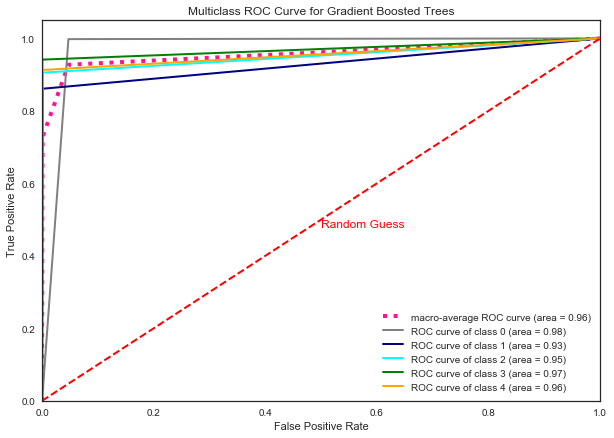

In [231]:
from Scripts import multiclass_roc as mcroc #Script for printing multiclass ROC
mcroc.plot_mc_roc(classes, xgb_y_test_truth, xgb_y_test_predicted, 'Multiclass ROC Curve for Gradient Boosted Trees')

<BarContainer object of 19 artists>

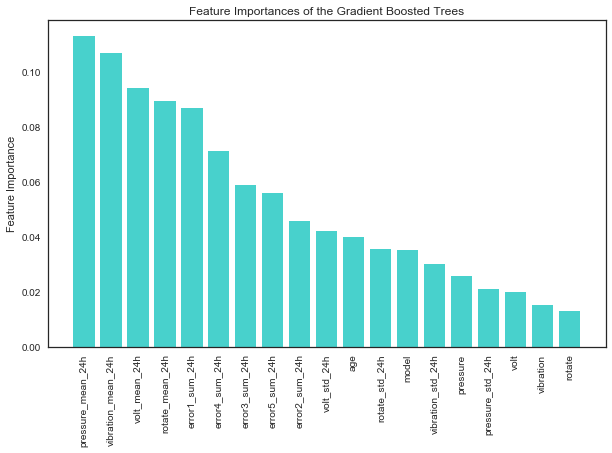

In [232]:
#Plot of feature importances
plt.figure(figsize = (10, 6))
plt.title('Feature Importances of the Gradient Boosted Trees')
plt.ylabel('Feature Importance')
plt.rcParams.update({'font.size': 12})
labels, importances = zip(*sorted(zip(xgb_X_test.columns, loaded_xgb_model.feature_importances_),
                                      reverse = True, key = lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation = 90)
plt.bar(range(len(importances)), importances, color = 'mediumturquoise')

As we can see above in the ROC curve, this model is so far the best overall compared with the Decision Tree and the Random Forest. We observe the same behaviour as in the DT and the RF, that it seems to be most difficult to recognize a failure due to comp4, which has the lowest entry in the CM. Moreover, when comparing the charts of feature importances, we can clearly see that the XGBoost model makes most use of different features, compared to the DT and RF models.

#### XGB: LIME
[[Back to the top]](#Overview) || [[To the XGB Model]](#M:-Gradient-Boosted-Trees)

In [233]:
#Impoprting LIME Tabular Explainer & LabelEncoder
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import LabelEncoder

To apply LIME, certain transformations must be performed on the data. We must e.g. tell LIME which of our feature are of a categorical nature and what values there are for the categories and so forth. These transformations are applied in the following.

In [234]:
#Creating XGB Test and Train arrays
xgb_train_lime = xgb_X_train.values
xgb_test_lime = xgb_X_test.values

#Defining Feature Names
xgb_feature_names = list(xgb_X_train.columns)

#Defining the Labels
xgb_labels = xgb_y_test_truth.values

#Defining Class (label) Names
le = LabelEncoder()
le.fit(xgb_labels)
xgb_labels = le.transform(xgb_labels)
xgb_class_names = le.classes_

#Defining Categorical Features
xgb_categorical_features = [12,13,14,15,16,17,18] #Replacement of parts is not categorical!

#Generating all subclass names for each categorical feature
xgb_categorical_names = {}
for feature in xgb_categorical_features:
    le = LabelEncoder()
    le.fit(xgb_test_lime[:, feature])
    xgb_test_lime[:, feature] = le.transform(xgb_test_lime[:, feature])
    xgb_categorical_names[feature] = le.classes_

#Definition of the prediction function
xgb_predict_fn = lambda x: loaded_xgb_model.predict_proba(x).astype(float)

In [235]:
xgb_explainer = LimeTabularExplainer(xgb_train_lime,
                                     feature_names = xgb_feature_names,
                                     class_names = xgb_class_names,
                                     categorical_features = xgb_categorical_features,
                                     categorical_names = xgb_categorical_names,
                                     kernel_width = None #Defaults to Sqrt(n_columns)*0,75
                                    )

Now we explain a single prediction:

In [236]:
xgb_y_test_truth[(xgb_y_test_truth != 0)].head(50)

339     3
340     3
341     3
342     3
343     3
344     3
345     3
346     3
347     3
348     3
349     3
350     3
351     3
352     3
353     3
354     3
355     3
356     3
357     3
358     3
359     3
360     3
361     3
362     3
699     1
700     1
701     1
702     1
703     1
704     1
705     1
706     1
707     1
708     1
709     1
710     1
711     1
712     1
713     1
714     1
715     1
716     1
717     1
718     1
719     1
720     1
721     1
722     1
1419    2
1420    2
Name: failure, dtype: int64

In [237]:
#Set random seed for reproducibility of results
np.random.seed(777)

xgb_explanation = xgb_explainer.explain_instance(xgb_test_lime[710], #Try 360, 710, 1430 #8714 is last that works
                                                 xgb_predict_fn,
                                                 labels=(1,),
                                                 top_labels = 1,
                                                 num_features = 10,
                                                 num_samples = 5000,
                                                 distance_metric = 'euclidean',
                                                 model_regressor = None
                                                )

In [238]:
xgb_explanation.available_labels() #Alternatively use .top_labels

[1]

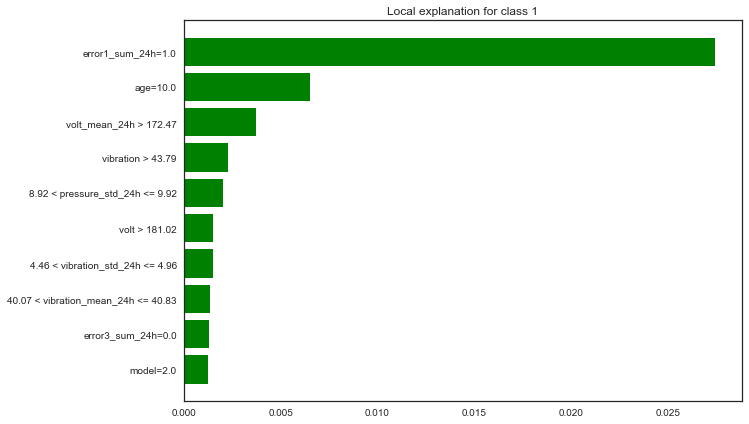

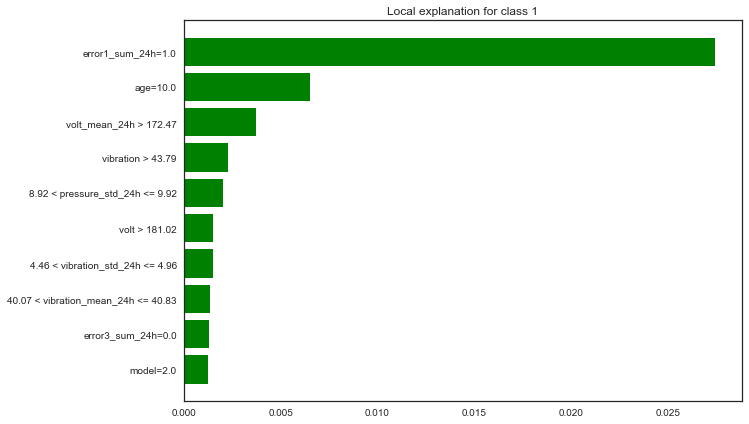

In [239]:
xgb_explanation.as_pyplot_figure(label = xgb_explanation.available_labels()[0])

In [240]:
xgb_explanation.as_map() #Alternatively use: .local_exp

{1: [(12, 0.02743600007989129),
  (18, 0.006491054147725596),
  (4, 0.0037502303222083136),
  (3, 0.002274422640221115),
  (10, 0.002005043378744457),
  (0, 0.0014989779907505687),
  (11, 0.00149080534292377),
  (7, 0.0013435514034455126),
  (14, 0.0013173030900385447),
  (17, 0.00127371151526078)]}

In [241]:
xgb_explanation.as_list(label = xgb_explanation.available_labels()[0])

[('error1_sum_24h=1.0', 0.02743600007989129),
 ('age=10.0', 0.006491054147725596),
 ('volt_mean_24h > 172.47', 0.0037502303222083136),
 ('vibration > 43.79', 0.002274422640221115),
 ('8.92 < pressure_std_24h <= 9.92', 0.002005043378744457),
 ('volt > 181.02', 0.0014989779907505687),
 ('4.46 < vibration_std_24h <= 4.96', 0.00149080534292377),
 ('40.07 < vibration_mean_24h <= 40.83', 0.0013435514034455126),
 ('error3_sum_24h=0.0', 0.0013173030900385447),
 ('model=2.0', 0.00127371151526078)]

In [242]:
xgb_explanation.predict_proba #Get Probabilities for each class from the classifier

array([7.49002713e-02, 9.25011173e-01, 3.61498978e-05, 3.01243404e-05,
       2.22819861e-05])

In [243]:
xgb_explanation.score #R^2 value of the returned explanation

0.04746800725087241

#### XGB: SHAP
[[Back to the top]](#Overview) || [[To the XGB Model]](#M:-Gradient-Boosted-Trees)

To apply SHAP, certain transformations must be performed on the data. These transformations are applied in the following.

In [244]:
#Impoprting shap
import shap

#Initializing javascript
shap.initjs()

#Creating XGB Test and Train arrays
xgb_train_shap = xgb_X_train
xgb_test_shap = xgb_X_test

In [245]:
#Choosing a random row (object) to calculate the shapley values for
xgb_test_shap.iloc[0:1,:]

volt      rotate   pressure  vibration  volt_mean_24h  \
0  159.077858  463.268115  99.836651  44.177068     175.946148   

   rotate_mean_24h  pressure_mean_24h  vibration_mean_24h  volt_std_24h  \
0       437.867975          99.109422           41.889142      24.15648   

   rotate_std_24h  pressure_std_24h  vibration_std_24h  error1_sum_24h  \
0        38.93768         10.680956            4.10046             0.0   

   error2_sum_24h  error3_sum_24h  error4_sum_24h  error5_sum_24h  model  age  
0             0.0             0.0             0.0             0.0      2   10

In [246]:
#Checking the label of the class
xgb_y_test_truth[0]

0

In [247]:
#Predicting the probabilities for each class using our learnex xgb model
loaded_xgb_model.predict_proba(xgb_test_shap.iloc[0:1,:])

array([[9.99912064e-01, 2.04573437e-05, 2.75456225e-05, 2.29542476e-05,
        1.69785038e-05]])

In [248]:
#Object that we want to explain
object_to_shap_explain = xgb_test_shap.iloc[0:1,:] #Try 360, 710, 1430, 18223, 18570, 18578!!, 27920

#Creating the Shap explainer model
xgb_shap_explainer = shap.KernelExplainer(loaded_xgb_model.predict_proba,
                                                                  xgb_train_shap.iloc[0:500,:])

#Generating the explanation for a single object
xgb_shap_values = xgb_shap_explainer.shap_values(object_to_shap_explain)

#Printing the array of the shapley values of our highest predicted class
predicted_class = loaded_xgb_model.predict(object_to_shap_explain)[0]
print(xgb_shap_values[predicted_class])

#Plotting the results
shap.force_plot(xgb_shap_values[predicted_class], object_to_shap_explain)

Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.80s/it]


[[ 0.          0.          0.          0.          0.          0.
   0.          0.04667598 -0.01500984  0.          0.          0.
   0.          0.          0.          0.          0.01347031  0.
   0.0025052   0.95227041]]


In [249]:
xgb_y_train.iloc[0:500].value_counts()

0    476
4     24
Name: failure, dtype: int64

In [250]:
print(24/500)
print(1 - 24/500)

0.048
0.952


So the base value is basically the relative occurence of the class label in the training data passed to the shap kernel explainer.

### E: Support Vector Machine
[[Back to the top]](#Overview) || [[To the Support Vector Machine Model]](#M:-Support-Vector-Machine)

In [251]:
from sklearn.metrics import confusion_matrix
from Scripts import cm_plot as cmplot #Script for printing better confusion matrix

#Defining the output classes
classes = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

#Calculate the confusion matrix
svm_cm = confusion_matrix(svm_y_test_truth, svm_y_test_predicted)

Confusion matrix, without normalization


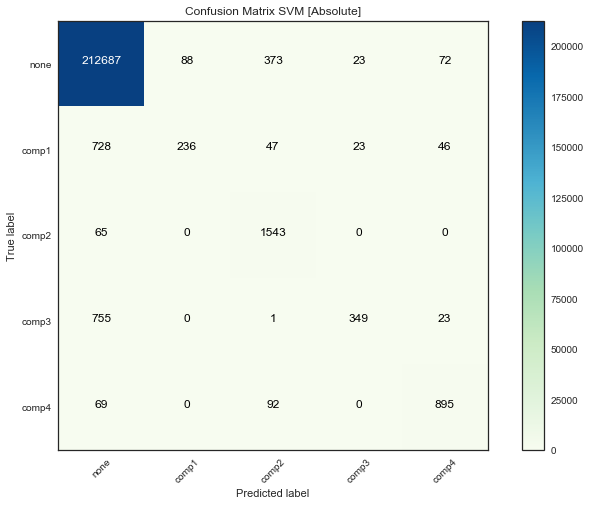

In [252]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
svm_cm_absolute = cmplot.plot_confusion_matrix(svm_cm, classes, normalize = False, 
                                             title = 'Confusion Matrix SVM [Absolute]', cmap = plt.cm.GnBu)

Normalized confusion matrix


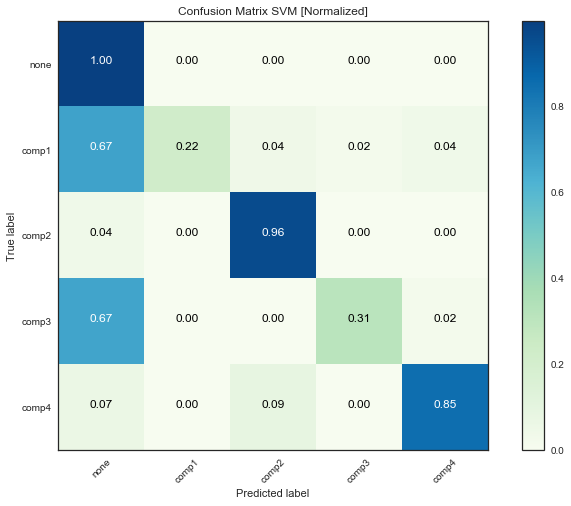

In [253]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
svm_cm_normalized = cmplot.plot_confusion_matrix(svm_cm, classes, normalize = True, 
                                             title = 'Confusion Matrix SVM [Normalized]', cmap = plt.cm.GnBu)

In [254]:
from sklearn.metrics import classification_report
print(classification_report(svm_y_test_truth, svm_y_test_predicted, target_names = classes, digits = 6))

             precision    recall  f1-score   support

       none   0.992455  0.997393  0.994918    213243
      comp1   0.728395  0.218519  0.336182      1080
      comp2   0.750486  0.959577  0.842249      1608
      comp3   0.883544  0.309397  0.458306      1128
      comp4   0.863900  0.847538  0.855641      1056

avg / total   0.988178  0.988974  0.987081    218115



In [255]:
from sklearn.metrics import precision_score, recall_score

#Computation of evaluation metrics
output_labels = []
output = []

#Calculate Random Guess accuracy, precision, recall, and F1 scores
cm_row_sums = svm_cm.sum(axis = 1) #Change CM
cm_row_dist = cm_row_sums / float(np.sum(svm_cm)) #Change CM
rg_accuracy = np.ones(len(classes)) / float(len(classes))
rg_precision = cm_row_dist
rg_recall = np.ones(len(classes)) / float(len(classes))
rg_F1 = 2 * cm_row_dist / (len(classes) * cm_row_dist + 1)
output.extend([rg_accuracy.tolist(), rg_precision.tolist(),rg_recall.tolist(), rg_F1.tolist()])
output_labels.extend(['random guess accuracy', 'random guess precision', 'random guess recall', 'random guess F1'])

output_df = pd.DataFrame(output, columns = classes)
output_df.index = output_labels
output_df.transpose()

random guess accuracy  random guess precision  random guess recall  \
none                     0.2                0.977663                  0.2   
comp1                    0.2                0.004952                  0.2   
comp2                    0.2                0.007372                  0.2   
comp3                    0.2                0.005172                  0.2   
comp4                    0.2                0.004841                  0.2   

       random guess F1  
none          0.332069  
comp1         0.009664  
comp2         0.014220  
comp3         0.010082  
comp4         0.009454

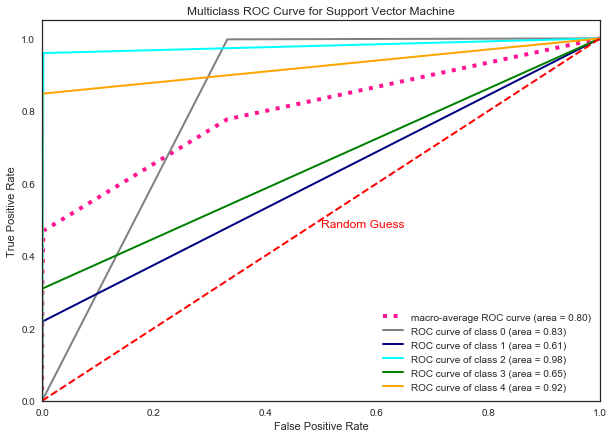

In [256]:
from Scripts import multiclass_roc as mcroc #Script for printing multiclass ROC
mcroc.plot_mc_roc(classes, svm_y_test_truth, svm_y_test_predicted, 'Multiclass ROC Curve for Support Vector Machine')

### E: Gaussian Naive Bayes
[[Back to the top]](#Overview) || [[To the Gaussian Naive Bayes Model]](#M:-Gaussian-Naive-Bayes)

In [257]:
from sklearn.metrics import confusion_matrix
from Scripts import cm_plot as cmplot #Script for printing better confusion matrix

#Defining the output classes
classes = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

#Calculate the confusion matrix
gnb_cm = confusion_matrix(gnb_y_test_truth, gnb_y_test_predicted)

Confusion matrix, without normalization


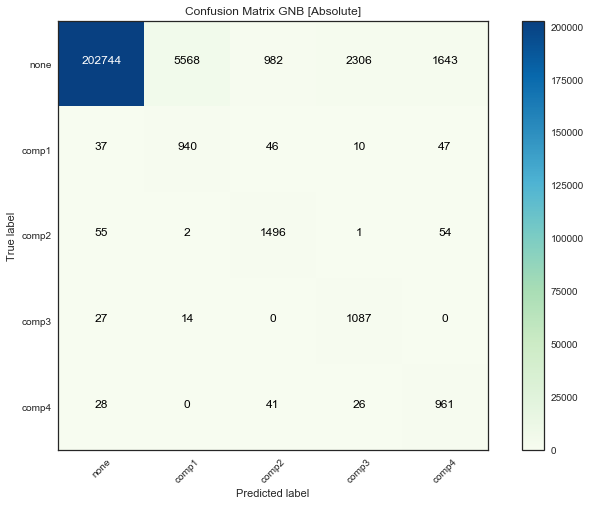

In [258]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
gnb_cm_absolute = cmplot.plot_confusion_matrix(gnb_cm, classes, normalize = False, 
                                             title = 'Confusion Matrix GNB [Absolute]', cmap = plt.cm.GnBu)

Normalized confusion matrix


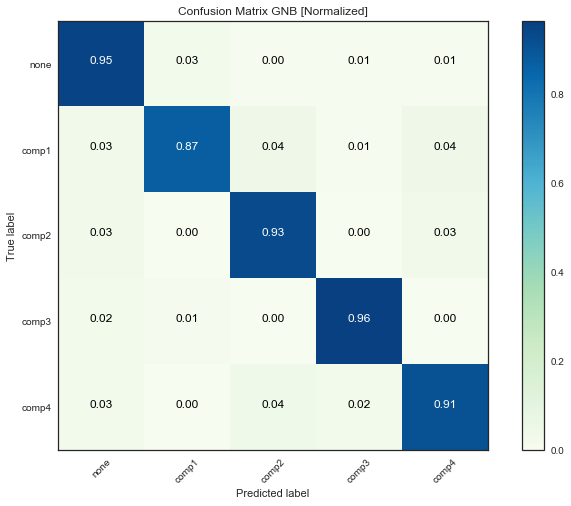

In [259]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
gnb_cm_normalized = cmplot.plot_confusion_matrix(gnb_cm, classes, normalize = True, 
                                             title = 'Confusion Matrix GNB [Normalized]', cmap = plt.cm.GnBu)

In [260]:
from sklearn.metrics import classification_report
print(classification_report(gnb_y_test_truth, gnb_y_test_predicted, target_names = classes, digits = 6))

             precision    recall  f1-score   support

       none   0.999275  0.950765  0.974417    213243
      comp1   0.144083  0.870370  0.247238      1080
      comp2   0.583236  0.930348  0.716990      1608
      comp3   0.316910  0.963652  0.476964      1128
      comp4   0.355268  0.910038  0.511034      1056

avg / total   0.985327  0.950086  0.964102    218115



In [261]:
from sklearn.metrics import precision_score, recall_score

#Computation of evaluation metrics
output_labels = []
output = []

#Calculate Random Guess accuracy, precision, recall, and F1 scores
cm_row_sums = gnb_cm.sum(axis = 1) #Change CM
cm_row_dist = cm_row_sums / float(np.sum(gnb_cm)) #Change CM
rg_accuracy = np.ones(len(classes)) / float(len(classes))
rg_precision = cm_row_dist
rg_recall = np.ones(len(classes)) / float(len(classes))
rg_F1 = 2 * cm_row_dist / (len(classes) * cm_row_dist + 1)
output.extend([rg_accuracy.tolist(), rg_precision.tolist(),rg_recall.tolist(), rg_F1.tolist()])
output_labels.extend(['random guess accuracy', 'random guess precision', 'random guess recall', 'random guess F1'])

output_df = pd.DataFrame(output, columns = classes)
output_df.index = output_labels
output_df.transpose()

random guess accuracy  random guess precision  random guess recall  \
none                     0.2                0.977663                  0.2   
comp1                    0.2                0.004952                  0.2   
comp2                    0.2                0.007372                  0.2   
comp3                    0.2                0.005172                  0.2   
comp4                    0.2                0.004841                  0.2   

       random guess F1  
none          0.332069  
comp1         0.009664  
comp2         0.014220  
comp3         0.010082  
comp4         0.009454

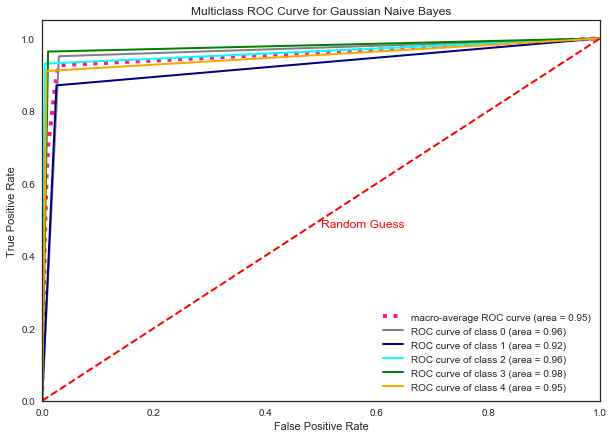

In [262]:
from Scripts import multiclass_roc as mcroc #Script for printing multiclass ROC
mcroc.plot_mc_roc(classes, gnb_y_test_truth, gnb_y_test_predicted, 'Multiclass ROC Curve for Gaussian Naive Bayes')

At this point we make a quick observation. The tree-based algorithms seem to perform generally well with high recall and high precision. When we looked at the SVM, we saw that it had quite a low recall, but quite high precision, though lower as the precision of the tree-bases methods. Now, after applying the GNB algorithm, we observe exactly the opposite: It has a very high recall rate, but quite a low precision.

In sum, this means that the SVM is better in distinguishing between the different types of failures, so when it actually recognizes a failure it is going to be a precise prediction quite often. The GNB algorithm does exactly the opposite - it is quite good in distinguishing between failure and non-failure, however, it also has a high false alarm rate.

### E: K-Nearest Neighbors
[[Back to the top]](#Overview) || [[To the K-Nearest Neighbors Model]](#M:-K-Nearest-Neighbors)

In [263]:
from sklearn.metrics import confusion_matrix
from Scripts import cm_plot as cmplot #Script for printing better confusion matrix

#Defining the output classes
classes = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

#Calculate the confusion matrix
knn_cm = confusion_matrix(knn_y_test_truth, loaded_knn_y_test_predicted)

Confusion matrix, without normalization


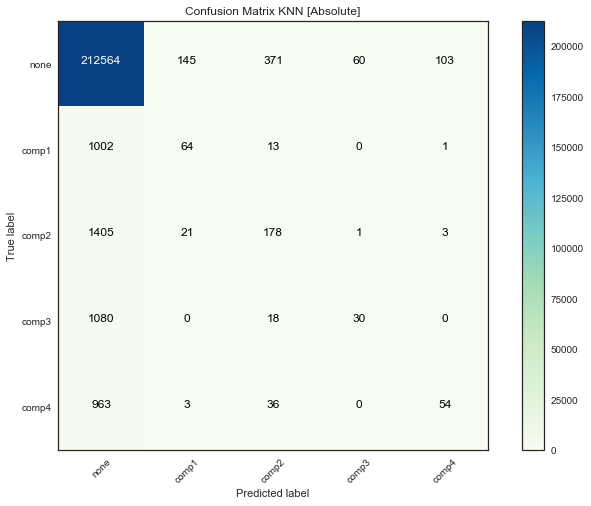

In [264]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
knn_cm_absolute = cmplot.plot_confusion_matrix(knn_cm, classes, normalize = False, 
                                             title = 'Confusion Matrix KNN [Absolute]', cmap = plt.cm.GnBu)

Normalized confusion matrix


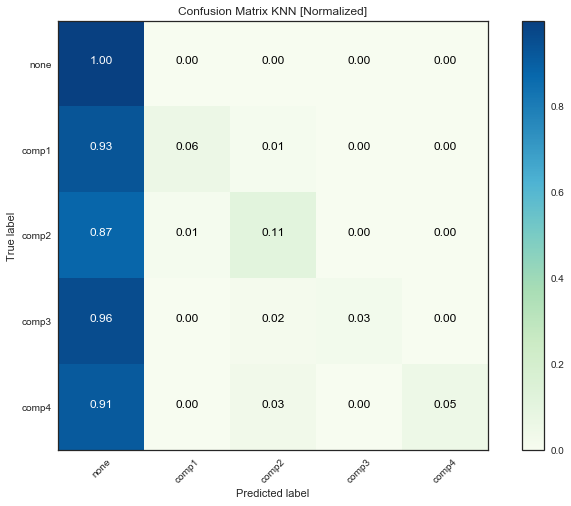

In [265]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
knn_cm_normalized = cmplot.plot_confusion_matrix(knn_cm, classes, normalize = True, 
                                             title = 'Confusion Matrix KNN [Normalized]', cmap = plt.cm.GnBu)

In [266]:
from sklearn.metrics import classification_report
print(classification_report(knn_y_test_truth, loaded_knn_y_test_predicted, target_names = classes, digits = 6))

             precision    recall  f1-score   support

       none   0.979494  0.996816  0.988079    213243
      comp1   0.274678  0.059259  0.097487      1080
      comp2   0.288961  0.110697  0.160072      1608
      comp3   0.329670  0.026596  0.049221      1128
      comp4   0.335404  0.051136  0.088743      1056

avg / total   0.964435  0.976045  0.968356    218115



In [267]:
from sklearn.metrics import precision_score, recall_score

#Computation of evaluation metrics
output_labels = []
output = []

#Calculate Random Guess accuracy, precision, recall, and F1 scores
cm_row_sums = knn_cm.sum(axis = 1) #Change CM
cm_row_dist = cm_row_sums / float(np.sum(knn_cm)) #Change CM
rg_accuracy = np.ones(len(classes)) / float(len(classes))
rg_precision = cm_row_dist
rg_recall = np.ones(len(classes)) / float(len(classes))
rg_F1 = 2 * cm_row_dist / (len(classes) * cm_row_dist + 1)
output.extend([rg_accuracy.tolist(), rg_precision.tolist(),rg_recall.tolist(), rg_F1.tolist()])
output_labels.extend(['random guess accuracy', 'random guess precision', 'random guess recall', 'random guess F1'])

output_df = pd.DataFrame(output, columns = classes)
output_df.index = output_labels
output_df.transpose()

random guess accuracy  random guess precision  random guess recall  \
none                     0.2                0.977663                  0.2   
comp1                    0.2                0.004952                  0.2   
comp2                    0.2                0.007372                  0.2   
comp3                    0.2                0.005172                  0.2   
comp4                    0.2                0.004841                  0.2   

       random guess F1  
none          0.332069  
comp1         0.009664  
comp2         0.014220  
comp3         0.010082  
comp4         0.009454

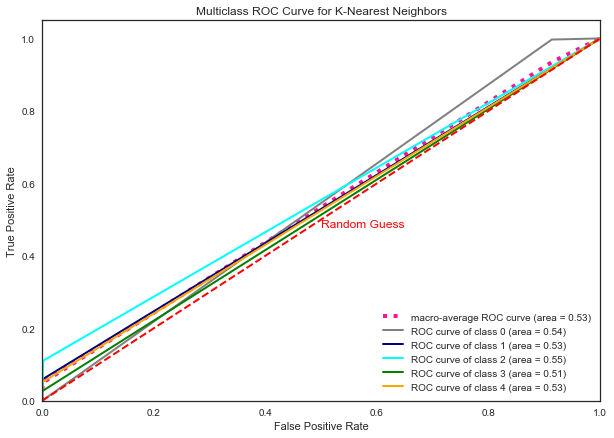

In [268]:
from Scripts import multiclass_roc as mcroc #Script for printing multiclass ROC
mcroc.plot_mc_roc(classes, knn_y_test_truth, loaded_knn_y_test_predicted, 'Multiclass ROC Curve for K-Nearest Neighbors')

As we can see in the tables and ROC chart above, the KNN does not seem to be a very good model both - in terms of Recall and Precision. It performs almost no better than random guessing.

### E: Logistic Regression
[[Back to the top]](#Overview) || [[To the Logistic Regression Model]](#M:-Logistic-Regression)

In [269]:
from sklearn.metrics import confusion_matrix
from Scripts import cm_plot as cmplot #Script for printing better confusion matrix

#Defining the output classes
classes = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

#Calculate the confusion matrix
lr_cm = confusion_matrix(lr_y_test_truth, lr_y_test_predicted)

Confusion matrix, without normalization


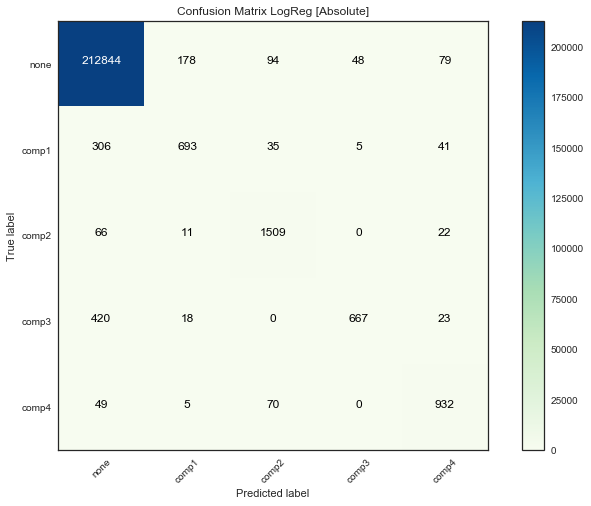

In [270]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
lr_cm_absolute = cmplot.plot_confusion_matrix(lr_cm, classes, normalize = False, 
                                             title = 'Confusion Matrix LogReg [Absolute]', cmap = plt.cm.GnBu)

Normalized confusion matrix


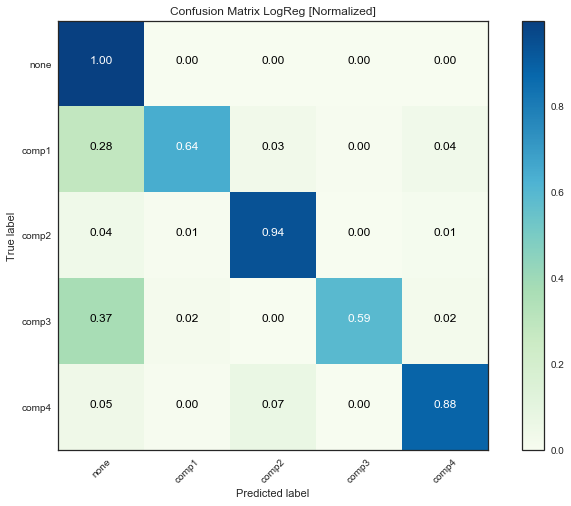

In [271]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
lr_cm_normalized = cmplot.plot_confusion_matrix(lr_cm, classes, normalize = True, 
                                             title = 'Confusion Matrix LogReg [Normalized]', cmap = plt.cm.GnBu)

In [272]:
from sklearn.metrics import classification_report
print(classification_report(lr_y_test_truth, lr_y_test_predicted, target_names = classes, digits = 6))

             precision    recall  f1-score   support

       none   0.996064  0.998129  0.997096    213243
      comp1   0.765746  0.641667  0.698237      1080
      comp2   0.883489  0.938433  0.910133      1608
      comp3   0.926389  0.591312  0.721861      1128
      comp4   0.849590  0.882576  0.865769      1056

avg / total   0.993024  0.993260  0.992915    218115



In [273]:
from sklearn.metrics import precision_score, recall_score

#Computation of evaluation metrics
output_labels = []
output = []

#Calculate Random Guess accuracy, precision, recall, and F1 scores
cm_row_sums = lr_cm.sum(axis = 1) #Change CM
cm_row_dist = cm_row_sums / float(np.sum(lr_cm)) #Change CM
rg_accuracy = np.ones(len(classes)) / float(len(classes))
rg_precision = cm_row_dist
rg_recall = np.ones(len(classes)) / float(len(classes))
rg_F1 = 2 * cm_row_dist / (len(classes) * cm_row_dist + 1)
output.extend([rg_accuracy.tolist(), rg_precision.tolist(),rg_recall.tolist(), rg_F1.tolist()])
output_labels.extend(['random guess accuracy', 'random guess precision', 'random guess recall', 'random guess F1'])

output_df = pd.DataFrame(output, columns = classes)
output_df.index = output_labels
output_df.transpose()

random guess accuracy  random guess precision  random guess recall  \
none                     0.2                0.977663                  0.2   
comp1                    0.2                0.004952                  0.2   
comp2                    0.2                0.007372                  0.2   
comp3                    0.2                0.005172                  0.2   
comp4                    0.2                0.004841                  0.2   

       random guess F1  
none          0.332069  
comp1         0.009664  
comp2         0.014220  
comp3         0.010082  
comp4         0.009454

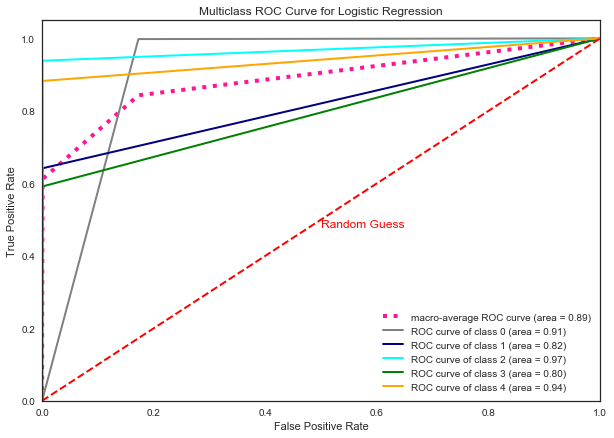

In [274]:
from Scripts import multiclass_roc as mcroc #Script for printing multiclass ROC
mcroc.plot_mc_roc(classes, lr_y_test_truth, lr_y_test_predicted, 'Multiclass ROC Curve for Logistic Regression')

'One of the simplest options to get a feeling for the "influence" of a given parameter in a linear classification model (logistic being one of those), is to consider the magnitude of its coefficient times the standard deviation of the corresponding parameter in the data.'
<br>Source: https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model

In [275]:
#Calculation of the feature importance as explained above
#First building the feature matrix with the coefficients
coefficients = pd.concat([pd.DataFrame(lr_X_test.columns),pd.DataFrame(np.transpose(loaded_lr_model.coef_))], axis = 1)
coefficients.columns = ['features', 'comp1', 'comp2', 'comp3', 'comp4', 'none'] #find order: loaded_lore_model.classes_

#Multiplying the coefficients for each class with the feature std
for row in coefficients['comp1']:
    coefficients['feature_std'] = list(np.std(lr_X_test, 0))
    coefficients['c1_feature_imp'] = coefficients['feature_std'] * coefficients['comp1']
    coefficients['c2_feature_imp'] = coefficients['feature_std'] * coefficients['comp2']
    coefficients['c3_feature_imp'] = coefficients['feature_std'] * coefficients['comp3']
    coefficients['c4_feature_imp'] = coefficients['feature_std'] * coefficients['comp4']
    coefficients['none_feature_imp'] = coefficients['feature_std'] * coefficients['none']
coefficients.head()

features     comp1     comp2     comp3     comp4      none  \
0           volt  0.000790  0.004631 -0.004342 -0.004274 -0.002411   
1         rotate  0.000646  0.000153 -0.000201  0.000417  0.000276   
2       pressure -0.003032  0.000768 -0.002265  0.010970  0.001914   
3      vibration -0.006790  0.004985  0.013190 -0.005141  0.009262   
4  volt_mean_24h -0.161498  0.267068  0.094594 -0.080085 -0.106358   

   feature_std  c1_feature_imp  c2_feature_imp  c3_feature_imp  \
0    15.510243        0.012255        0.071830       -0.067345   
1    52.834338        0.034125        0.008064       -0.010640   
2    11.118387       -0.033711        0.008541       -0.025186   
3     5.372181       -0.036476        0.026780        0.070860   
4     4.731969       -0.764202        1.263756        0.447614   

   c4_feature_imp  none_feature_imp  
0       -0.066294         -0.037388  
1        0.022035          0.014603  
2        0.121970          0.021283  
3       -0.027618          0.049755  
4       -0.378961         -0.503284

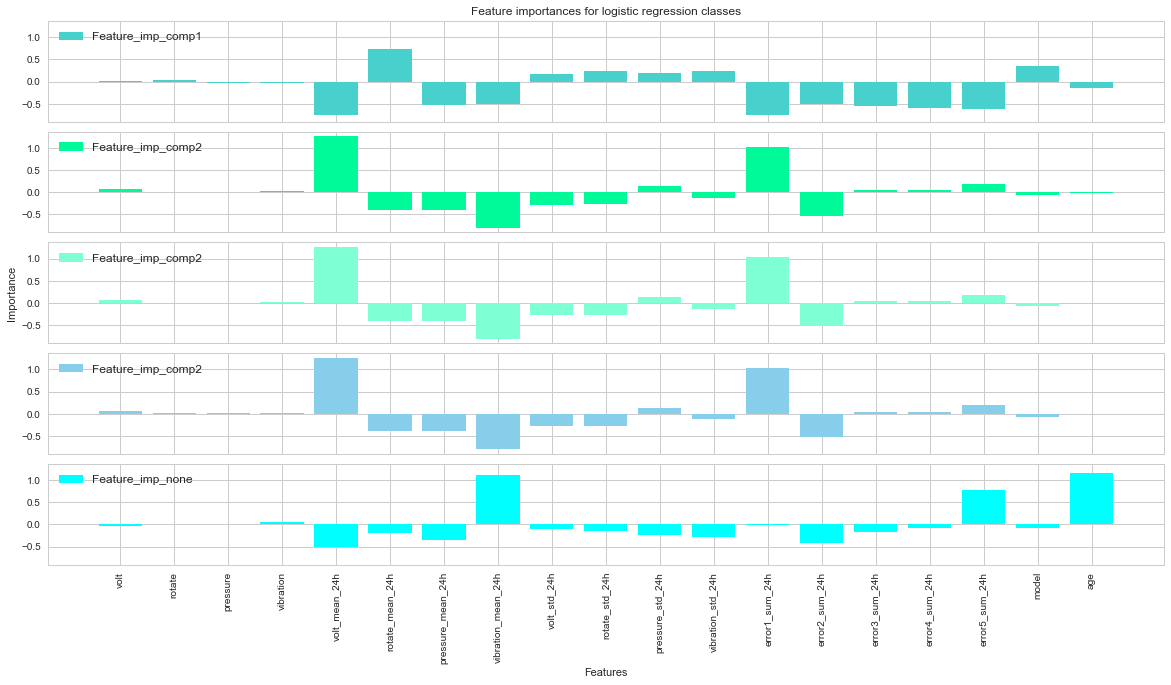

In [276]:
comp1 = dict(zip(coefficients.features, coefficients.c1_feature_imp))
comp2 = dict(zip(coefficients.features, coefficients.c2_feature_imp))
comp3 = dict(zip(coefficients.features, coefficients.c3_feature_imp))
comp4 = dict(zip(coefficients.features, coefficients.c4_feature_imp))
none = dict(zip(coefficients.features, coefficients.none_feature_imp))

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize = (20, 10), sharey = True, sharex = True)
fig.subplots_adjust(hspace = 0.1) #Remove / Reduce space between plots

ax1.bar(comp1.keys(), list(comp1.values()), color = 'mediumturquoise', label = 'Feature_imp_comp1')
ax1.set(title = 'Feature importances for logistic regression classes')
ax1.legend(loc = 'upper left', fontsize = 12)

ax2.bar(comp2.keys(), list(comp2.values()), color = 'mediumspringgreen', label = 'Feature_imp_comp2')
ax2.legend(loc = 'upper left', fontsize = 12)

ax3.bar(comp2.keys(), list(comp2.values()), color = 'aquamarine', label = 'Feature_imp_comp2')
ax3.set(ylabel = 'Importance')
ax3.legend(loc = 'upper left', fontsize = 12)

ax4.bar(comp2.keys(), list(comp2.values()), color = 'skyblue', label = 'Feature_imp_comp2')
ax4.legend(loc = 'upper left', fontsize = 12)

ax5.bar(none.keys(), list(none.values()), color = 'cyan', label = 'Feature_imp_none')
ax5.set(xlabel = 'Features')
ax5.legend(loc = 'upper left', fontsize = 12)

plt.xticks(rotation = 90)
plt.show()

As we can see in the tables and ROC chart above, the logistic regression is quite good recall and precision apart from comp1 and comp3, where its recall rate is considerably lower. For being a linear model, however, the results are very good.

### E: Multilayer Perceptron with FE
[[Back to the top]](#Overview) || [[To the Multilayer Perceptron Model]](#M:-Multilayer-Perceptron-with-FE)

In [277]:
from sklearn.metrics import confusion_matrix
from Scripts import cm_plot as cmplot #Script for printing better confusion matrix

#Defining the output classes
classes = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

#Calculate the confusion matrix
mlp_fe_cm = confusion_matrix(mlp_fe_y_test_truth, mlp_fe_y_test_predicted)

Confusion matrix, without normalization


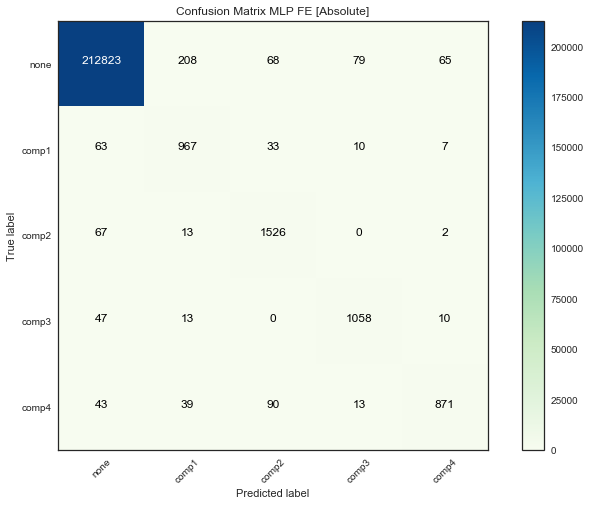

In [278]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
mlp_fe_cm_absolute = cmplot.plot_confusion_matrix(mlp_fe_cm, classes, normalize = False, 
                                             title = 'Confusion Matrix MLP FE [Absolute]', cmap = plt.cm.GnBu)

Normalized confusion matrix


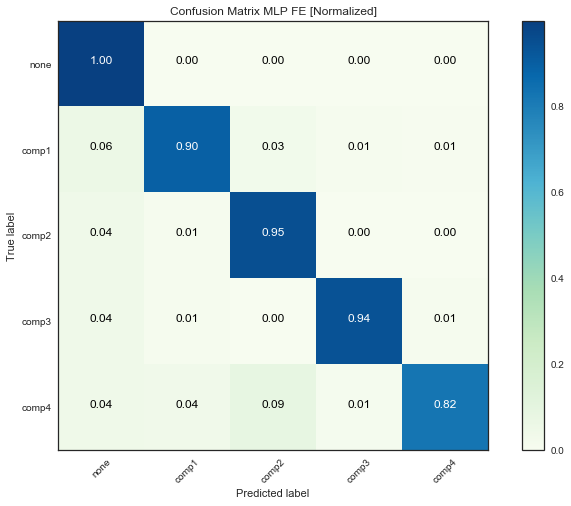

In [279]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
mlp_fe_cm_normalized = cmplot.plot_confusion_matrix(mlp_fe_cm, classes, normalize = True, 
                                             title = 'Confusion Matrix MLP FE [Normalized]', cmap = plt.cm.GnBu)

In [280]:
from sklearn.metrics import classification_report
print(classification_report(mlp_fe_y_test_truth, mlp_fe_y_test_predicted, target_names = classes, digits = 6))

             precision    recall  f1-score   support

       none   0.998967  0.998030  0.998499    213243
      comp1   0.779839  0.895370  0.833621      1080
      comp2   0.888759  0.949005  0.917895      1608
      comp3   0.912069  0.937943  0.924825      1128
      comp4   0.912042  0.824811  0.866236      1056

avg / total   0.996200  0.996011  0.996067    218115



In [281]:
from sklearn.metrics import precision_score, recall_score

#Computation of evaluation metrics
output_labels = []
output = []

#Calculate Random Guess accuracy, precision, recall, and F1 scores
cm_row_sums = mlp_fe_cm.sum(axis = 1) #Change CM
cm_row_dist = cm_row_sums / float(np.sum(mlp_fe_cm)) #Change CM
rg_accuracy = np.ones(len(classes)) / float(len(classes))
rg_precision = cm_row_dist
rg_recall = np.ones(len(classes)) / float(len(classes))
rg_F1 = 2 * cm_row_dist / (len(classes) * cm_row_dist + 1)
output.extend([rg_accuracy.tolist(), rg_precision.tolist(),rg_recall.tolist(), rg_F1.tolist()])
output_labels.extend(['random guess accuracy', 'random guess precision', 'random guess recall', 'random guess F1'])

output_df = pd.DataFrame(output, columns = classes)
output_df.index = output_labels
output_df.transpose()

random guess accuracy  random guess precision  random guess recall  \
none                     0.2                0.977663                  0.2   
comp1                    0.2                0.004952                  0.2   
comp2                    0.2                0.007372                  0.2   
comp3                    0.2                0.005172                  0.2   
comp4                    0.2                0.004841                  0.2   

       random guess F1  
none          0.332069  
comp1         0.009664  
comp2         0.014220  
comp3         0.010082  
comp4         0.009454

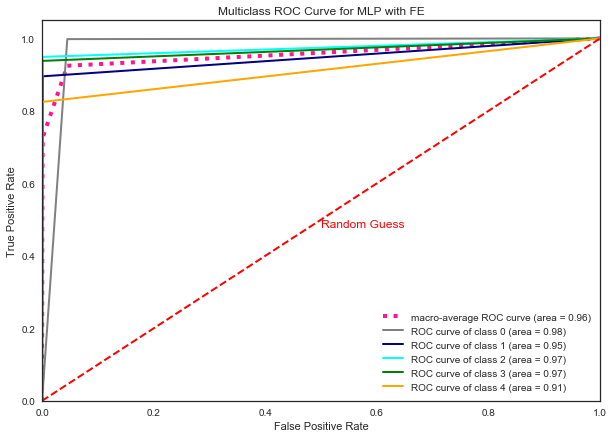

In [282]:
from Scripts import multiclass_roc as mcroc #Script for printing multiclass ROC
mcroc.plot_mc_roc(classes, mlp_fe_y_test_truth, mlp_fe_y_test_predicted, 'Multiclass ROC Curve for MLP with FE')

As we can se ein the CMs and ROC curve above, the MLP performs really well, at least as long as we leave the feature engineering in our training data for the MLP to use.

### E: Multilayer Perceptron with FE not normalized
[[Back to the top]](#Overview) || [[To the Multilayer Perceptron Model]](#M:-Multilayer-Perceptron-with-FE-not-normalized)

In [283]:
from sklearn.metrics import confusion_matrix
from Scripts import cm_plot as cmplot #Script for printing better confusion matrix

#Defining the output classes
classes = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

#Calculate the confusion matrix
mlp_fe_not_norm_cm = confusion_matrix(mlp_fe_not_norm_y_test_truth, mlp_fe_not_norm_y_test_predicted)

Confusion matrix, without normalization


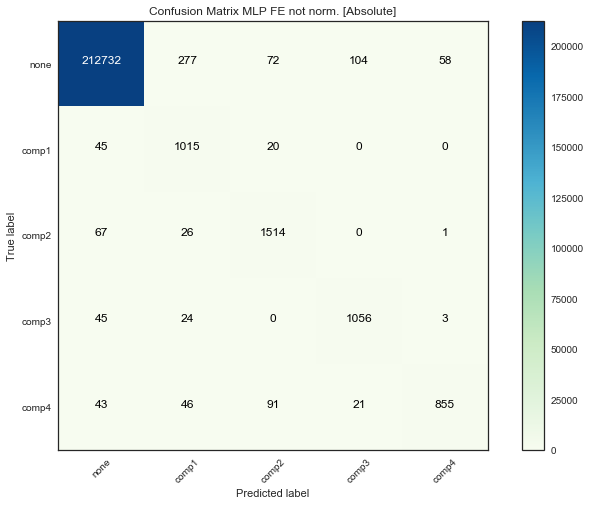

In [284]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
mlp_fe_not_norm_cm_absolute = cmplot.plot_confusion_matrix(mlp_fe_not_norm_cm, classes, normalize = False, 
                                             title = 'Confusion Matrix MLP FE not norm. [Absolute]', cmap = plt.cm.GnBu)

Normalized confusion matrix


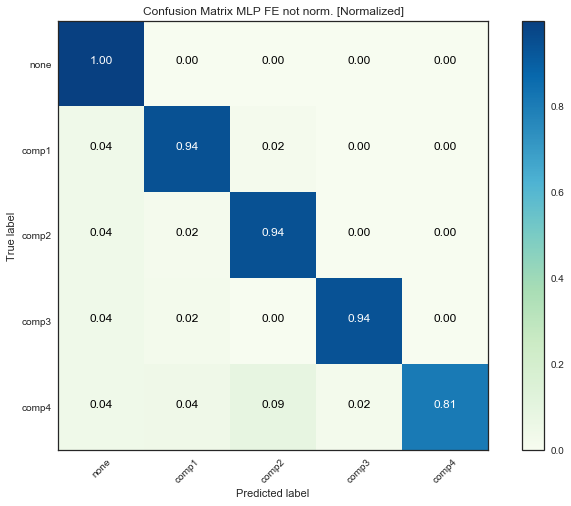

In [285]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
mlp_fe_not_norm_cm_normalized = cmplot.plot_confusion_matrix(mlp_fe_not_norm_cm, classes, normalize = True, 
                                             title = 'Confusion Matrix MLP FE not norm. [Normalized]', cmap = plt.cm.GnBu)

In [286]:
from sklearn.metrics import classification_report
print(classification_report(mlp_fe_not_norm_y_test_truth, mlp_fe_not_norm_y_test_predicted, target_names = classes, digits = 6))

             precision    recall  f1-score   support

       none   0.999061  0.997604  0.998332    213243
      comp1   0.731268  0.939815  0.822528      1080
      comp2   0.892163  0.941542  0.916188      1608
      comp3   0.894157  0.936170  0.914682      1128
      comp4   0.932388  0.809659  0.866700      1056

avg / total   0.996081  0.995677  0.995786    218115



In [287]:
from sklearn.metrics import precision_score, recall_score

#Computation of evaluation metrics
output_labels = []
output = []

#Calculate Random Guess accuracy, precision, recall, and F1 scores
cm_row_sums = mlp_fe_not_norm_cm.sum(axis = 1) #Change CM
cm_row_dist = cm_row_sums / float(np.sum(mlp_fe_not_norm_cm)) #Change CM
rg_accuracy = np.ones(len(classes)) / float(len(classes))
rg_precision = cm_row_dist
rg_recall = np.ones(len(classes)) / float(len(classes))
rg_F1 = 2 * cm_row_dist / (len(classes) * cm_row_dist + 1)
output.extend([rg_accuracy.tolist(), rg_precision.tolist(),rg_recall.tolist(), rg_F1.tolist()])
output_labels.extend(['random guess accuracy', 'random guess precision', 'random guess recall', 'random guess F1'])

output_df = pd.DataFrame(output, columns = classes)
output_df.index = output_labels
output_df.transpose()

random guess accuracy  random guess precision  random guess recall  \
none                     0.2                0.977663                  0.2   
comp1                    0.2                0.004952                  0.2   
comp2                    0.2                0.007372                  0.2   
comp3                    0.2                0.005172                  0.2   
comp4                    0.2                0.004841                  0.2   

       random guess F1  
none          0.332069  
comp1         0.009664  
comp2         0.014220  
comp3         0.010082  
comp4         0.009454

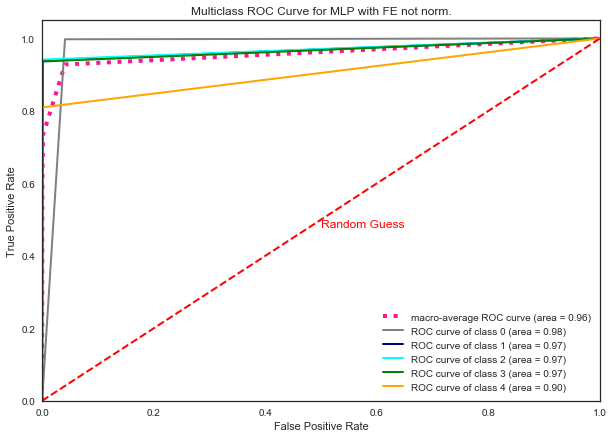

In [288]:
from Scripts import multiclass_roc as mcroc #Script for printing multiclass ROC
mcroc.plot_mc_roc(classes, mlp_fe_not_norm_y_test_truth, mlp_fe_not_norm_y_test_predicted, 'Multiclass ROC Curve for MLP with FE not norm.')

As we can see, the MLP that uses no normalization, with 2 hidden layers with 100 units in each, performs quite well too. Generally, however, ANNs can perform worse without normalizing the data first. 

#### MLP FE NN: LIME
[[Back to the top]](#Overview) || [[To the MLP FE not norm. Model]](#M:-Multilayer-Perceptron-with-FE-not-normalized)

In [289]:
#Impoprting LIME Tabular Explainer & LabelEncoder
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import LabelEncoder

To apply LIME, certain transformations must be performed on the data. We must e.g. tell LIME which of our feature are of a categorical nature and what values there are for the categories and so forth. These transformations are applied in the following.

In [290]:
#Creating XGB Test and Train arrays
mlp_fe_not_norm_train_lime = mlp_fe_not_norm_X_train.values
mlp_fe_not_norm_test_lime = mlp_fe_not_norm_X_test.values

#Defining Feature Names
mlp_fe_not_norm_feature_names = list(mlp_fe_not_norm_X_train.columns)

#Defining the Labels
mlp_fe_not_norm_labels = mlp_fe_not_norm_y_test_truth.values

#Defining Class (label) Names
le = LabelEncoder()
le.fit(mlp_fe_not_norm_labels)
mlp_fe_not_norm_labels = le.transform(mlp_fe_not_norm_labels)
mlp_fe_not_norm_class_names = le.classes_

#Defining Categorical Features
mlp_fe_not_norm_categorical_features = [12,13,14,15,16,17,18] #Replacement of parts is not categorical!

#Generating all subclass names for each categorical feature
mlp_fe_not_norm_categorical_names = {}
for feature in mlp_fe_not_norm_categorical_features:
    le = LabelEncoder()
    le.fit(mlp_fe_not_norm_test_lime[:, feature])
    mlp_fe_not_norm_test_lime[:, feature] = le.transform(mlp_fe_not_norm_test_lime[:, feature])
    mlp_fe_not_norm_categorical_names[feature] = le.classes_

#Definition of the prediction function
mlp_fe_not_norm_predict_fn = lambda x: loaded_mlp_fe_not_norm_model.predict_proba(x).astype(float)

In [291]:
mlp_fe_not_norm_explainer = LimeTabularExplainer(mlp_fe_not_norm_train_lime,
                                     feature_names = mlp_fe_not_norm_feature_names,
                                     class_names = mlp_fe_not_norm_class_names,
                                     categorical_features = mlp_fe_not_norm_categorical_features,
                                     categorical_names = mlp_fe_not_norm_categorical_names,
                                     kernel_width = None #Defaults to Sqrt(n_columns)*0,75
                                    )

Now we explain a single prediction:

In [292]:
mlp_fe_not_norm_y_test_truth[(mlp_fe_not_norm_y_test_truth != 0)].head(500)

339      3
340      3
341      3
342      3
343      3
344      3
345      3
346      3
347      3
348      3
349      3
350      3
351      3
352      3
353      3
354      3
355      3
356      3
357      3
358      3
359      3
360      3
361      3
362      3
699      1
700      1
701      1
702      1
703      1
704      1
        ..
27914    4
27915    4
27916    4
27917    4
27918    4
27919    4
27920    4
27921    4
27922    4
27923    4
28260    1
28261    1
28262    1
28263    1
28264    1
28265    1
28266    1
28267    1
28268    1
28269    1
28270    1
28271    1
28272    1
28273    1
28274    1
28275    1
28276    1
28277    1
28278    1
28279    1
Name: failure, Length: 500, dtype: int64

In [293]:
#Set random seed for reproducibility of results
np.random.seed(777)

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model.stochastic_gradient import SGDRegressor

#Try 360, 710, 1430, 18223, 18570, 18578!!, 27920, 28280
mlp_fe_not_norm_explanation = mlp_fe_not_norm_explainer.explain_instance(mlp_fe_not_norm_test_lime[710],
                                                 mlp_fe_not_norm_predict_fn,
                                                 labels=(1,),
                                                 top_labels = 1,
                                                 num_features = 10,
                                                 num_samples = 5000,
                                                 distance_metric = 'euclidean',
                                                 model_regressor = Ridge() #LinearRegression() #SGDRegressor() Ridge()
                                                )

In [294]:
mlp_fe_not_norm_explanation.available_labels() #Alternatively use .top_labels

[1]

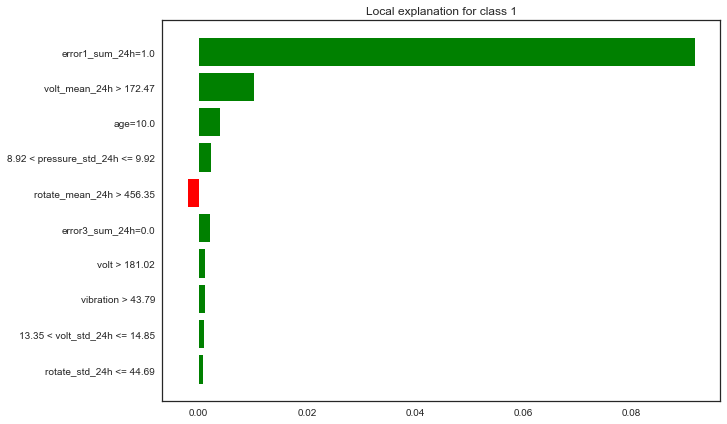

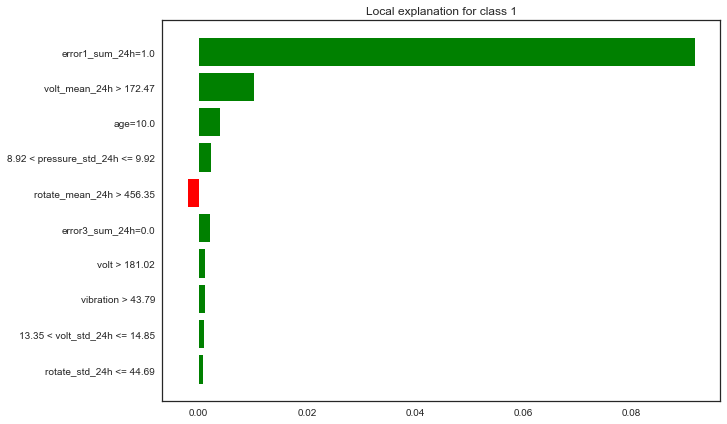

In [295]:
mlp_fe_not_norm_explanation.as_pyplot_figure(label = mlp_fe_not_norm_explanation.available_labels()[0])

In [296]:
mlp_fe_not_norm_explanation.as_map() #Alternatively use: .local_exp

{1: [(12, 0.09173980197849801),
  (4, 0.010188860350930386),
  (18, 0.0038969334693903256),
  (10, 0.002340185848944554),
  (5, -0.002064424373903322),
  (14, 0.001993608764653316),
  (0, 0.0012480567386574909),
  (3, 0.0011562718861458613),
  (8, 0.0010074303623909633),
  (9, 0.0008536922236973084)]}

In [297]:
mlp_fe_not_norm_explanation.as_list(label = mlp_fe_not_norm_explanation.available_labels()[0])

[('error1_sum_24h=1.0', 0.09173980197849801),
 ('volt_mean_24h > 172.47', 0.010188860350930386),
 ('age=10.0', 0.0038969334693903256),
 ('8.92 < pressure_std_24h <= 9.92', 0.002340185848944554),
 ('rotate_mean_24h > 456.35', -0.002064424373903322),
 ('error3_sum_24h=0.0', 0.001993608764653316),
 ('volt > 181.02', 0.0012480567386574909),
 ('vibration > 43.79', 0.0011562718861458613),
 ('13.35 < volt_std_24h <= 14.85', 0.0010074303623909633),
 ('rotate_std_24h <= 44.69', 0.0008536922236973084)]

In [298]:
mlp_fe_not_norm_explanation.predict_proba #Get Probabilities for each class from the classifier

array([1.06536331e-01, 8.93446384e-01, 1.61244417e-06, 1.56498849e-05,
       2.25527465e-08])

In [299]:
mlp_fe_not_norm_explanation.score #R^2 value of the returned explanation

0.1632539532132301

#### MLP FE NN: SHAP
[[Back to the top]](#Overview) || [[To the MLP FE NN Model]](#M:-Multilayer-Perceptron-with-FE-not-normalized)

To apply SHAP, certain transformations must be performed on the data. These transformations are applied in the following.

In [300]:
#Impoprting shap
import shap

#Initializing javascript
shap.initjs()

#Creating XGB Test and Train arrays
mlp_fe_not_norm_train_shap = mlp_fe_not_norm_X_train
mlp_fe_not_norm_test_shap = mlp_fe_not_norm_X_test

In [301]:
#Choosing a random row (object) to calculate the shapley values for
mlp_fe_not_norm_test_shap.iloc[0:1,:] #try 359, 360, 

volt      rotate   pressure  vibration  volt_mean_24h  \
0  159.077858  463.268115  99.836651  44.177068     175.946148   

   rotate_mean_24h  pressure_mean_24h  vibration_mean_24h  volt_std_24h  \
0       437.867975          99.109422           41.889142      24.15648   

   rotate_std_24h  pressure_std_24h  vibration_std_24h  error1_sum_24h  \
0        38.93768         10.680956            4.10046             0.0   

   error2_sum_24h  error3_sum_24h  error4_sum_24h  error5_sum_24h  model  age  
0             0.0             0.0             0.0             0.0      2   10

In [302]:
#Checking the label of the class
mlp_fe_not_norm_y_test_truth[0]

0

In [303]:
#Predicting the probabilities for each class using our learned mlp model
loaded_mlp_fe_not_norm_model.predict_proba(mlp_fe_not_norm_test_shap.iloc[0:1,:])

array([[9.99857605e-01, 1.32891413e-04, 9.68221898e-07, 1.69334589e-07,
        8.36649889e-06]])

In [304]:
#Object that we want to explain
object_to_shap_explain = mlp_fe_not_norm_test_shap.iloc[0:1,:] #Try 360, 710, 1430, 18223, 18570, 18578!!, 27920

#Creating the Shap explainer model
mlp_fe_not_norm_shap_explainer = shap.KernelExplainer(loaded_mlp_fe_not_norm_model.predict_proba,
                                                                  mlp_fe_not_norm_train_shap.iloc[0:500,:])

#Generating the explanation for a single object
mlp_fe_not_norm_shap_values = mlp_fe_not_norm_shap_explainer.shap_values(object_to_shap_explain)

#Printing the array of the shapley values of our highest predicted class
predicted_class = loaded_mlp_fe_not_norm_model.predict(object_to_shap_explain)[0]
print(mlp_fe_not_norm_shap_values[predicted_class])

#Plotting the results
shap.force_plot(mlp_fe_not_norm_shap_values[predicted_class], object_to_shap_explain)

Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.61s/it]


[[ 0.          0.          0.          0.          0.         -0.00230901
   0.          0.0201603   0.          0.          0.          0.
   0.00349033  0.          0.00095663  0.          0.02435889  0.
   0.00135616  0.95184432]]


### E: Multilayer Perceptron without FE
[[Back to the top]](#Overview) || [[To the Multilayer Perceptron Model]](#M:-Multilayer-Perceptron-without-FE)

In [305]:
from sklearn.metrics import confusion_matrix
from Scripts import cm_plot as cmplot #Script for printing better confusion matrix

#Defining the output classes
classes = ['none', 'comp1', 'comp2', 'comp3', 'comp4']

#Calculate the confusion matrix
mlp_cm = confusion_matrix(mlp_y_test_truth, mlp_y_test_predicted)

Confusion matrix, without normalization


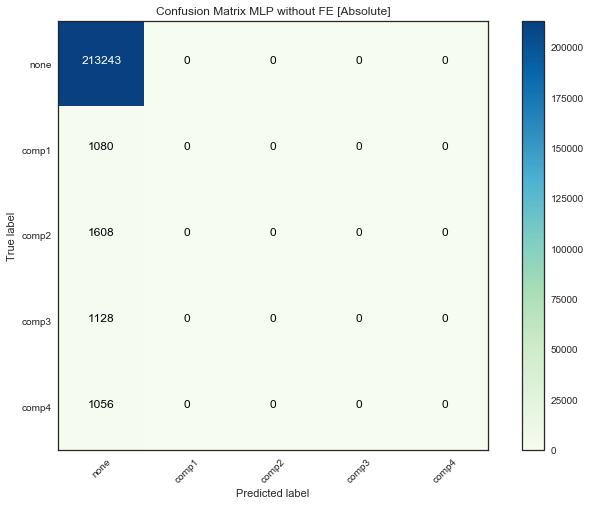

In [306]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
mlp_cm_absolute = cmplot.plot_confusion_matrix(mlp_cm, classes, normalize = False, 
                                             title = 'Confusion Matrix MLP without FE [Absolute]', cmap = plt.cm.GnBu)

Normalized confusion matrix


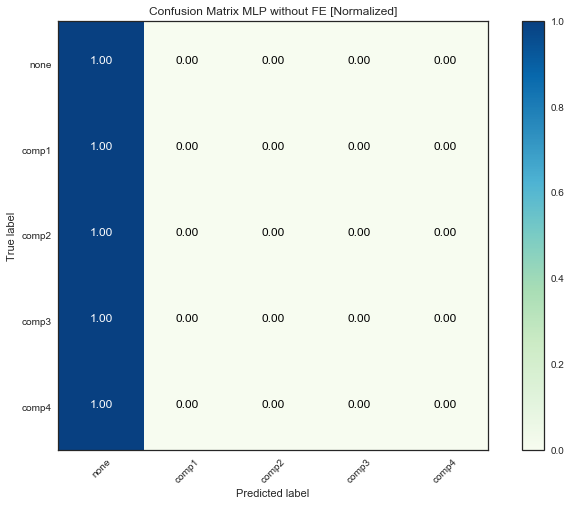

In [307]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
mlp_cm_normalized = cmplot.plot_confusion_matrix(mlp_cm, classes, normalize = True, 
                                             title = 'Confusion Matrix MLP without FE [Normalized]', cmap = plt.cm.GnBu)

In [308]:
from sklearn.metrics import classification_report
print(classification_report(mlp_y_test_truth, mlp_y_test_predicted, target_names = classes, digits = 6))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

       none   0.977663  1.000000  0.988705    213243
      comp1   0.000000  0.000000  0.000000      1080
      comp2   0.000000  0.000000  0.000000      1608
      comp3   0.000000  0.000000  0.000000      1128
      comp4   0.000000  0.000000  0.000000      1056

avg / total   0.955825  0.977663  0.966621    218115



In [309]:
from sklearn.metrics import precision_score, recall_score

#Computation of evaluation metrics
output_labels = []
output = []

#Calculate Random Guess accuracy, precision, recall, and F1 scores
cm_row_sums = mlp_cm.sum(axis = 1) #Change CM
cm_row_dist = cm_row_sums / float(np.sum(mlp_cm)) #Change CM
rg_accuracy = np.ones(len(classes)) / float(len(classes))
rg_precision = cm_row_dist
rg_recall = np.ones(len(classes)) / float(len(classes))
rg_F1 = 2 * cm_row_dist / (len(classes) * cm_row_dist + 1)
output.extend([rg_accuracy.tolist(), rg_precision.tolist(),rg_recall.tolist(), rg_F1.tolist()])
output_labels.extend(['random guess accuracy', 'random guess precision', 'random guess recall', 'random guess F1'])

output_df = pd.DataFrame(output, columns = classes)
output_df.index = output_labels
output_df.transpose()

random guess accuracy  random guess precision  random guess recall  \
none                     0.2                0.977663                  0.2   
comp1                    0.2                0.004952                  0.2   
comp2                    0.2                0.007372                  0.2   
comp3                    0.2                0.005172                  0.2   
comp4                    0.2                0.004841                  0.2   

       random guess F1  
none          0.332069  
comp1         0.009664  
comp2         0.014220  
comp3         0.010082  
comp4         0.009454

As we can see above in the results, the MLP has a really bad performance on the dataset, which is almost equivalent to random guessing. We have to keep in mind, however, that this is the first scenario in which the algorithm did not get the same input variables as the other models, which profited from our previous feature engineering. As ANNs are theoretically capable of defining their own abstract features, we did not let the MLP profit from our feature engineering in this case, to see how it performs. Needless to say, without feature engineering the MLP does a worse job on this dataset compared to all other algorithms. A possible explanation for this bevahiour is that the MLP is not build to take into consideration a temporal dimension on a dataset, which this dataset clearly contains.

### E: Outlook: Long-Short-Term-Memory-Network
[[Back to the top]](#Overview) || [[To the LSTM Model]](#M:-Outlook:-Long-Short-Term-Memory-Network)

In this section, we will look at the performance of the model on the test data. We have kept the last 25 machines (ID 76 to 100) for this purpose.

In [310]:
#Computation of testing accuracy
scores = loaded_lstm_model.evaluate(lstm_seq_array_X_test, lstm_seq_array_y_test, verbose = 1, batch_size = 200)
print('Accurracy: {}'.format(scores[1]))

163000/217515 [=====================>........] - ETA: 3: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - E

217515/217515 [==============================] - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - E

In [311]:
#Computing the confusion matrix on the test set
lstm_y_test_predicted = loaded_lstm_model.predict_classes(lstm_seq_array_X_test, verbose = 1, batch_size = 200)
lstm_y_test_truth = lstm_seq_array_y_test
lstm_cm = confusion_matrix(lstm_y_test_truth, lstm_y_test_predicted)

163000/217515 [=====================>........] - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - E

217515/217515 [==============================] - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - E

Confusion matrix, without normalization


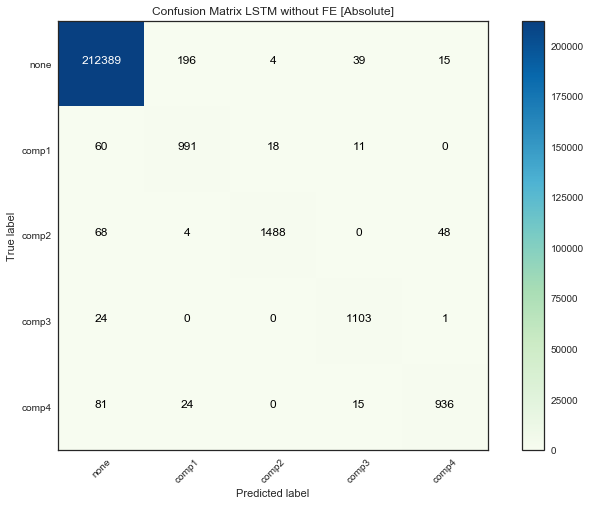

In [312]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
lstm_cm_absolute = cmplot.plot_confusion_matrix(lstm_cm, classes, normalize = False, 
                                             title = 'Confusion Matrix LSTM without FE [Absolute]', cmap = plt.cm.GnBu)

Normalized confusion matrix


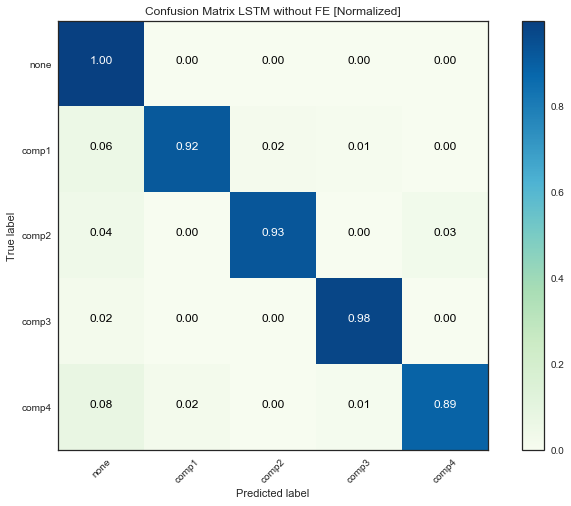

In [313]:
#Plot of the absolute Confusion Matrix on the test set
sns.set_style('white')
plt.rcParams.update({'font.size': 12})
lstm_cm_normalized = cmplot.plot_confusion_matrix(lstm_cm, classes, normalize = True, 
                                             title = 'Confusion Matrix LSTM without FE [Normalized]', cmap = plt.cm.GnBu)

In [314]:
from sklearn.metrics import classification_report
print(classification_report(lstm_y_test_truth, lstm_y_test_predicted, target_names = classes, digits = 6))

             precision    recall  f1-score   support

       none   0.998904  0.998806  0.998855    212643
      comp1   0.815638  0.917593  0.863617      1080
      comp2   0.985430  0.925373  0.954458      1608
      comp3   0.944349  0.977837  0.960801      1128
      comp4   0.936000  0.886364  0.910506      1056

avg / total   0.997306  0.997205  0.997229    217515



In [315]:
from sklearn.metrics import precision_score, recall_score

#Computation of evaluation metrics
output_labels = []
output = []

#Calculate Random Guess accuracy, precision, recall, and F1 scores
cm_row_sums = lstm_cm.sum(axis = 1) #Change CM
cm_row_dist = cm_row_sums / float(np.sum(lstm_cm)) #Change CM
rg_accuracy = np.ones(len(classes)) / float(len(classes))
rg_precision = cm_row_dist
rg_recall = np.ones(len(classes)) / float(len(classes))
rg_F1 = 2 * cm_row_dist / (len(classes) * cm_row_dist + 1)
output.extend([rg_accuracy.tolist(), rg_precision.tolist(),rg_recall.tolist(), rg_F1.tolist()])
output_labels.extend(['random guess accuracy', 'random guess precision', 'random guess recall', 'random guess F1'])

output_df = pd.DataFrame(output, columns = classes)
output_df.index = output_labels
output_df.transpose()

random guess accuracy  random guess precision  random guess recall  \
none                     0.2                0.977602                  0.2   
comp1                    0.2                0.004965                  0.2   
comp2                    0.2                0.007393                  0.2   
comp3                    0.2                0.005186                  0.2   
comp4                    0.2                0.004855                  0.2   

       random guess F1  
none          0.332065  
comp1         0.009690  
comp2         0.014258  
comp3         0.010110  
comp4         0.009480

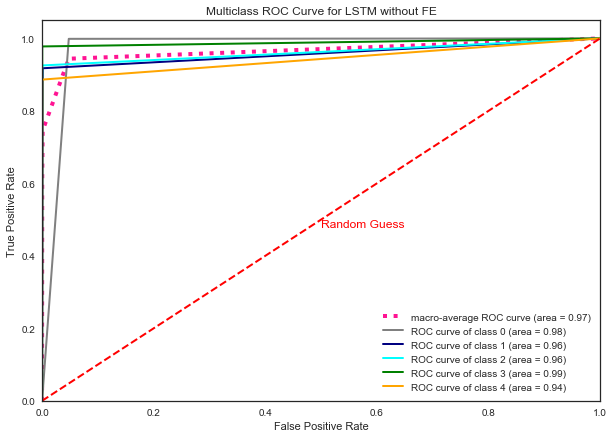

In [316]:
#Defining variables to plot ROC curves
lstm_y_test_truth_roc = pd.DataFrame(lstm_y_test_truth)[0]
lstm_y_test_predicted_roc = pd.DataFrame(lstm_y_test_predicted)[0]

from Scripts import multiclass_roc as mcroc #Script for printing multiclass ROC
mcroc.plot_mc_roc(classes, lstm_y_test_truth_roc, lstm_y_test_predicted_roc, 'Multiclass ROC Curve for LSTM without FE')

As we can see above, the LSTM performs much better than the MLP without FE, as it considers the temporal dimension. Even without feature engineering, the LSTM leads to a great result, which is on pair with the result from the XGBoost, which had been our best model so far for this dataset.

#### LSTM: LIME
[[Back to the top]](#Overview) || [[To the LSTM Model]](#M:-Outlook:-Long-Short-Term-Memory-Network)

One of the main reasons neural networks are generally not yet often used in practice is due to their black-box way of delivering prediction results and complex architecture. Especially in fields where predictions serve as a decision basis, it is fundamental that non-experts can understand why an algorithm reached a certain result. In the following, we implement a recent approach called LIME (Local Interpretable Model-Agnostic Explanations), which approximates any classifier locally, and allows us to understand predictions on an individual basis. Note that the goal is not a global model understandability, but more the interpretation of predictions on an individual level, which is mostly the requirement in practical applications.

In [317]:
#Impoprting LIME RNN Explainer & LabelEncoder
from lime.lime_tabular import RecurrentTabularExplainer
from sklearn.preprocessing import LabelEncoder

To apply LIME, certain transformations must be performed on the data. We must e.g. tell LIME which of our feature are of a categorical nature and what values there are for the categories and so forth. These transformations are applied in the following.  

In [318]:
#Creating LSTM Test and Train arrays
lstm_train_lime = train_df_ann.iloc[:,2:].values
lstm_test_lime = test_df_ann.iloc[:,2:].values

#Defining Feature Names
lstm_feature_names = list(test_df_ann.columns[2:])

#Defining the Labels Array
lstm_labels = lstm_test_lime[:, -1]

#Defining Class (label) Names
le = LabelEncoder()
le.fit(lstm_labels)
lstm_labels = le.transform(lstm_labels)
lstm_class_names = le.classes_

#Cutting the label column off
lstm_train_lime = lstm_train_lime[:,:-1]
lstm_test_lime = lstm_test_lime[:,:-1]

#Defining Categorical Features
lstm_categorical_features = [4,5,6,7,8,9,10]

#Generating all subclass names for each categorical feature
lstm_categorical_names = {}
for feature in lstm_categorical_features:
    le = LabelEncoder()
    le.fit(lstm_test_lime[:, feature])
    lstm_test_lime[:, feature] = le.transform(lstm_test_lime[:, feature])
    lstm_categorical_names[feature] = le.classes_

In [319]:
lstm_categorical_names

{4: array([0., 1.]),
 5: array([0., 1.]),
 6: array([0., 1.]),
 7: array([0., 1.]),
 8: array([0., 1.]),
 9: array([0.        , 0.33333333, 0.66666667, 1.        ]),
 10: array([0.05, 0.1 , 0.25, 0.3 , 0.45, 0.5 , 0.55, 0.6 , 0.7 , 0.8 , 0.85,
        0.9 , 0.95, 1.  ])}

In [320]:
#Creating the explainer, which works directly on sequential data
'''
lstm_explainer_seq = RecurrentTabularExplainer(lstm_seq_array_X_train,
                                               feature_names = lstm_feature_names,
                                               class_names = lstm_class_names,
                                               categorical_features = lstm_categorical_features,
                                               categorical_names = lstm_categorical_names,
                                               kernel_width = None) #Defaults to sqrt(n_features)*0,75
'''

'\nlstm_explainer_seq = RecurrentTabularExplainer(lstm_seq_array_X_train,\n                                               feature_names = lstm_feature_names,\n                                               class_names = lstm_class_names,\n                                               categorical_features = lstm_categorical_features,\n                                               categorical_names = lstm_categorical_names,\n                                               kernel_width = None) #Defaults to sqrt(n_features)*0,75\n'

In [321]:
#Exporting and saving / importing results of the lstm_explainer_seq to avoid waiting times...
import dill as pickle #To serialize more complicated objects that pickle can't
lstm_explainer_seq_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Models\\lstm_explainer.sav'
#pickle.dump(lstm_explainer_seq, open(lstm_explainer_seq_fname, 'wb')) #Unconment to overwrite existing data

In [322]:
#Reload the explainer...
loaded_lstm_explainer_seq = pickle.load(open(lstm_explainer_seq_fname, 'rb'))

Now we explain a single (sequential) prediction:

In [323]:
lstm_instances_to_explain = pd.DataFrame(lstm_seq_array_y_test)
lstm_instances_to_explain.columns = ['failure']
lstm_instances_to_explain[(lstm_instances_to_explain.failure != 0)].iloc[20:28]

failure
335      3.0
336      3.0
337      3.0
338      3.0
675      1.0
676      1.0
677      1.0
678      1.0

In [324]:
lstm_seq_array_X_test[338]  #This is the sequence object we wish to explain

array([[0.4318583 , 0.61479187, 0.50466895, 0.39650407, 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.33333334,
        0.5       ],
       [0.36781374, 0.6196954 , 0.63688946, 0.33810502, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33333334,
        0.5       ],
       [0.53627324, 0.6548414 , 0.5325729 , 0.3200847 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33333334,
        0.5       ],
       [0.47212777, 0.5137623 , 0.5211026 , 0.44640383, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33333334,
        0.5       ],
       [0.532825  , 0.59770674, 0.5045125 , 0.27483708, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33333334,
        0.5       ],
       [0.50281316, 0.5312655 , 0.39114076, 0.2505043 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.33333334,
        0.5       ],
       [0.57400423, 0.69645923, 0.6390406 , 0.5593169 , 0.

In [325]:
lstm_explanation = loaded_lstm_explainer_seq.explain_instance(lstm_seq_array_X_test[690], #Try 330, 690, 1410
                                                              loaded_lstm_model.predict,
                                                              labels=(1,),
                                                              top_labels = 1,
                                                              num_features = 10,
                                                              num_samples = 10000,
                                                              distance_metric = 'euclidean',
                                                              model_regressor = None
                                                             )
lstm_explanation.show_in_notebook() #show_all = False

In [326]:
lstm_explanation.as_map()

{1: [(10, 0.11533243303347798),
  (5, 0.11533243303347791),
  (6, 0.11533243303347789),
  (4, 0.11533243303347787),
  (8, 0.11533243303347787),
  (7, 0.11533243303347786),
  (9, 0.11533243303347784),
  (96, -0.02357791477945301),
  (109, -0.014585161620957932),
  (105, -0.010493920266279334)]}

In [327]:
lstm_explanation.score

0.851653440328738

## Deployment
[[Back to the top]](#Overview)

<i><b>CRISP-DM:</b> "Creation of the model is generally not the end of the project. Even if the purpose of the model is to increase knowledge of the data, the knowledge gained will need to be organized and presented in a way that is useful to the customer. Depending on the requirements, the deployment phase can be as simple as generating a report or as complex as implementing a repeatable data scoring (e.g. segment allocation) or data mining process. In many cases it will be the customer, not the data analyst, who will carry out the deployment steps. Even if the analyst deploys the model it is important for the customer to understand up front the actions which will need to be carried out in order to actually make use of the created models." [Source: Wiki]</i>

Ideen: Am Ende eine Tabelle aufstellen, wo die Verfahren verglichen werden bzgl. Recall, FPR, usw. auf der Komponentenebene... Also z.B. 
<p>...............Tree  |  Logit  | LSTM
<br>Recall...|
<br>FPR......|
<br>Prec......|


<b>Das eigentliche Problem was ich lösten könnte in der MA:</b>
<br>The traditional predictive maintenance machine learning models are based on feature engineering, the manual construction of variable using domain expertise and intuition. This usually makes these models hard to reuse as the feature are specific to the problem scenario and the available data may vary between customers. Perhaps the most attractive advantage of deep learning they automatically do feature engineering from the data, eliminating the need for the manual feature engineering step.
<br>When using LSTMs in the time-series domain, one important parameter is the sequence length (batch size??!!), the window to examine for failure signal. This may be viewed as picking a window_size (i.e. 5 cycles) for calculating the rolling features in the Predictive Maintenance Template. The rolling features included rolling mean and rolling standard deviation over the 5 cycles for each of the 21 sensor values. In deep learning, we allow the LSTMs to extract abstract features out of the sequence of sensor values within the window. The expectation is that patterns within these sensor values will be automatically encoded by the LSTM.
<br> -> Also Diskussion so ausgelegt: Bisher immer Traditionelles Feature Engineering, braucht viel Domain Expertise, Zeitaufwand und ist quasi nie wiederverwendbar... Mit Deep Learning wird alles gespart, wobei mehr Aufwand mit Hyperparameter tuning, aber dafür auch viel genauer wie andere Methoden... Der größte Nachteil jedoch... Wie ist das NN zur Entscheidung gekommen -> Nicht interpretierbar, nicht transparent, nicht verständlich... genau hier setze ich an mit LIME... Also um diese Schwierigkeiten zu überbrücken!
<br>Disadvantages NN: Hyperparameter tuning, set-up choice for architecture, training time, amount of data needed, transparency, 
<br>Advantages NN: Accuracy, reusability, no feature-engineering, no expertise needed for feature engineering, 

## Data Export
[[Back to the top]](#Overview)

Due to the large size of this notebook, and the big amount of RAM memory required for LIME / SHAP, we will proceed with the evaluation of those in a new notebook. Thus, we must export all important and necessary components (models, dataframes, etc.) first to continue working with them in the other notebook.

In [328]:
#Most importantly, we need the train and test dataframes
import pickle

#Specifying paths
train_df_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\train_df.sav'
test_df_fname = 'C:\\Users\\miho\\OneDrive - EXXETA\\MA\\Code & Datasets\\Data\\test_df.sav'

#Dumping the data
#pickle.dump(train_df, open(train_df_fname, 'wb')) #dumping the train_df
#pickle.dump(test_df, open(test_df_fname, 'wb')) #dumping the test_df

In [329]:
#Reload the model...
loaded_xgb_model = pickle.load(open(xgb_fname, 'rb'))

<b>SHAP Experiments:

In [330]:
xgb_test_shap.iloc[360:361,:]

volt      rotate    pressure  vibration  volt_mean_24h  \
360  150.555389  520.191515  138.559935  43.090123     171.916748   

     rotate_mean_24h  pressure_mean_24h  vibration_mean_24h  volt_std_24h  \
360       450.847409         124.814691           38.477915     13.194096   

     rotate_std_24h  pressure_std_24h  vibration_std_24h  error1_sum_24h  \
360       50.165076         12.845814           4.610286             0.0   

     error2_sum_24h  error3_sum_24h  error4_sum_24h  error5_sum_24h  model  \
360             0.0             0.0             1.0             0.0      2   

     age  
360   10

In [331]:
xgb_y_test_truth[360]

3

In [332]:
loaded_xgb_model.predict(xgb_test_shap.iloc[360:361,:])[0]

3

In [333]:
loaded_xgb_model.predict_proba(xgb_test_shap.iloc[360:361,:])

array([[4.36321399e-02, 1.28871527e-05, 1.73524309e-05, 9.56326925e-01,
        1.06956491e-05]])

In [334]:
xgb_shap_values = shap.KernelExplainer(loaded_xgb_model.predict_proba, xgb_train_shap.iloc[0:500,:])
xgb_shap_values = xgb_shap_values.shap_values(xgb_test_shap.iloc[360:361,:])

shap.force_plot(xgb_shap_values[3], xgb_test_shap.iloc[360:361,:]) #Achtung hier wollen wir Class 3 (=label!!)

Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.86s/it]


In [335]:
xgb_shap_values #Shapley values for all classes, per class one array with a shapley value for each feature

[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        , -0.33467854,  0.03639227,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         -0.2762623 ,  0.        , -0.3340897 ,  0.        ,  0.95227041]]),
 array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00055317,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.00056606]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.31485259e-05]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 3.38442435e-01, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.79788434e-01,
         0.00000000e+00, 3.38067781e-01, 0.00000000e+00, 2.82753734e-05]]),
 array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        , -0.00043205, -0.02158276,  0.        ,  0.        ,
         -0.00026337,  0.        ,  0.        ,  0.        ,  0.        ,
         -0.00065099, -0.02027962, -0.00086109, -0.00302153,  0.0471021 ]])]

In [336]:
xgb_shap_values[3] #Shapley values for class 3 (label = failure due to comp3)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.38442435e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.79788434e-01,
        0.00000000e+00, 3.38067781e-01, 0.00000000e+00, 2.82753734e-05]])

In [337]:
#Explain multiple predictions in the test set
xgb_shap_values_all = shap.KernelExplainer(loaded_xgb_model.predict_proba, xgb_train_shap.iloc[0:500,:])
xgb_shap_values_all = xgb_shap_values_all.shap_values(xgb_test_shap.iloc[350:371,:])

Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [11:57<00:00, 34.16s/it]


In [338]:
shap.force_plot(xgb_shap_values_all[0], xgb_test_shap.iloc[350:371,:])

In [339]:
#Choosing a random row (object) to calculate the shapley values for
xgb_test_shap.iloc[0:4,:]

volt      rotate    pressure  vibration  volt_mean_24h  \
0  159.077858  463.268115   99.836651  44.177068     175.946148   
1  168.874939  422.430444   90.680505  42.960636     176.669220   
2  161.841489  423.787001  108.519650  44.913357     175.283501   
3  180.679989  397.144210  109.666342  43.701090     175.607685   

   rotate_mean_24h  pressure_mean_24h  vibration_mean_24h  volt_std_24h  \
0       437.867975          99.109422           41.889142     24.156480   
1       440.562034          98.798174           41.690672     23.647956   
2       438.809223          99.634476           41.645535     23.494978   
3       437.265839         100.141980           42.054792     23.514324   

   rotate_std_24h  pressure_std_24h  vibration_std_24h  error1_sum_24h  \
0       38.937680         10.680956           4.100460             0.0   
1       35.213766         10.818075           3.916935             0.0   
2       34.946028         10.758840           3.871132             0.0   
3       35.962298         10.938867           3.517384             0.0   

   error2_sum_24h  error3_sum_24h  error4_sum_24h  error5_sum_24h  model  age  
0             0.0             0.0             0.0             0.0      2   10  
1             0.0             0.0             0.0             0.0      2   10  
2             0.0             0.0             0.0             0.0      2   10  
3             0.0             0.0             0.0             0.0      2   10

In [340]:
#Calculating the Shapley values for the single object
xgb_shap_values = shap.KernelExplainer(loaded_xgb_model.predict_proba, xgb_train_shap.iloc[0:500,:])
xgb_shap_values = xgb_shap_values.shap_values(xgb_test_shap.iloc[0:1,:])

print(xgb_shap_values[0])

#Plotting the results
shap.force_plot(xgb_shap_values[0], xgb_test_shap.iloc[0:1,:])

Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.49s/it]


[[ 0.          0.          0.          0.          0.          0.
   0.          0.04648848 -0.01545045  0.          0.          0.
   0.          0.          0.          0.          0.0142828   0.
   0.00232082  0.95227041]]


In [341]:
#Calculating the Shapley values for the single object
xgb_shap_values = shap.KernelExplainer(loaded_xgb_model.predict_proba, xgb_train_shap.iloc[0:500,:])
xgb_shap_values = xgb_shap_values.shap_values(xgb_test_shap.iloc[1:2,:])

print(xgb_shap_values[0])

#Plotting the results
shap.force_plot(xgb_shap_values[0], xgb_test_shap.iloc[1:2,:])

Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.11s/it]


[[ 0.          0.          0.          0.          0.          0.
   0.          0.04596161 -0.0150652   0.          0.          0.
   0.          0.          0.          0.          0.01409166  0.
   0.00265358  0.95227041]]


In [342]:
#Calculating the Shapley values for the single object
xgb_shap_values = shap.KernelExplainer(loaded_xgb_model.predict_proba, xgb_train_shap.iloc[0:500,:])
xgb_shap_values = xgb_shap_values.shap_values(xgb_test_shap.iloc[2:3,:])

print(xgb_shap_values[0])

#Plotting the results
shap.force_plot(xgb_shap_values[0], xgb_test_shap.iloc[2:3,:])

Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.33s/it]


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   8.29859474e-04  0.00000000e+00  0.00000000e+00  4.67796207e-02
  -1.58344666e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.35443849e-02  0.00000000e+00  2.32225182e-03  9.52270414e-01]]


In [343]:
#Calculating the Shapley values for the single object
xgb_shap_values = shap.KernelExplainer(loaded_xgb_model.predict_proba, xgb_train_shap.iloc[0:500,:])
xgb_shap_values = xgb_shap_values.shap_values(xgb_test_shap.iloc[359:360,:])

print(xgb_shap_values[3])

#Plotting the results
shap.force_plot(xgb_shap_values[3], xgb_test_shap.iloc[359:360,:])

Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.36s/it]


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.38513113e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.83622786e-01
  0.00000000e+00 3.30263159e-01 0.00000000e+00 2.82753734e-05]]


In [344]:
#Calculating the Shapley values for the single object
xgb_shap_values = shap.KernelExplainer(loaded_xgb_model.predict_proba, xgb_train_shap.iloc[0:500,:])
xgb_shap_values = xgb_shap_values.shap_values(xgb_test_shap.iloc[360:361,:])

print(xgb_shap_values[3])

#Plotting the results
shap.force_plot(xgb_shap_values[3], xgb_test_shap.iloc[360:361,:])

Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.14s/it]


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.58238589e-03 5.61557742e-03 3.36812027e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.74956480e-01
  0.00000000e+00 3.30332179e-01 0.00000000e+00 2.82753734e-05]]


In [345]:
#Calculating the Shapley values for the single object
xgb_shap_values = shap.KernelExplainer(loaded_xgb_model.predict_proba, xgb_train_shap.iloc[0:500,:])
xgb_shap_values = xgb_shap_values.shap_values(xgb_test_shap.iloc[361:362,:])

print(xgb_shap_values[3])

#Plotting the results
shap.force_plot(xgb_shap_values[3], xgb_test_shap.iloc[361:362,:])

Using 500 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.64s/it]


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.18443814e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.82218643e-03 0.00000000e+00 7.56075234e-03 2.80513327e-01
  0.00000000e+00 3.40958570e-01 0.00000000e+00 2.82753734e-05]]


In [346]:
#%%time
#Calculating the Shapley values for the single object
xgb_shap_values = shap.KernelExplainer(loaded_xgb_model.predict_proba, xgb_train_shap.iloc[0:5000,:])
xgb_shap_values = xgb_shap_values.shap_values(xgb_test_shap.iloc[361:362,:]) #, nsamples = 2

print(xgb_shap_values[3])

#Plotting the results
shap.force_plot(xgb_shap_values[3], xgb_test_shap.iloc[361:362,:])

Using 5000 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [05:44<00:00, 344.81s/it]


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.19190748e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.03709648e-01
  0.00000000e+00 3.33363890e-01 0.00000000e+00 6.26383792e-05]]


In [347]:
#%%time
#Calculating the Shapley values for the single object
xgb_shap_values = shap.KernelExplainer(loaded_xgb_model.predict_proba, xgb_train_shap.iloc[0:5000,:])
xgb_shap_values = xgb_shap_values.shap_values(xgb_test_shap.iloc[361:362,:], nsamples = 250) #, nsamples = 2

print(xgb_shap_values[3])

#Plotting the results
shap.force_plot(xgb_shap_values[3], xgb_test_shap.iloc[361:362,:])

Using 5000 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.49s/it]


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.27441329e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.46538833e-01
  0.00000000e+00 2.82284125e-01 0.00000000e+00 6.26383792e-05]]


Taking only 250 samples (nsamples = 250), i.e. 5% of the 5000 instances in the training set, reduces the training time to less than half.

In [348]:
print(len(xgb_test_shap.columns)) #Number of features in the set
print(2**len(xgb_test_shap.columns)) #Number of subsets possible

19
524288


In [349]:
print(train_df['failure'].value_counts(normalize=True))
print(train_df['failure'].value_counts(normalize=False))

0    0.980305
2    0.006932
1    0.004988
4    0.004841
3    0.002934
Name: failure, dtype: float64
0    641481
2      4536
1      3264
4      3168
3      1920
Name: failure, dtype: int64


In [350]:
print(test_df['failure'].value_counts(normalize=True))
print(test_df['failure'].value_counts(normalize=False))

0    0.977663
2    0.007372
3    0.005172
1    0.004952
4    0.004841
Name: failure, dtype: float64
0    213243
2      1608
3      1128
1      1080
4      1056
Name: failure, dtype: int64


In [351]:
test_df.groupby(['model', 'failure']).count().rename(columns = {'datetime': '#Occurences'}).iloc[:,:1]

#Occurences
model failure             
1     0              25257
      1                 96
      2                288
      3                336
      4                192
2     0              67992
      1                336
      2                384
      3                792
      4                336
3     0              60045
      1                312
      2                456
      4                192
4     0              59949
      1                336
      2                480
      4                336

In [352]:
train_df.groupby(['model', 'failure']).count().rename(columns = {'datetime': '#Occurences'}).iloc[:,:1]

#Occurences
model failure             
1     0             110175
      1                600
      2                792
      3               1224
      4                792
2     0              76419
      1                360
      2                576
      3                696
      4                456
3     0             240012
      1               1224
      2               1656
      4               1344
4     0             214875
      1               1080
      2               1512
      4                576

In [353]:
test_df.groupby(['model', 'age']).mean().rename(columns = {'datetime': '#Occurences'}).iloc[:,:1]

machineID
model age            
1     2     92.000000
      14    99.000000
      16    85.000000
2     2     90.000000
      10    86.000000
      12    87.000000
      14    97.000000
      18    94.499312
      20    98.000000
3     2     86.000000
      6     80.000000
      9     84.000000
      11    82.000000
      14    79.000000
      17    89.000000
      18    93.000000
4     1     81.000000
      5    100.000000
      12    77.000000
      14    88.000000
      17    91.000000
      18    83.000000
      19    78.000000

In [354]:
help(shap.KernelExplainer)

Help on class KernelExplainer in module shap.explainers.kernel:

class KernelExplainer(builtins.object)
 |  Uses the Kernel SHAP method to explain the output of any function.
 |  
 |  Kernel SHAP is a method that uses a special weighted linear regression
 |  to compute the importance of each feature. The computed importance values
 |  are Shapley values from game theory and also coefficents from a local linear
 |  regression.
 |  
 |  
 |  Parameters
 |  ----------
 |  model : function or iml.Model
 |      User supplied function that takes a matrix of samples (# samples x # features) and
 |      computes a the output of the model for those samples. The output can be a vector
 |      (# samples) or a matrix (# samples x # model outputs).
 |  
 |  data : numpy.array or pandas.DataFrame or iml.DenseData
 |      The background dataset to use for integrating out features. To determine the impact
 |      of a feature, that feature is set to "missing" and the change in the model output
 |    

In [355]:
help(shap.KernelExplainer.shap_values)

Help on function shap_values in module shap.explainers.kernel:

shap_values(self, X, **kwargs)
    Estimate the SHAP values for a set of samples.
    
    Parameters
    ----------
    X : numpy.array or pandas.DataFrame
        A matrix of samples (# samples x # features) on which to explain the model's output.
    
    nsamples : "auto" or int
        Number of times to re-evaluate the model when explaining each prediction. More samples
        lead to lower variance estimates of the SHAP values.
    
    l1_reg : "auto" or float
        The l1 regularization to use for feature selection (the estimation procedure is based on
        a debiased lasso). Set this to zero to remove the feature selection step before estimation.
    
    Returns
    -------
    For a models with a single output this returns a matrix of SHAP values
    (# samples x # features + 1). The last column is the base value of the model, which is
    the expected value of the model applied to the background dataset.

In [356]:
help(shap.summary_plot)

Help on function summary_plot in module shap.plots:

summary_plot(shap_values, features=None, feature_names=None, max_display=None, plot_type='dot', color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, auto_size_plot=True, layered_violin_max_num_bins=20, class_names=None)
    Create a SHAP summary plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        Matrix of SHAP values (# samples x # features)
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names : list
        Names of the features (length # features)
    
    max_display : int
        How many top features to include in the plot (default is 20, or 7 for interaction plots)
    
    plot_type : "dot" (default) or "violin"
        What type of summary plot to produce

